In [1]:
import os
import sys
import random
import warnings

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from tqdm import tqdm
from itertools import chain
from skimage.io import imread, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label

from keras.models import Model, load_model
from keras.layers import Input
from keras.layers.core import Lambda
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D
from keras.layers.merge import concatenate
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K

import tensorflow as tf
import glob



/usr/local/Cellar/python/3.6.4_4/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.


In [150]:
# Set some parameters
IMG_WIDTH = 128
IMG_HEIGHT = 128
IMG_CHANNELS = 3
TRAIN_PATH = 'train'
TEST_PATH = 'test'

warnings.filterwarnings('ignore', category=UserWarning, module='skimage')
seed = 42
random.seed = seed
np.random.seed = seed
train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images/tmp')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images/tmp')]

In [151]:
train_ids

['train/images/tmp/TCGA-AR-A1AS-01Z-00-DX1-4-6',
 'train/images/tmp/TCGA-49-4488-01Z-00-DX1-7-5',
 'train/images/tmp/TCGA-G9-6348-01Z-00-DX1-0-0',
 'train/images/tmp/TCGA-DK-A2I6-01A-01-TS1-1-6',
 'train/images/tmp/TCGA-E2-A14V-01Z-00-DX1-7-2',
 'train/images/tmp/TCGA-B0-5710-01Z-00-DX1-4-4',
 'train/images/tmp/TCGA-A7-A13E-01Z-00-DX1-5-1',
 'train/images/tmp/TCGA-21-5784-01Z-00-DX1-3-1',
 'train/images/tmp/TCGA-B0-5698-01Z-00-DX1-3-1',
 'train/images/tmp/TCGA-G9-6363-01Z-00-DX1-7-3',
 'train/images/tmp/TCGA-38-6178-01Z-00-DX1-2-3',
 'train/images/tmp/TCGA-A7-A13F-01Z-00-DX1-1-1',
 'train/images/tmp/TCGA-G9-6356-01Z-00-DX1-2-7',
 'train/images/tmp/TCGA-50-5931-01Z-00-DX1-2-2',
 'train/images/tmp/TCGA-G9-6336-01Z-00-DX1-6-7',
 'train/images/tmp/TCGA-G9-6348-01Z-00-DX1-2-2',
 'train/images/tmp/TCGA-49-4488-01Z-00-DX1-5-7',
 'train/images/tmp/TCGA-AR-A1AS-01Z-00-DX1-6-4',
 'train/images/tmp/TCGA-E2-A14V-01Z-00-DX1-5-0',
 'train/images/tmp/TCGA-DK-A2I6-01A-01-TS1-3-4',
 'train/images/tmp/T

In [152]:
test_ids

['test/images/tmp/TCGA-RD-A8N9-01A-01-TS1-5-3',
 'test/images/tmp/TCGA-HE-7129-01Z-00-DX1-7-4',
 'test/images/tmp/TCGA-NH-A8F7-01A-01-TS1-7-7',
 'test/images/tmp/TCGA-HE-7129-01Z-00-DX1-5-6',
 'test/images/tmp/TCGA-RD-A8N9-01A-01-TS1-7-1',
 'test/images/tmp/TCGA-NH-A8F7-01A-01-TS1-5-5',
 'test/images/tmp/TCGA-NH-A8F7-01A-01-TS1-3-3',
 'test/images/tmp/TCGA-HE-7129-01Z-00-DX1-3-0',
 'test/images/tmp/TCGA-RD-A8N9-01A-01-TS1-1-7',
 'test/images/tmp/TCGA-NH-A8F7-01A-01-TS1-1-1',
 'test/images/tmp/TCGA-RD-A8N9-01A-01-TS1-3-5',
 'test/images/tmp/TCGA-HE-7129-01Z-00-DX1-1-2',
 'test/images/tmp/TCGA-HE-7129-01Z-00-DX1-1-3',
 'test/images/tmp/TCGA-RD-A8N9-01A-01-TS1-3-4',
 'test/images/tmp/TCGA-NH-A8F7-01A-01-TS1-1-0',
 'test/images/tmp/TCGA-RD-A8N9-01A-01-TS1-1-6',
 'test/images/tmp/TCGA-HE-7129-01Z-00-DX1-3-1',
 'test/images/tmp/TCGA-NH-A8F7-01A-01-TS1-3-2',
 'test/images/tmp/TCGA-NH-A8F7-01A-01-TS1-5-4',
 'test/images/tmp/TCGA-RD-A8N9-01A-01-TS1-7-0',
 'test/images/tmp/TCGA-HE-7129-01Z-00-DX

In [155]:
from PIL import Image
# Get and resize train images and masks
X_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_train = np.zeros((len(train_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)
print('Getting and resizing train images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH
    if os.path.isfile(path + '/images/tmp/' + id_ + '.png'):
        img = imread(path + '/images/tmp/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_train[n] = img
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = np.load(path + '/masks/tmp/' + id_ + '.npy')
        mask = np.expand_dims(mask_, axis=-1)
        Y_train[n] = mask

Getting and resizing train images and masks ... 


  0%|          | 0/1536 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'train/masks/tmp/train/images/tmp/TCGA-AR-A1AS-01Z-00-DX1-4-6.npy'

In [133]:
# Get and resize test images
X_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS), dtype=np.uint8)
Y_test = np.zeros((len(test_ids), IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

sizes_test = []
print('Getting and resizing test images ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH
    if os.path.isfile(path + '/images/tmp/' + id_ + '.png'):
        img = imread(path + '/images/tmp/' + id_ + '.png')[:,:,:IMG_CHANNELS]
        sizes_test.append([img.shape[0], img.shape[1]])
        #img = resize(img, (IMG_HEIGHT, IMG_WIDTH), mode='constant', preserve_range=True)
        X_test[n] = img
        
        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask = np.load(path + '/masks/tmp/' + id_ + '.npy')
        mask = np.expand_dims(mask_, axis=-1)
        #mask_ = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant', 
        #                             preserve_range=True), axis=-1)
        #mask = np.maximum(mask, mask_)
        Y_test[n] = mask

print('Done!')

Getting and resizing test images ... 


100%|██████████| 385/385 [00:01<00:00, 210.49it/s]

Done!


/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


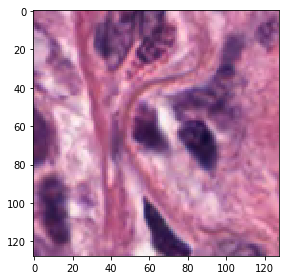

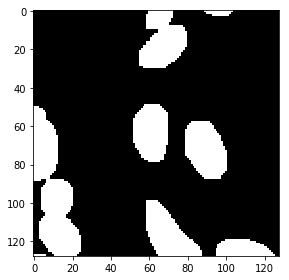

624

In [101]:
# Check if training data looks all right
ix = random.randint(0, len(train_ids))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
ix

In [103]:
# Dice coefficient
def dice_coef(y_true, y_pred):
#    score, up_opt = tf.metrics.mean_iou(y_true, y_pred, 2)
    intersection = K.sum(y_pred * y_true)
    union = K.sum(y_pred + y_true - y_pred * y_true)
    score = 2 * intersection / (union + intersection)
    K.get_session().run(tf.local_variables_initializer())
    score = tf.identity(score)
    return score

def iou(y_true, y_pred):
    intersection = K.sum(y_pred * y_true)
    union = K.sum(y_pred + y_true) - intersection
    score = intersection / union
    K.get_session().run(tf.local_variables_initializer())
    score = tf.identity(score)
    return score

In [60]:
# Build U-Net model
inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
s = Lambda(lambda x: x / 255) (inputs)

c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (s)
c1 = Conv2D(8, (3, 3), activation='relu', padding='same') (c1)
p1 = MaxPooling2D((2, 2)) (c1)

c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (p1)
c2 = Conv2D(16, (3, 3), activation='relu', padding='same') (c2)
p2 = MaxPooling2D((2, 2)) (c2)

c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (p2)
c3 = Conv2D(32, (3, 3), activation='relu', padding='same') (c3)
p3 = MaxPooling2D((2, 2)) (c3)

c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (p3)
c4 = Conv2D(64, (3, 3), activation='relu', padding='same') (c4)
p4 = MaxPooling2D(pool_size=(2, 2)) (c4)

c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (p4)
c5 = Conv2D(128, (3, 3), activation='relu', padding='same') (c5)

u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same') (c5)
u6 = concatenate([u6, c4])
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (u6)
c6 = Conv2D(64, (3, 3), activation='relu', padding='same') (c6)

u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same') (c6)
u7 = concatenate([u7, c3])
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (u7)
c7 = Conv2D(32, (3, 3), activation='relu', padding='same') (c7)

u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same') (c7)
u8 = concatenate([u8, c2])
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (u8)
c8 = Conv2D(16, (3, 3), activation='relu', padding='same') (c8)

u9 = Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same') (c8)
u9 = concatenate([u9, c1], axis=3)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (u9)
c9 = Conv2D(8, (3, 3), activation='relu', padding='same') (c9)

outputs = Conv2D(1, (1, 1), activation='sigmoid') (c9)

model = Model(inputs=[inputs], outputs=[outputs])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[dice_coef])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
lambda_9 (Lambda)               (None, 128, 128, 3)  0           input_9[0][0]                    
__________________________________________________________________________________________________
conv2d_153 (Conv2D)             (None, 128, 128, 8)  224         lambda_9[0][0]                   
__________________________________________________________________________________________________
conv2d_154 (Conv2D)             (None, 128, 128, 8)  584         conv2d_153[0][0]                 
__________________________________________________________________________________________________
max_poolin

In [63]:
# Fit model
earlystopper = EarlyStopping(patience=5, verbose=1)
checkpointer = ModelCheckpoint('model-4.h5', verbose=1, save_best_only=True)
results = model.fit(X_train, Y_train, validation_split=0.1, batch_size=4, epochs=30, 
                    callbacks=[earlystopper, checkpointer])

Train on 1383 samples, validate on 154 samples
Epoch 1/30
1380/1383 [============================>.] - ETA: 0s - loss: 0.3253 - mean_iou: 0.6644
Epoch 00001: val_loss improved from inf to 0.32871, saving model to model-4.h5
1383/1383 [==============================] - 62s 45ms/step - loss: 0.3252 - mean_iou: 0.6646 - val_loss: 0.3287 - val_mean_iou: 0.6816
Epoch 2/30
1380/1383 [============================>.] - ETA: 0s - loss: 0.2991 - mean_iou: 0.6949
Epoch 00002: val_loss improved from 0.32871 to 0.31929, saving model to model-4.h5
1383/1383 [==============================] - 61s 44ms/step - loss: 0.2991 - mean_iou: 0.6950 - val_loss: 0.3193 - val_mean_iou: 0.7040
Epoch 3/30
1380/1383 [============================>.] - ETA: 0s - loss: 0.2926 - mean_iou: 0.7012
Epoch 00003: val_loss improved from 0.31929 to 0.31506, saving model to model-4.h5
1383/1383 [==============================] - 68s 49ms/step - loss: 0.2925 - mean_iou: 0.7013 - val_loss: 0.3151 - val_mean_iou: 0.6940
Epoch 4/3

In [135]:
# Predict on train, val and test
model = load_model('model-4.h5', custom_objects={'mean_iou': mean_iou})


In [136]:
preds_train = model.predict(X_train[:int(X_train.shape[0]*0.9)], verbose=1)
preds_val = model.predict(X_train[int(X_train.shape[0]*0.9):], verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

385/385 [==============================] - 6s 16ms/step


In [143]:
#print(preds_test_t)
#print(Y_test.shape)
#print(K.get_session().run(K.sum(preds_test_t * Y_test)))
#print(K.get_session().run(K.sum(preds_train_t)))
#print(K.get_session().run(Y_train[:int(Y_train.shape[0]*0.9)]))
print(K.get_session().run(mean_iou(preds_train_t, tf.to_int32(Y_train[:int(Y_train.shape[0]*0.9)]))))
print(K.get_session().run(mean_iou(preds_val_t, tf.to_int32(Y_train[int(Y_train.shape[0]*0.9):]))))
print(K.get_session().run(mean_iou(preds_test_t, tf.to_int32(Y_test))))

0.8756516309887147
0.8255054208956628
0.3840673683472642


In [96]:
# Create list of upsampled test masks
preds_test_upsampled = []
for i in range(len(preds_test)):
    preds_test_upsampled.append(preds_test[i])

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


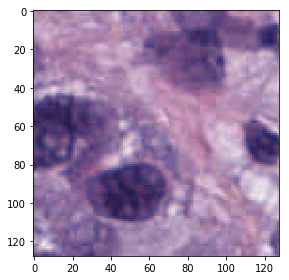

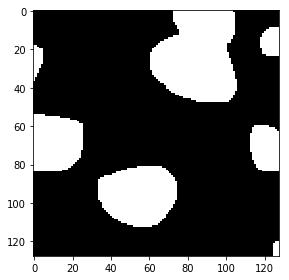

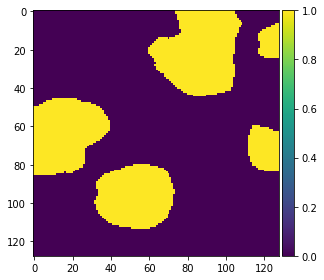

In [139]:
# Perform a sanity check on some random training samples
ix = random.randint(0, len(preds_train_t))
imshow(X_train[ix])
plt.show()
imshow(np.squeeze(Y_train[ix]))
plt.show()
imshow(np.squeeze(preds_train_t[ix]))
plt.show()

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


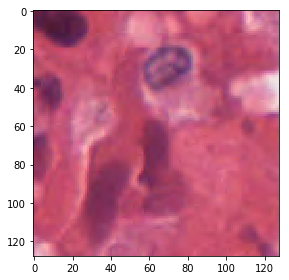

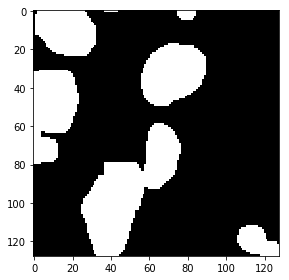

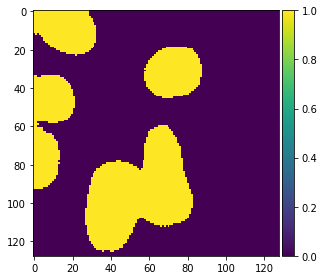

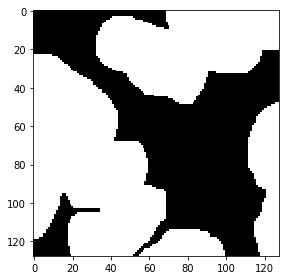

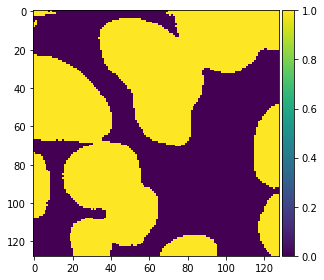

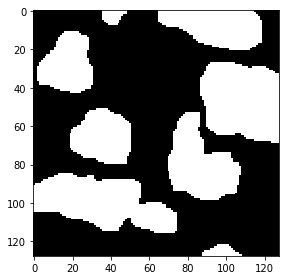

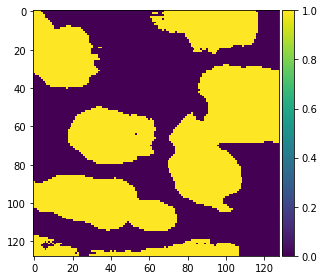

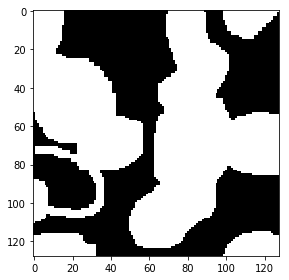

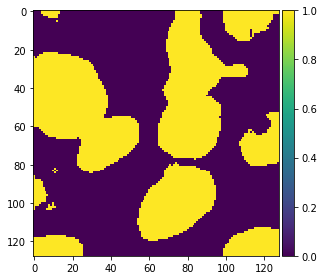

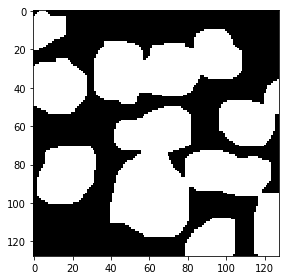

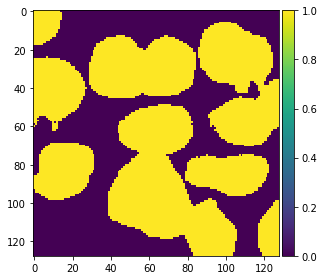

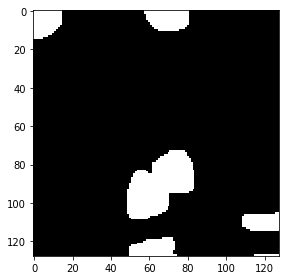

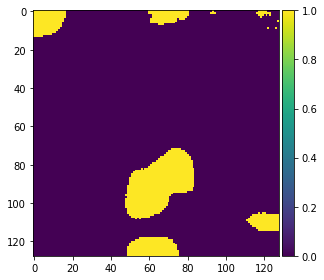

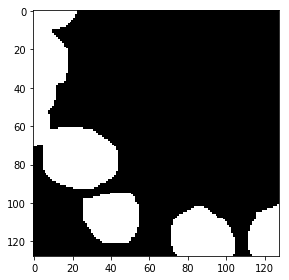

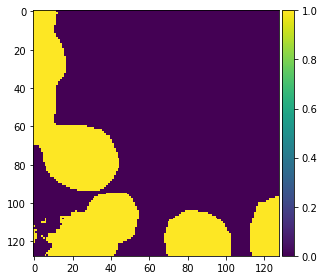

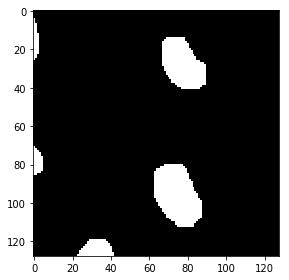

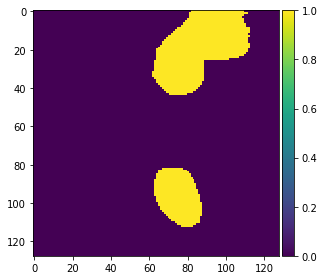

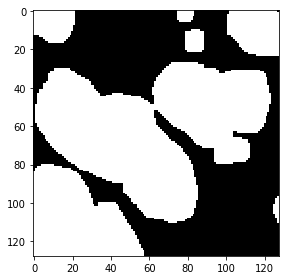

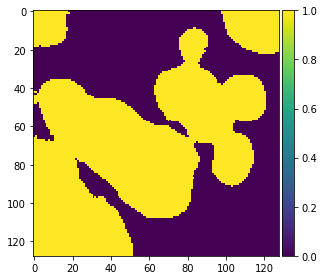

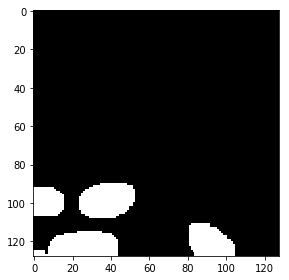

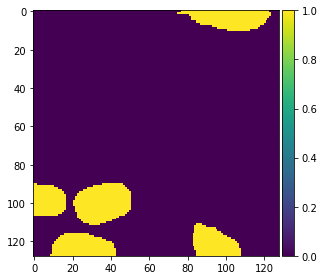

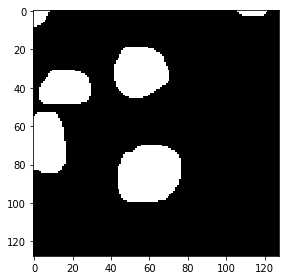

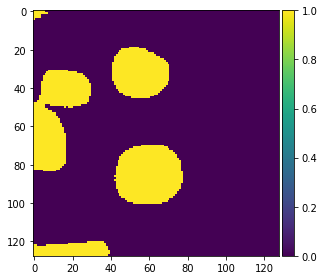

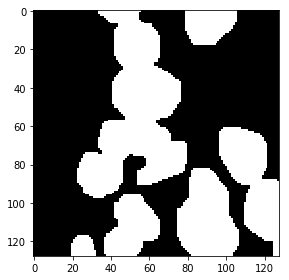

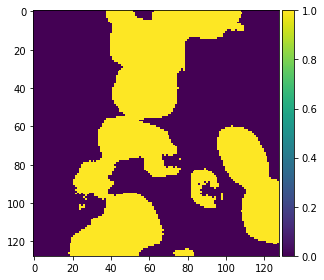

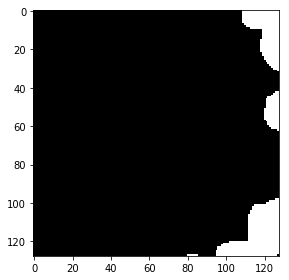

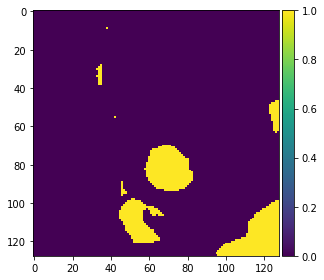

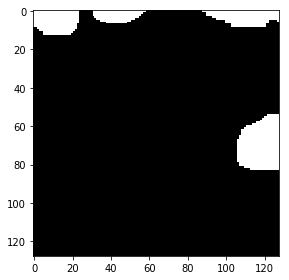

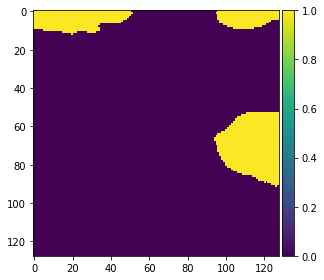

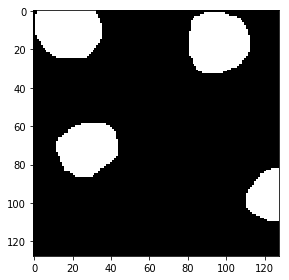

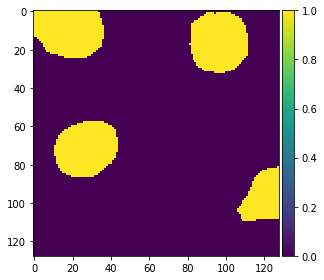

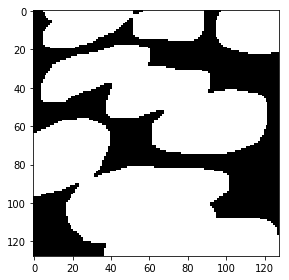

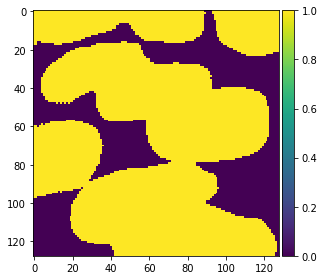

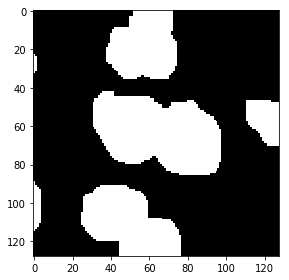

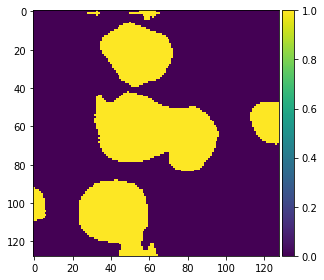

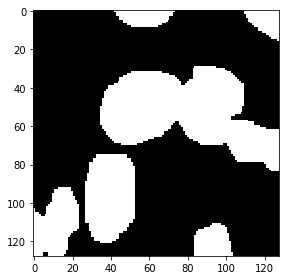

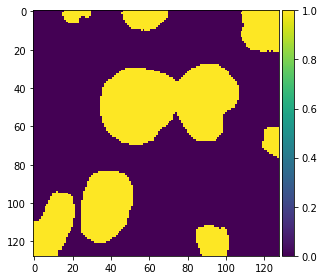

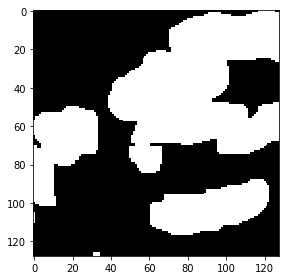

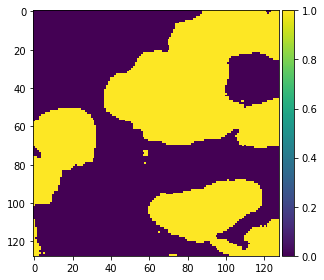

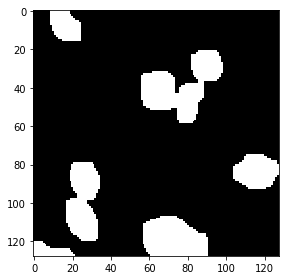

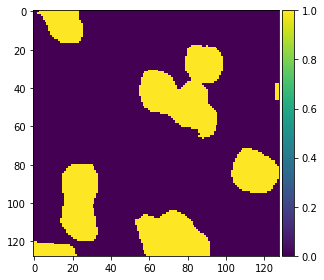

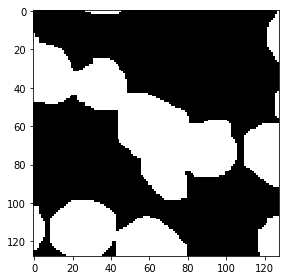

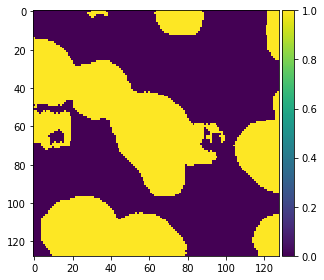

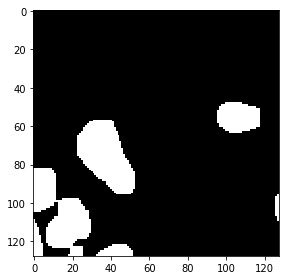

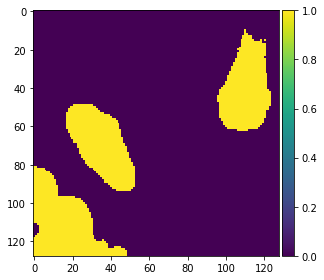

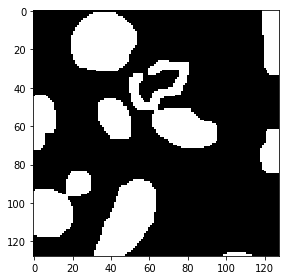

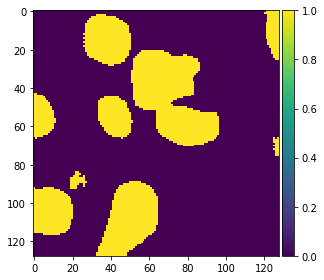

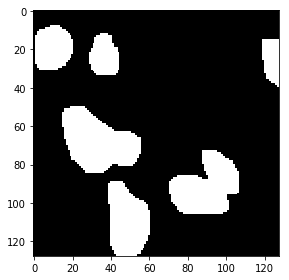

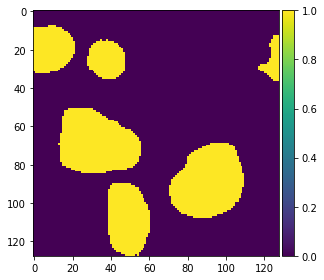

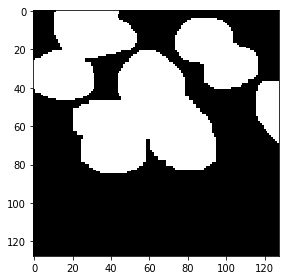

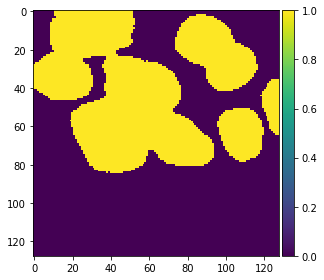

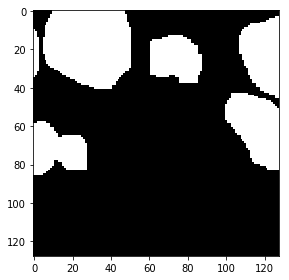

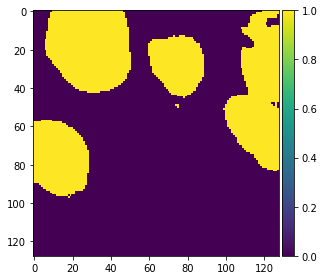

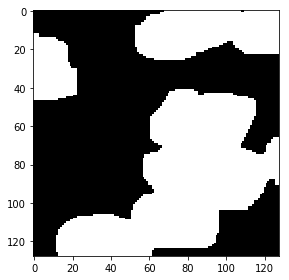

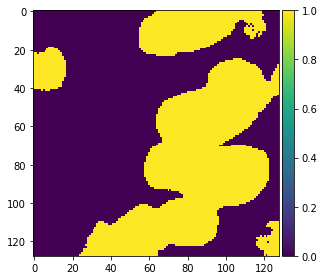

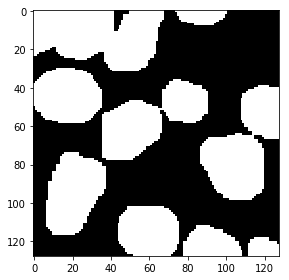

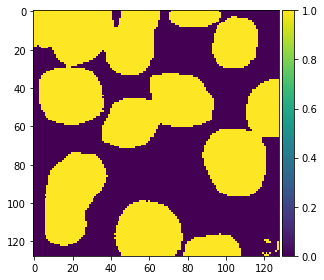

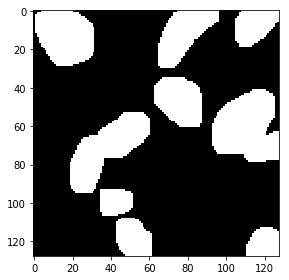

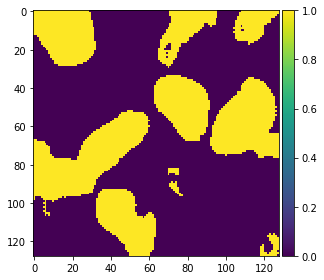

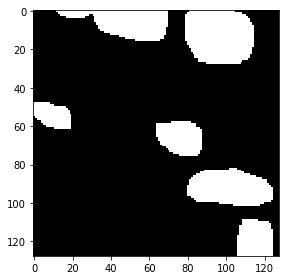

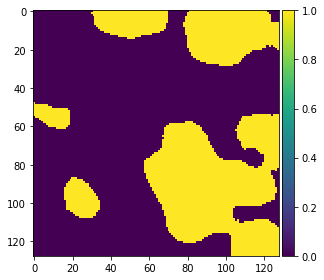

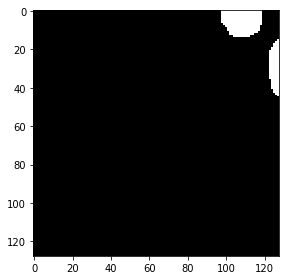

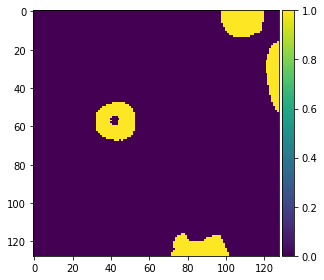

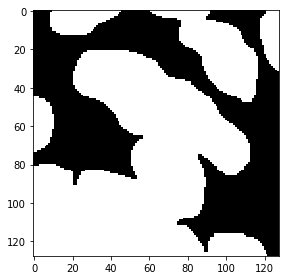

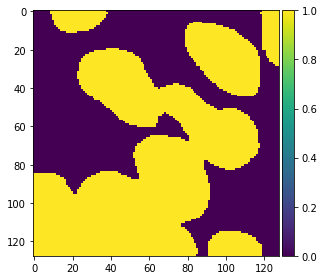

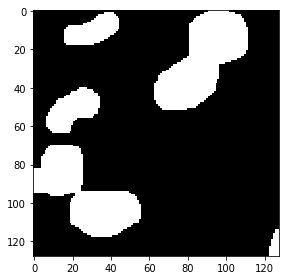

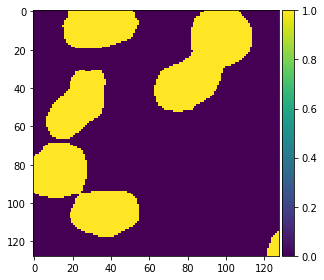

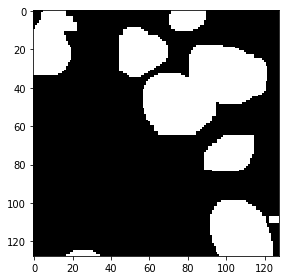

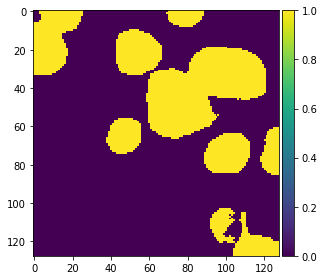

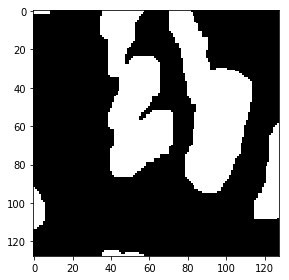

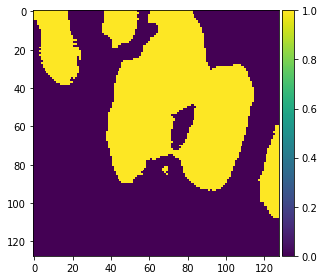

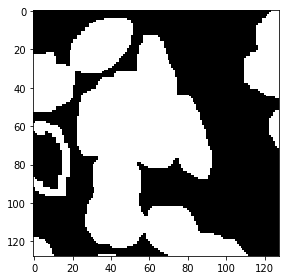

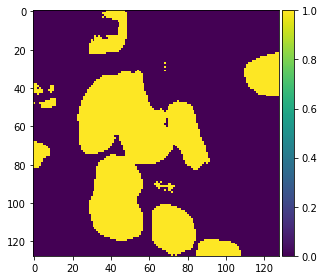

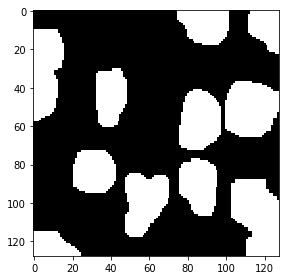

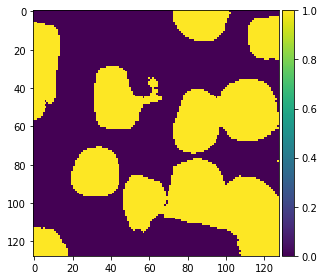

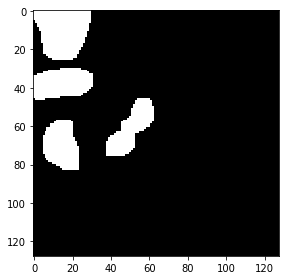

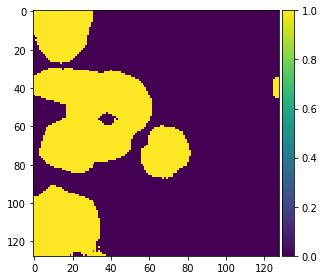

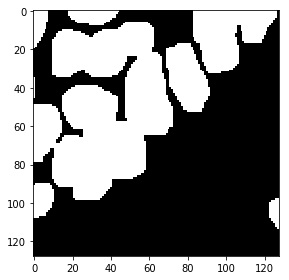

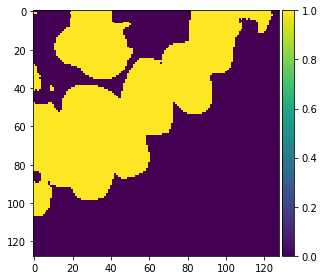

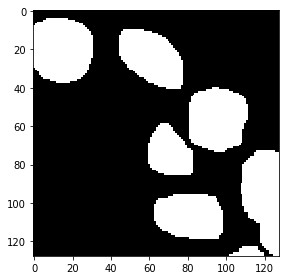

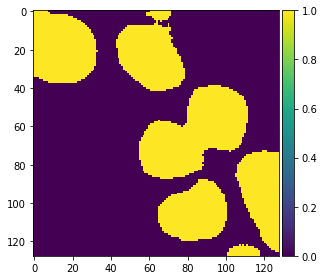

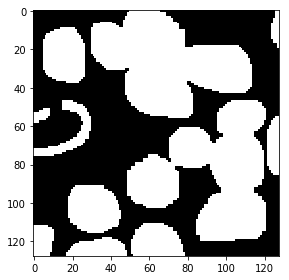

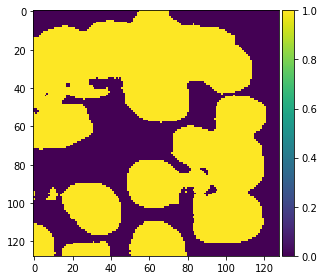

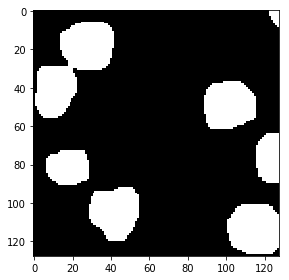

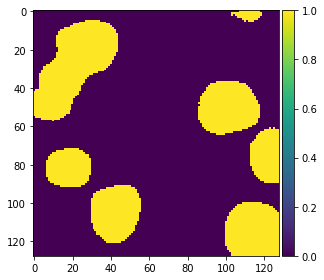

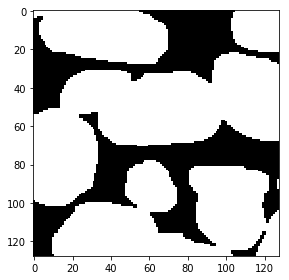

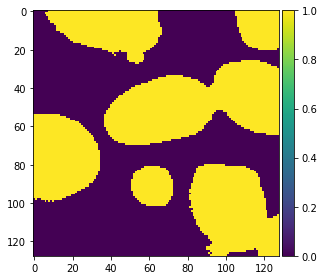

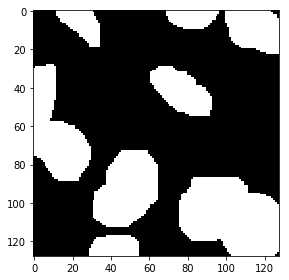

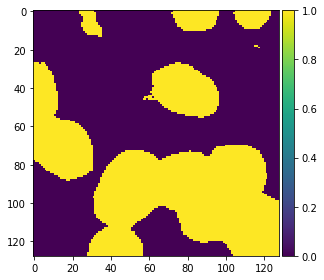

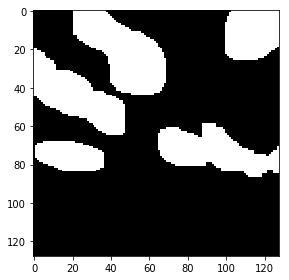

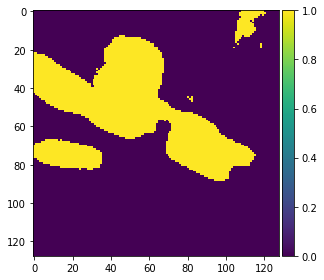

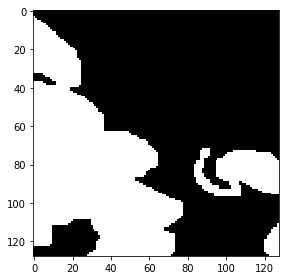

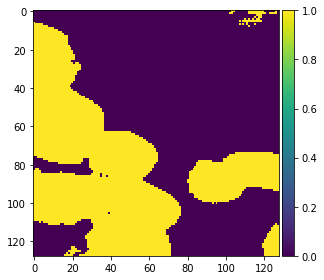

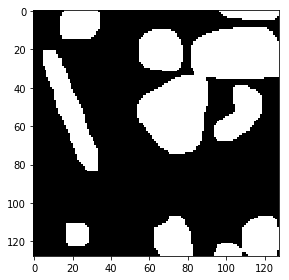

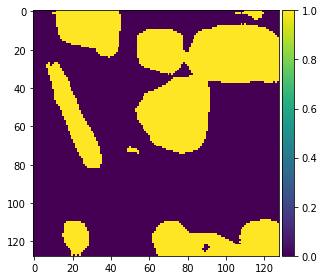

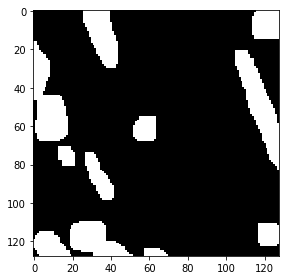

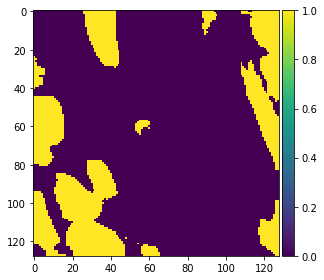

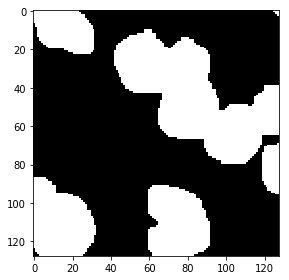

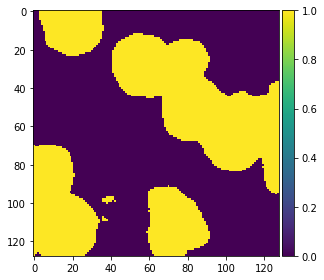

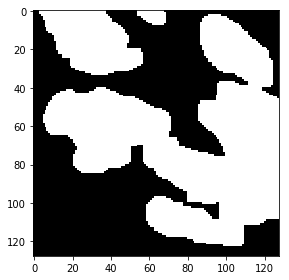

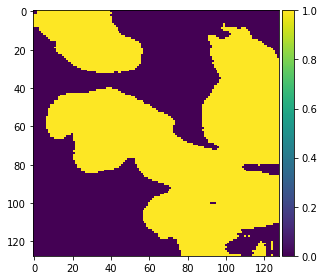

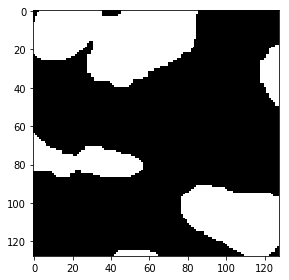

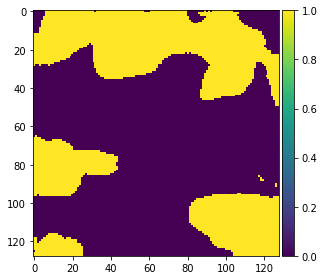

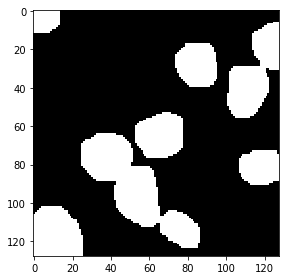

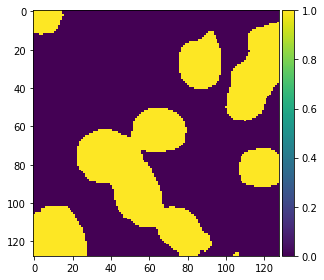

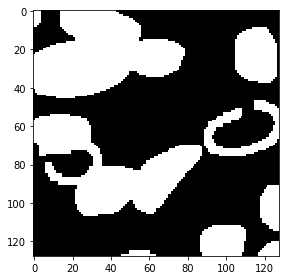

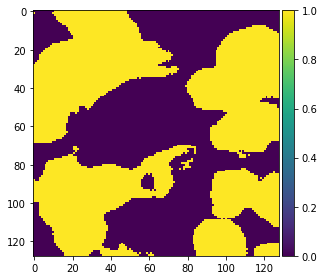

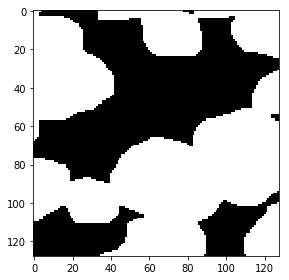

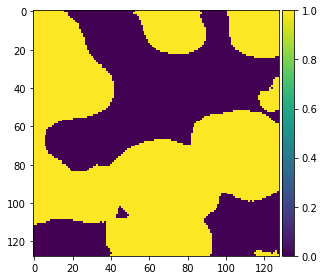

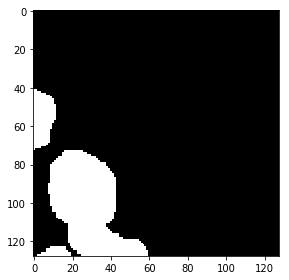

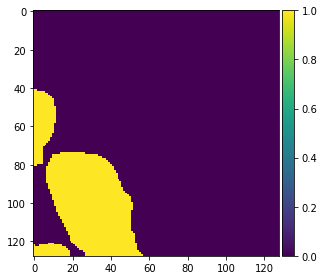

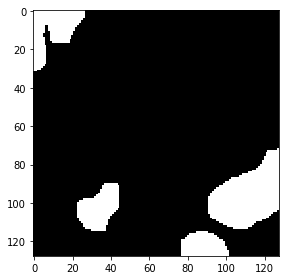

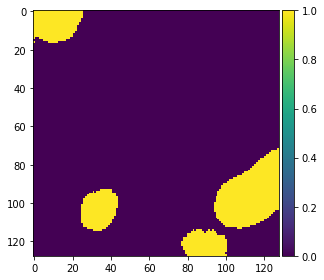

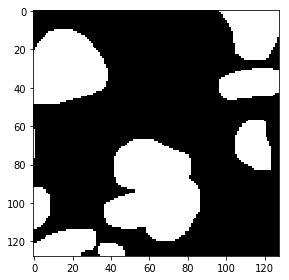

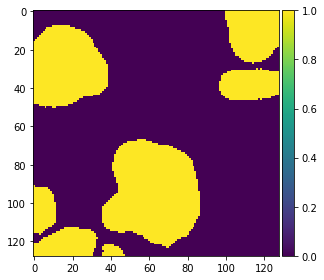

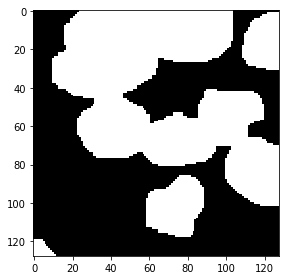

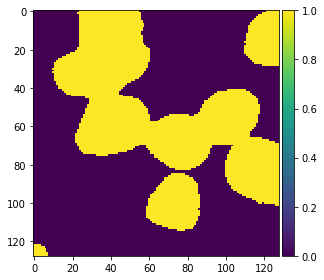

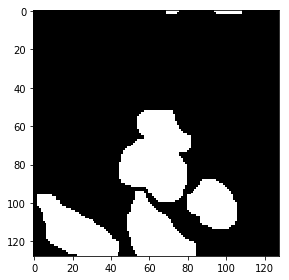

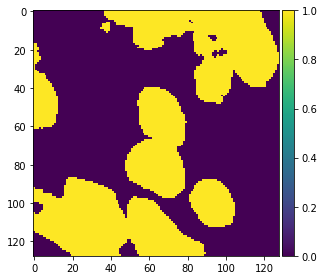

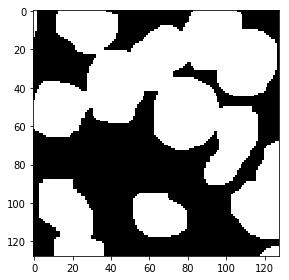

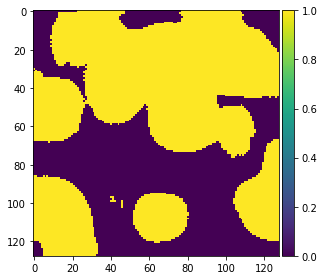

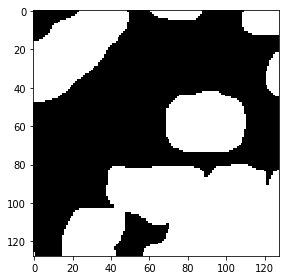

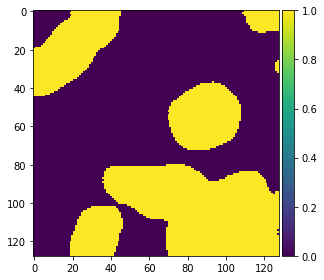

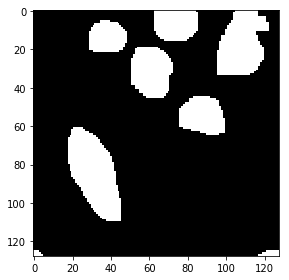

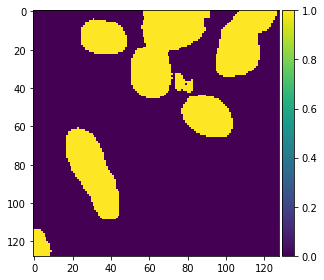

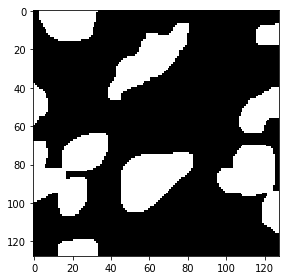

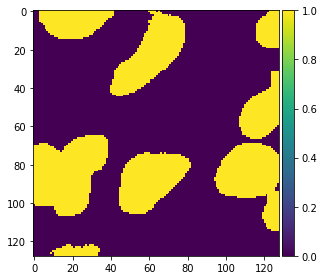

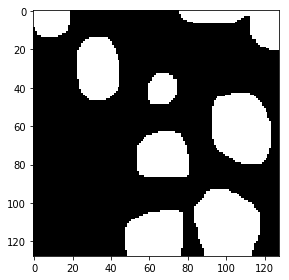

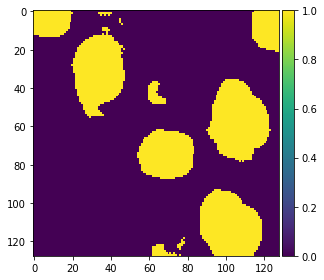

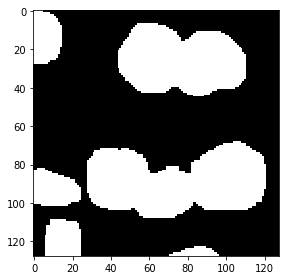

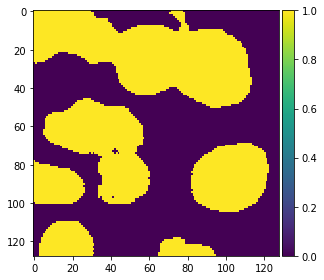

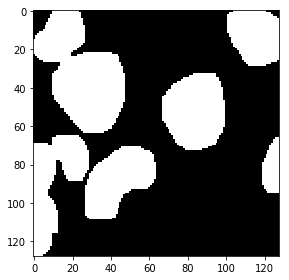

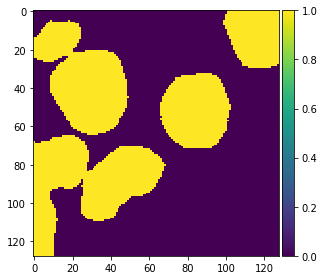

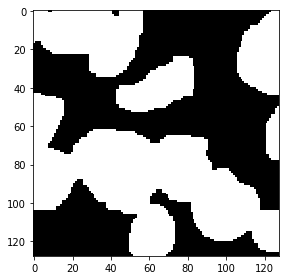

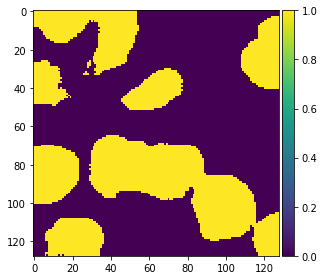

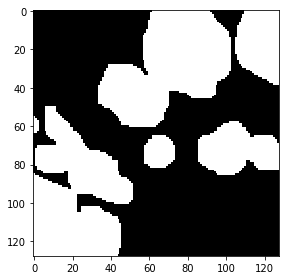

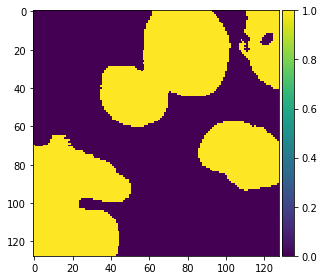

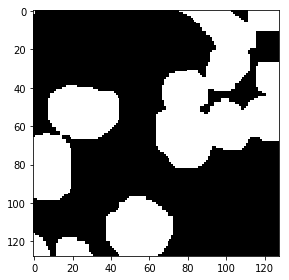

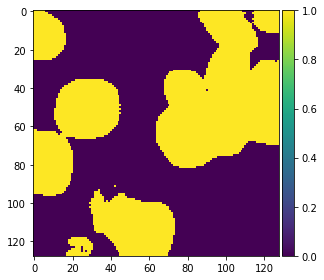

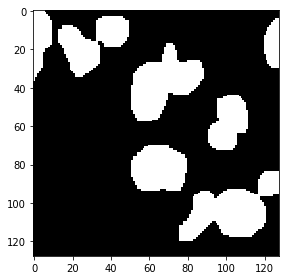

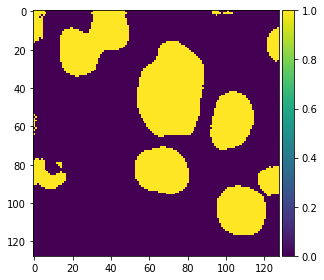

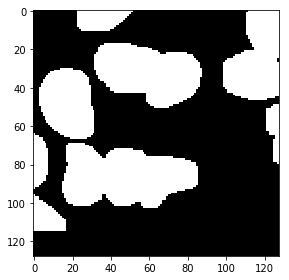

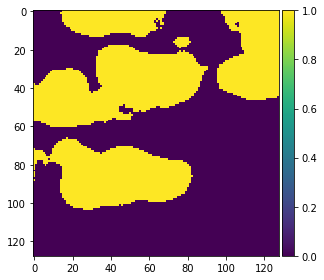

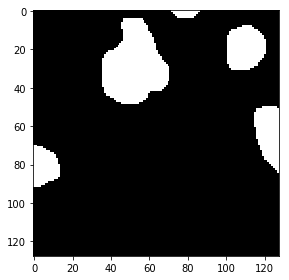

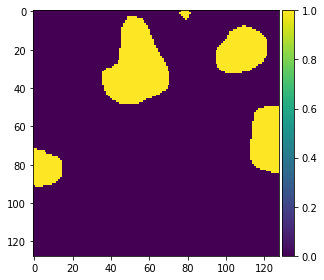

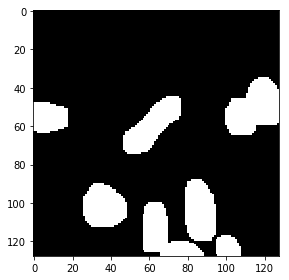

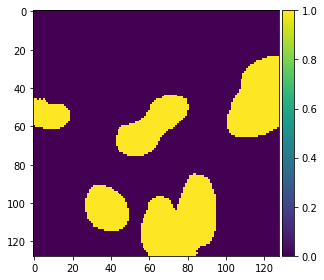

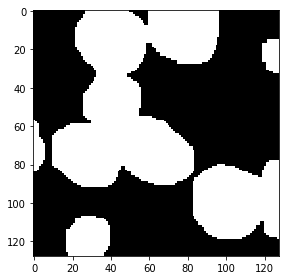

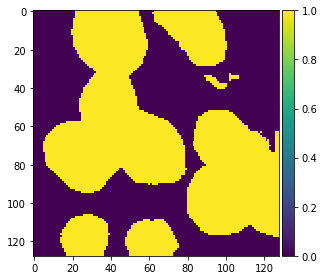

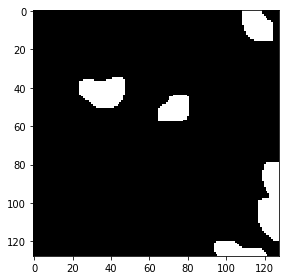

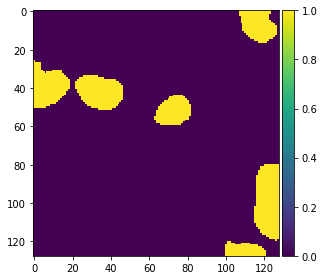

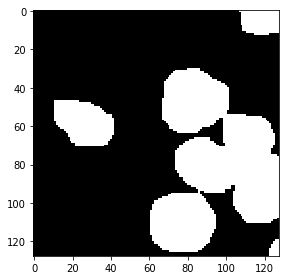

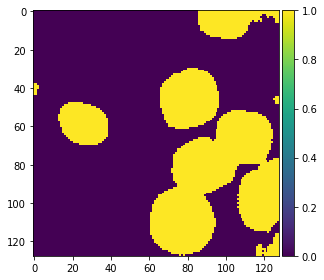

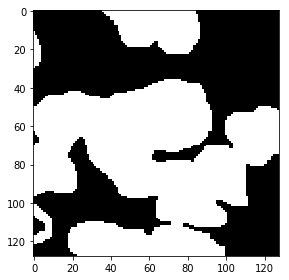

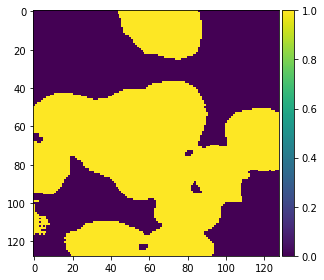

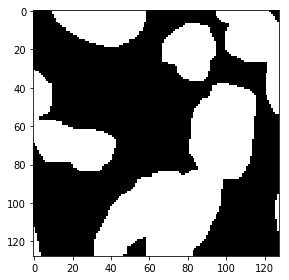

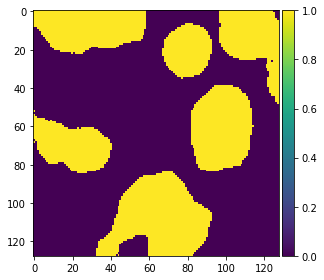

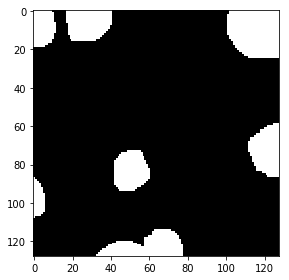

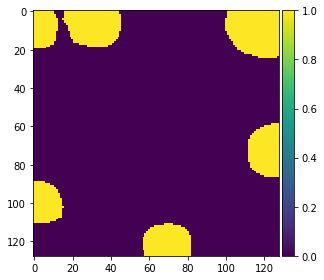

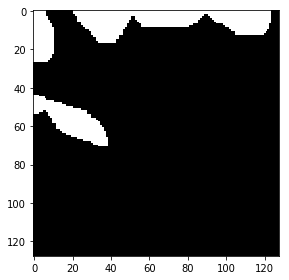

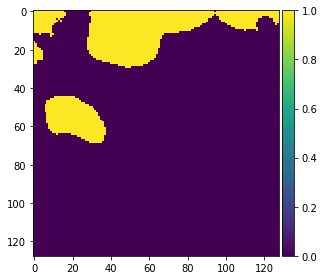

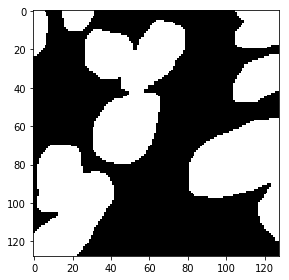

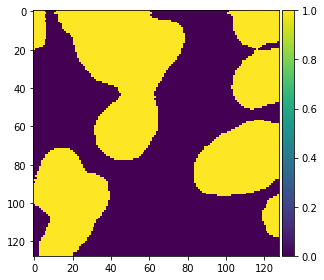

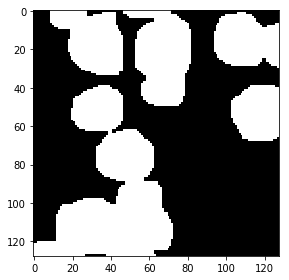

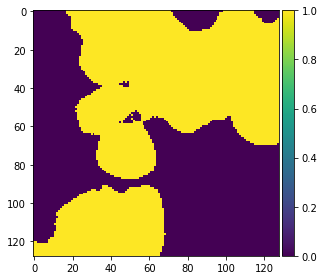

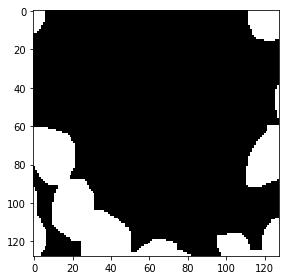

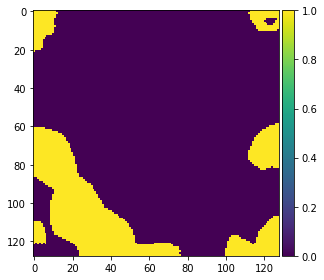

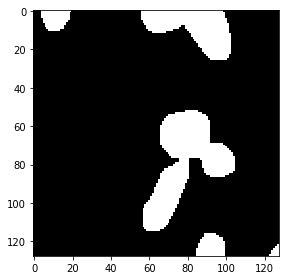

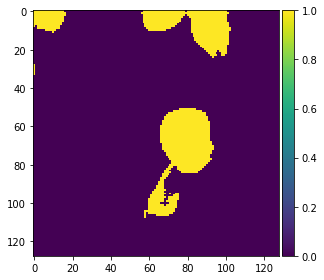

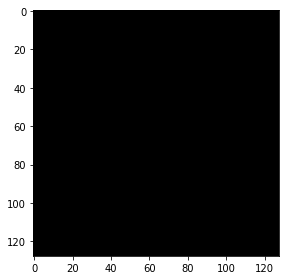

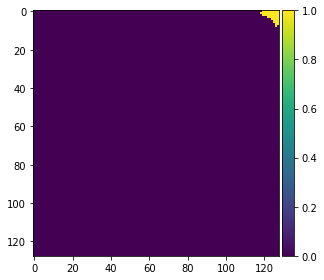

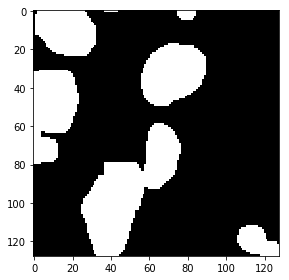

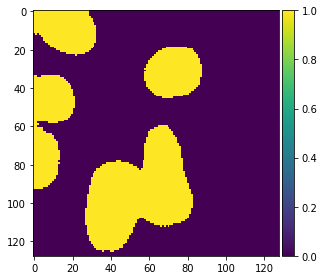

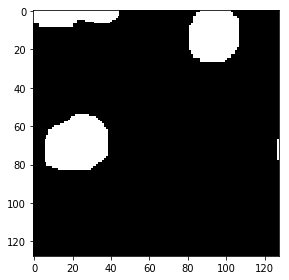

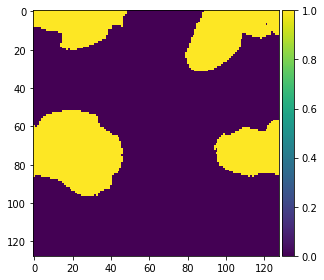

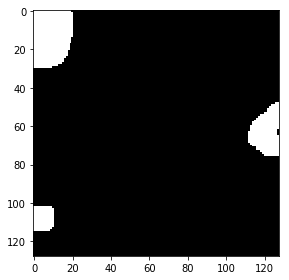

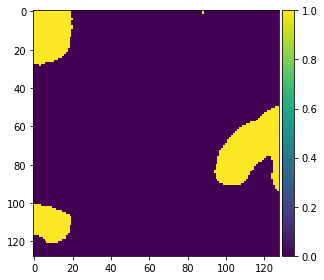

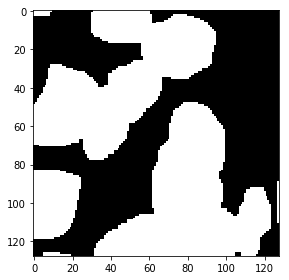

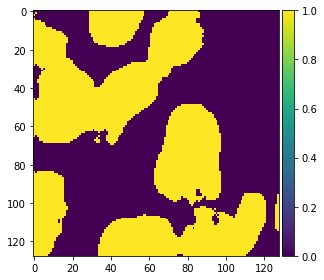

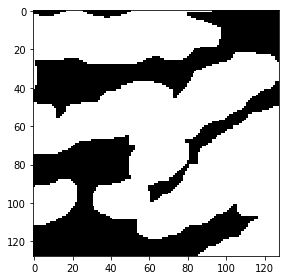

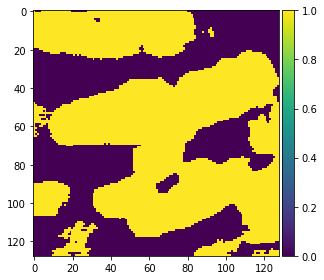

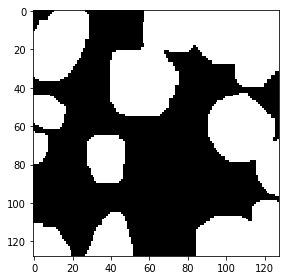

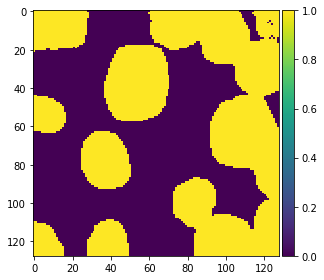

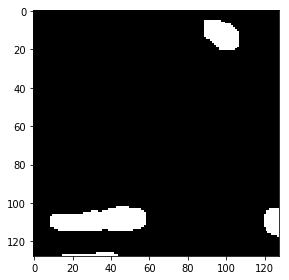

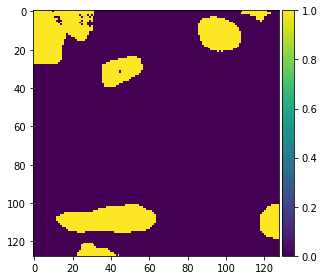

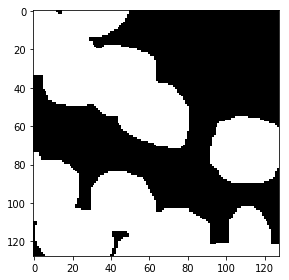

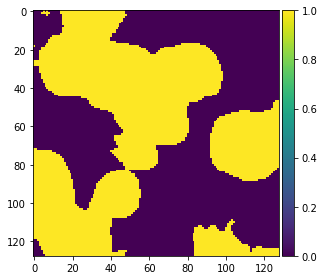

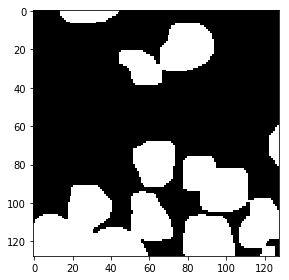

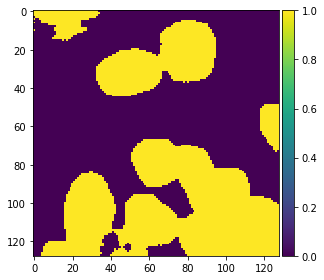

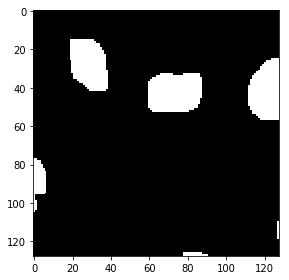

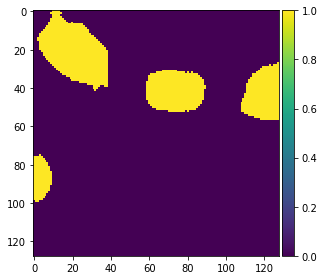

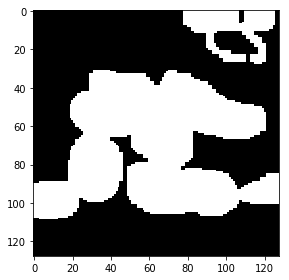

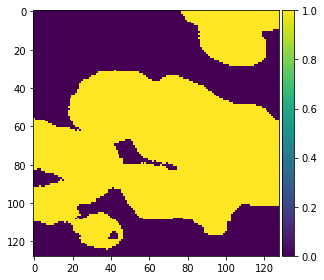

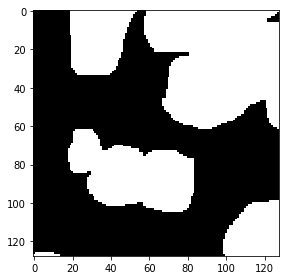

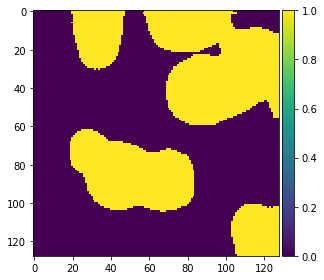

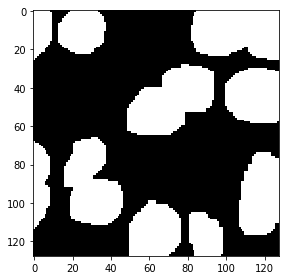

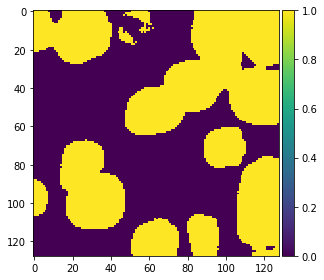

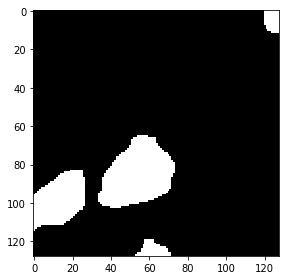

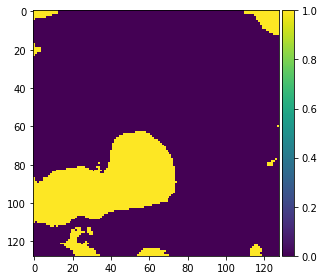

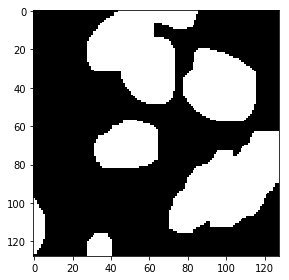

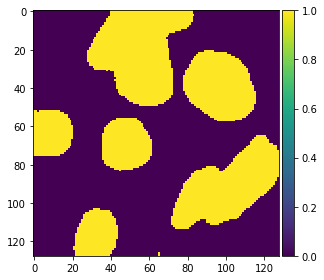

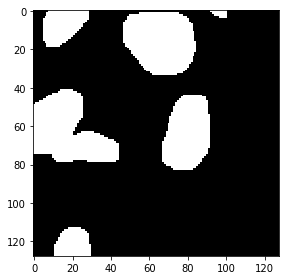

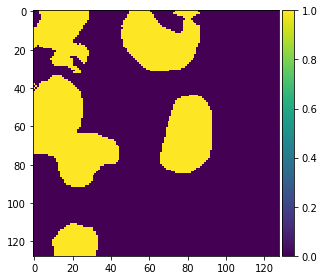

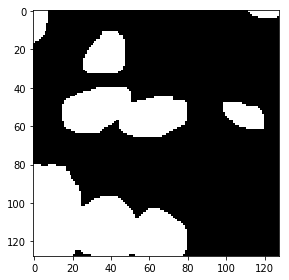

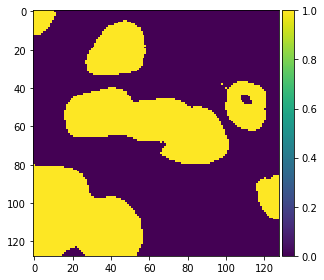

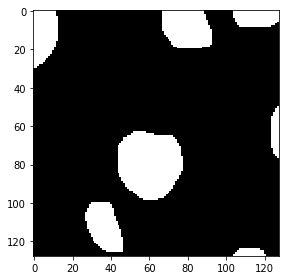

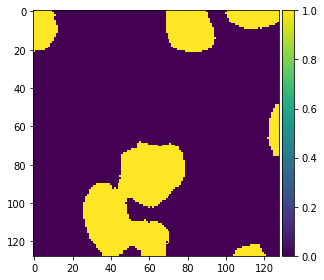

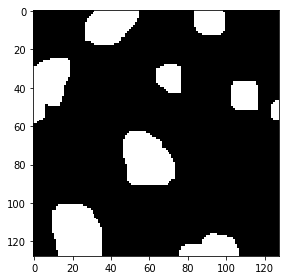

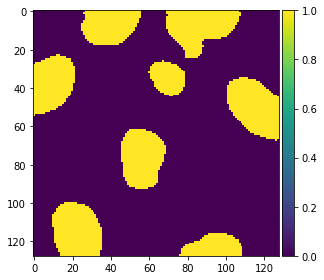

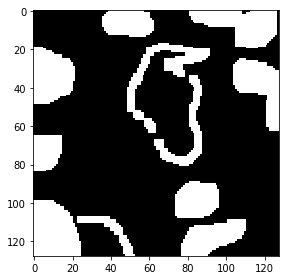

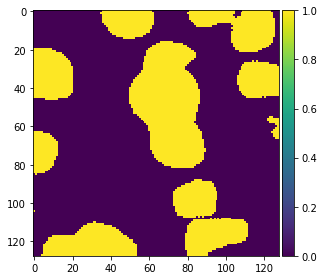

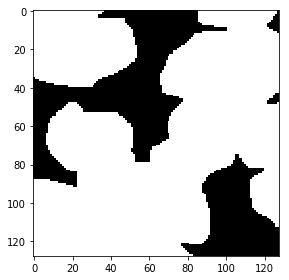

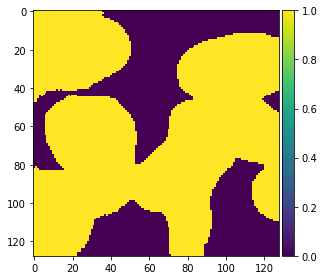

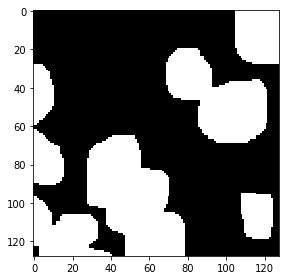

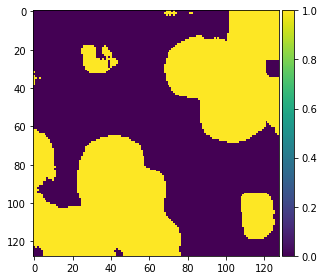

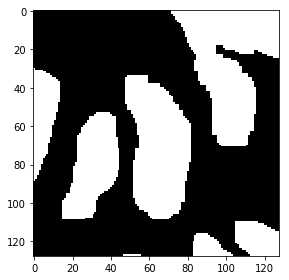

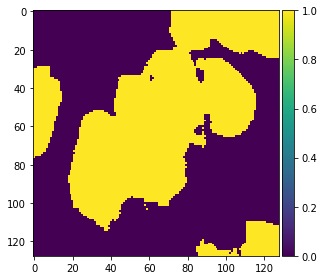

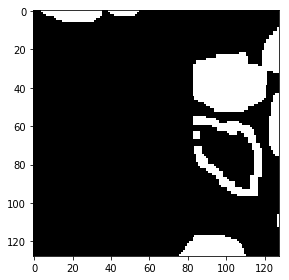

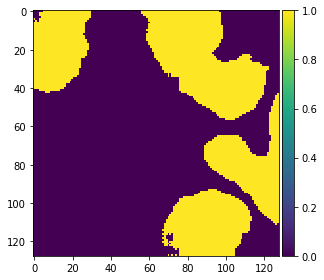

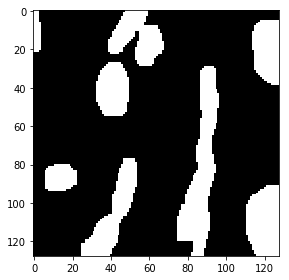

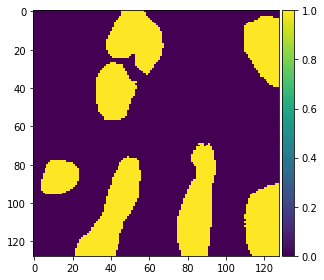

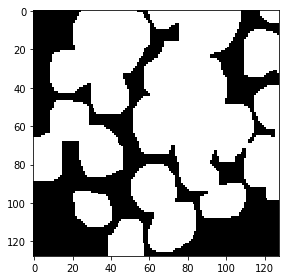

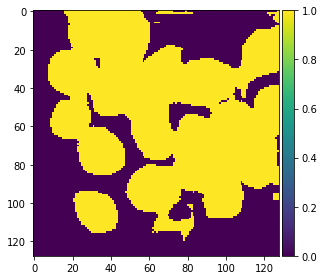

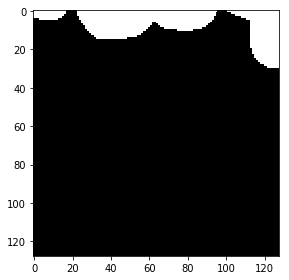

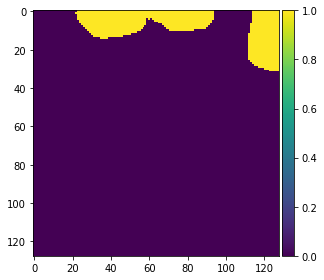

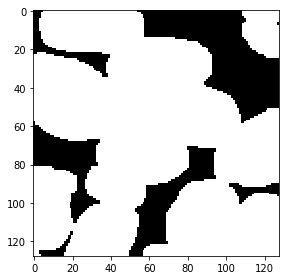

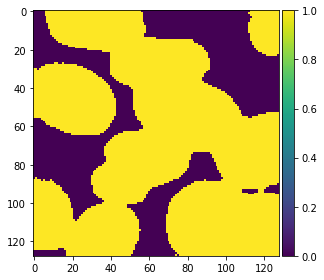

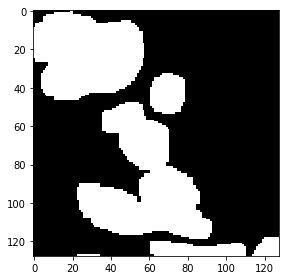

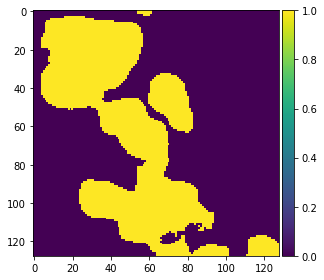

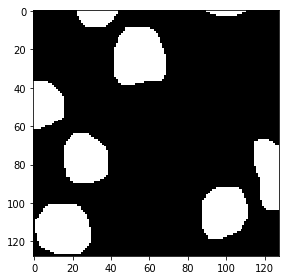

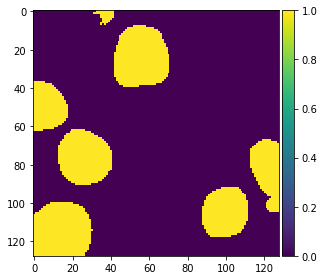

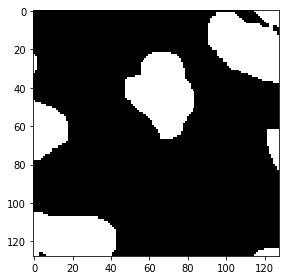

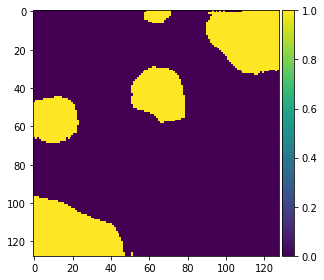

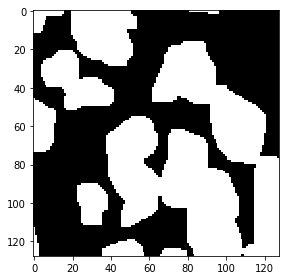

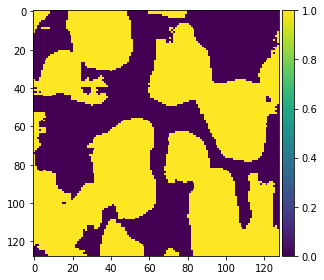

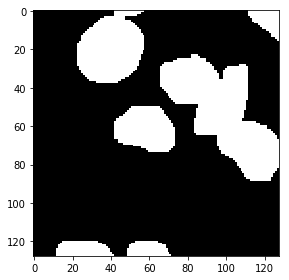

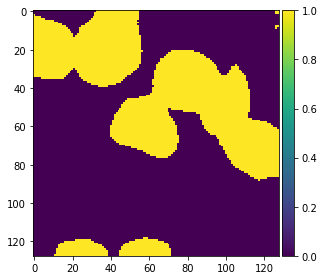

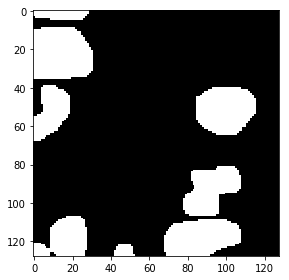

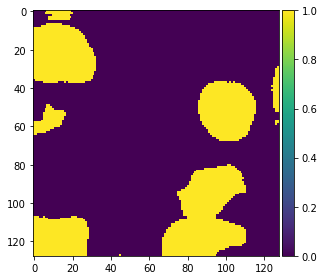

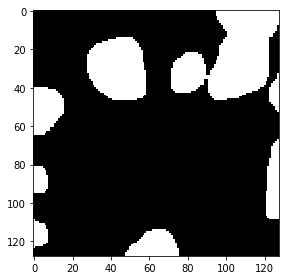

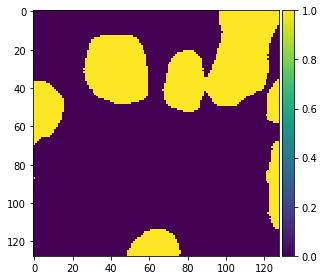

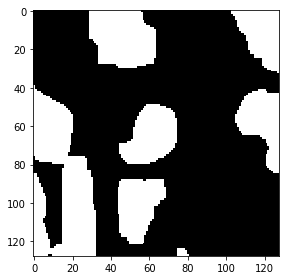

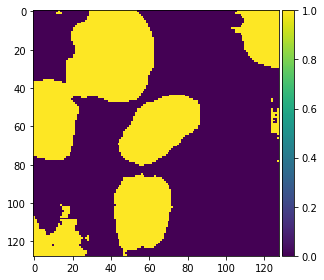

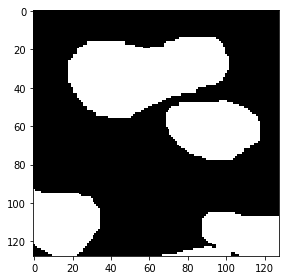

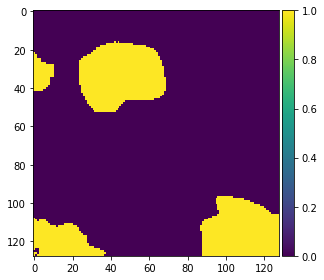

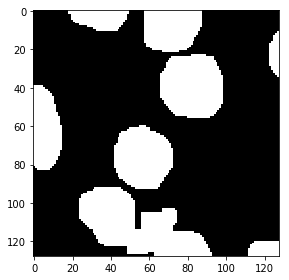

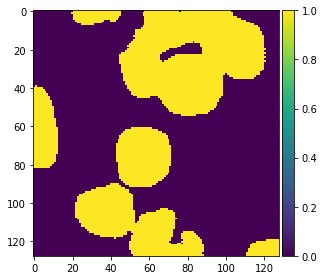

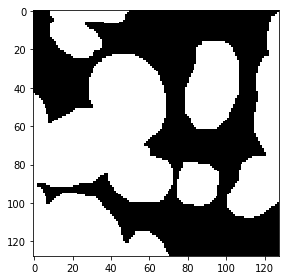

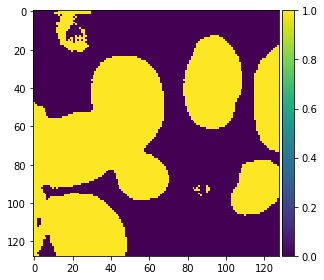

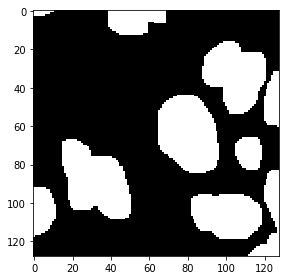

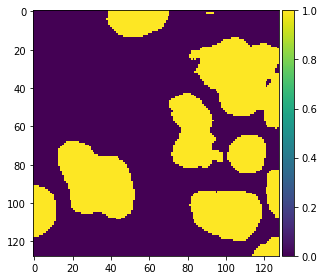

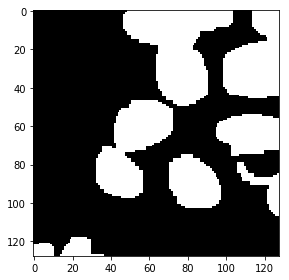

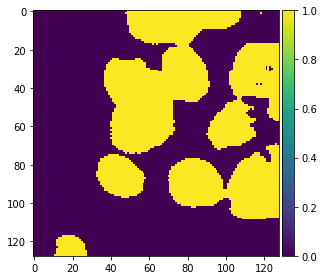

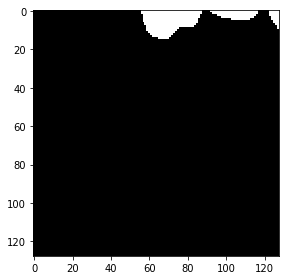

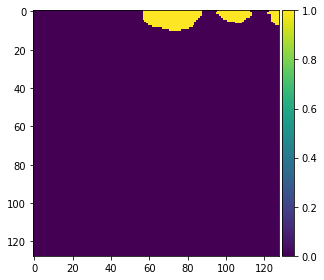

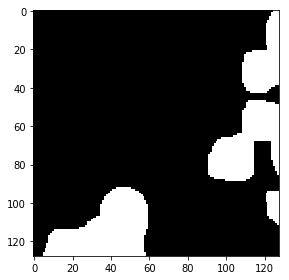

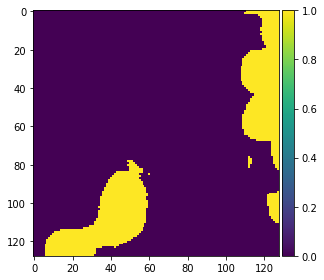

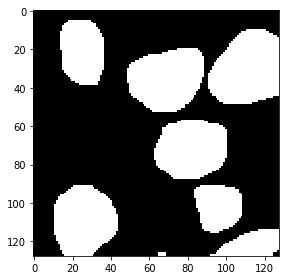

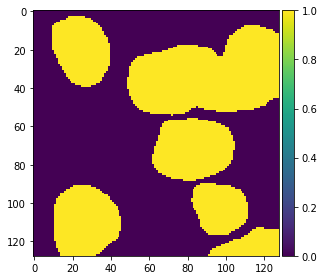

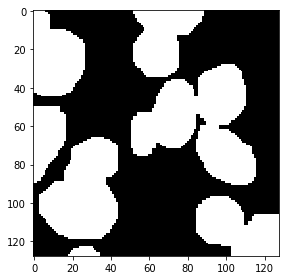

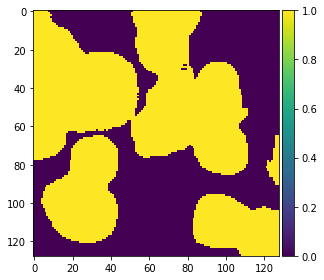

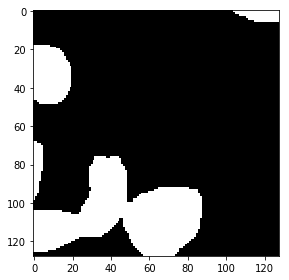

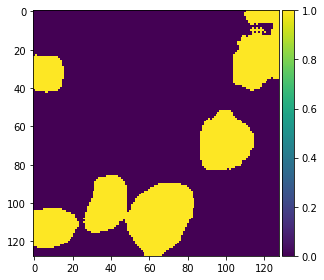

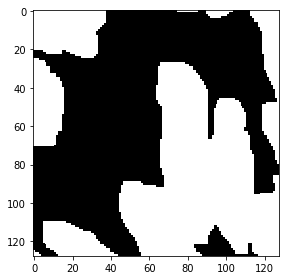

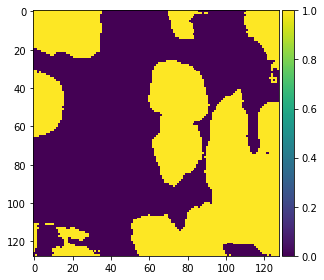

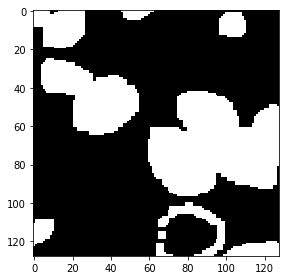

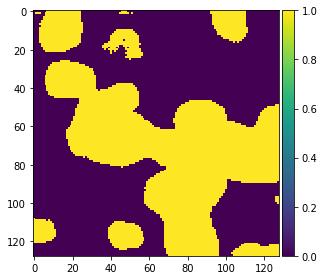

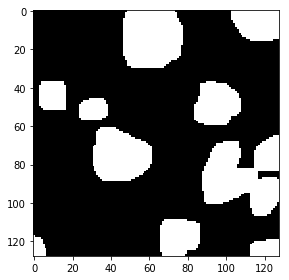

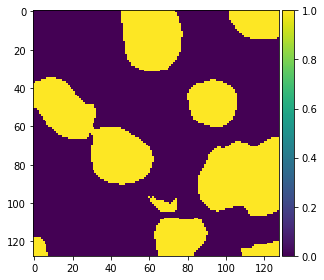

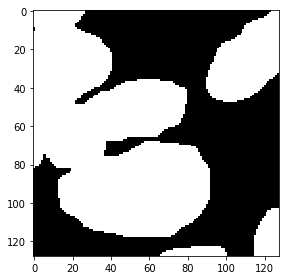

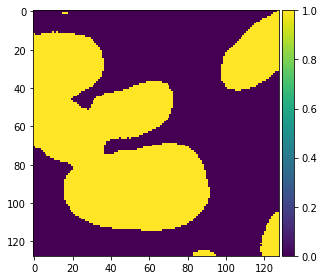

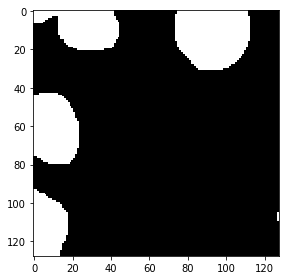

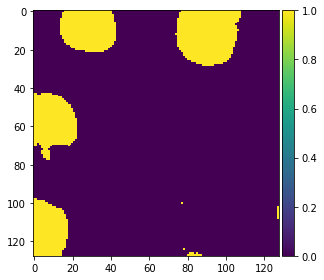

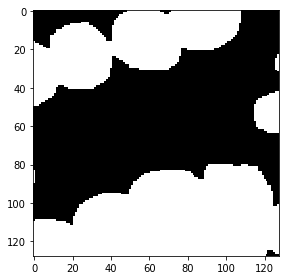

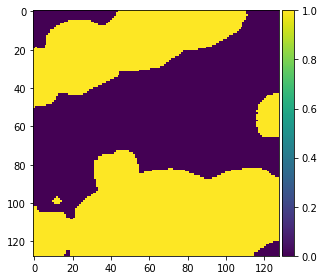

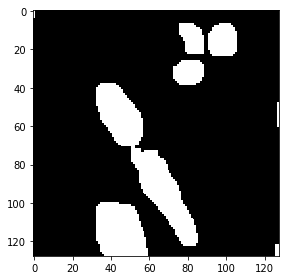

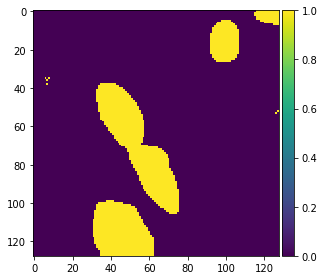

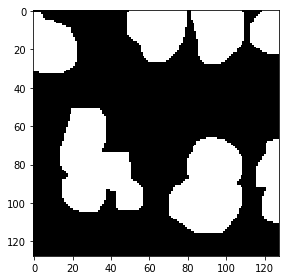

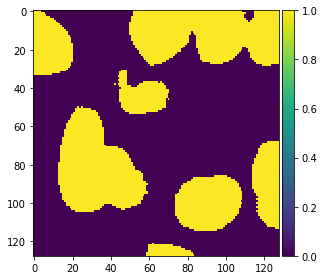

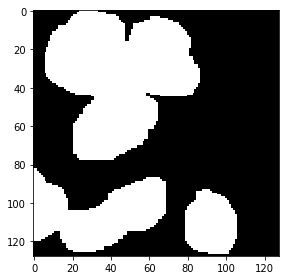

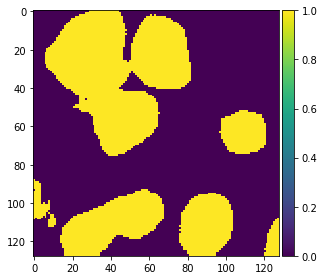

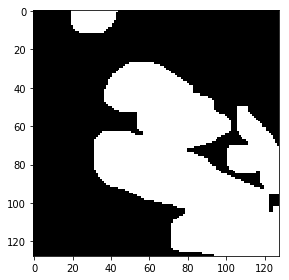

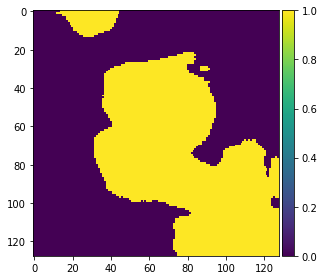

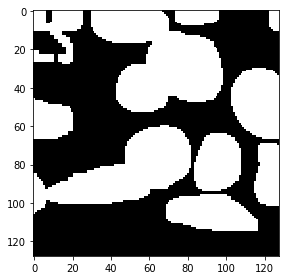

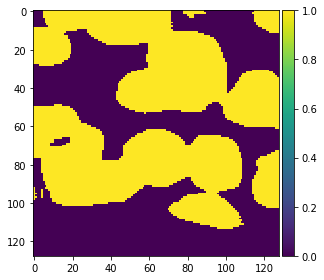

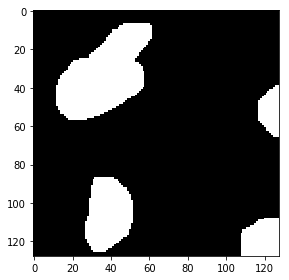

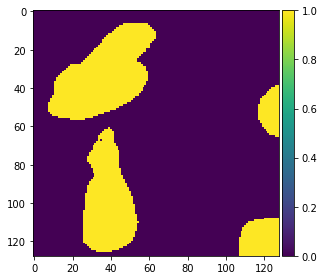

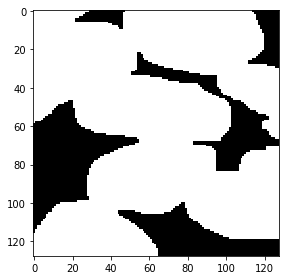

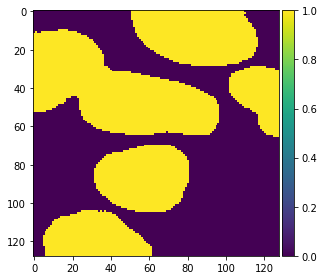

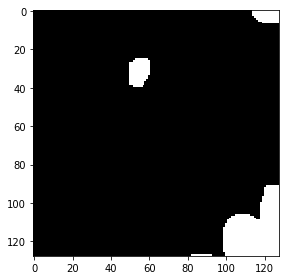

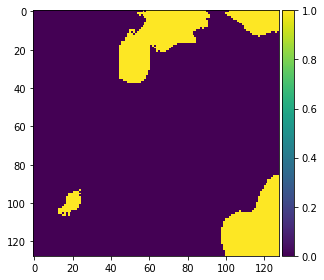

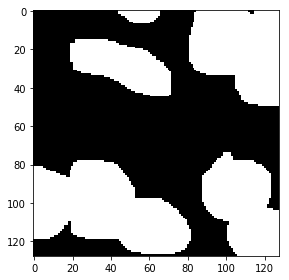

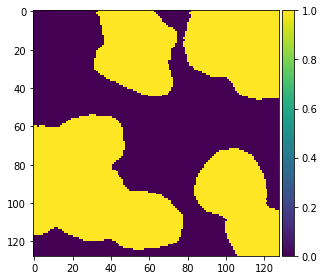

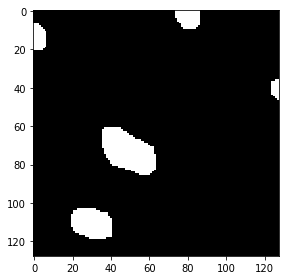

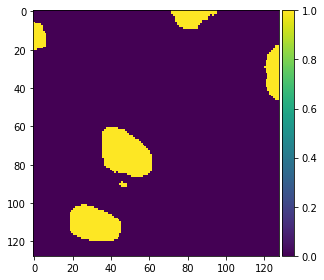

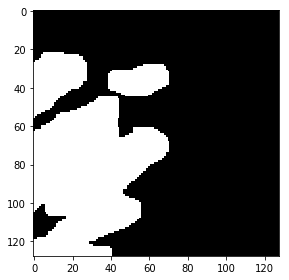

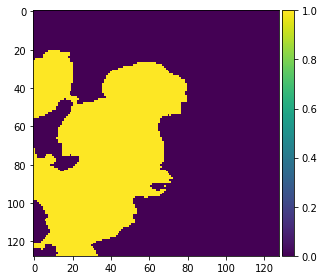

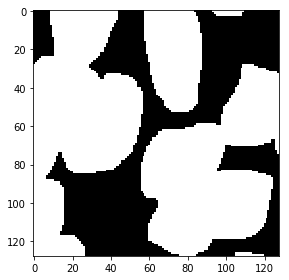

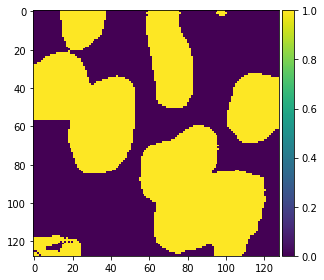

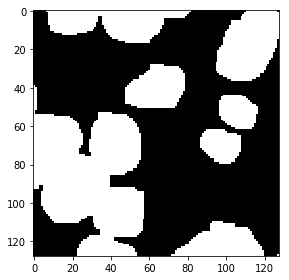

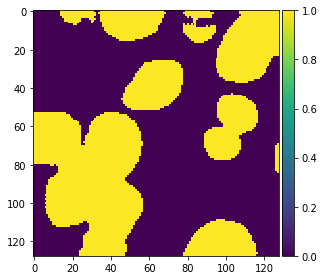

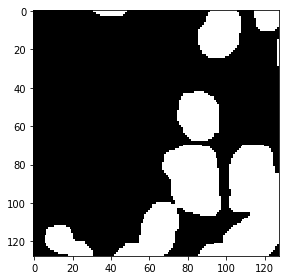

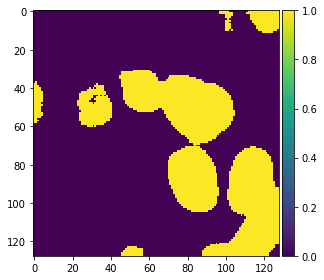

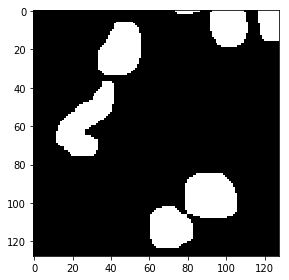

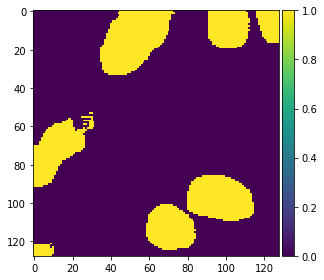

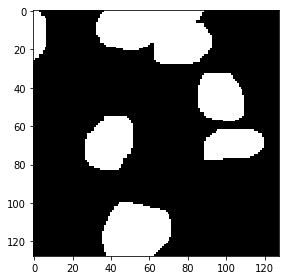

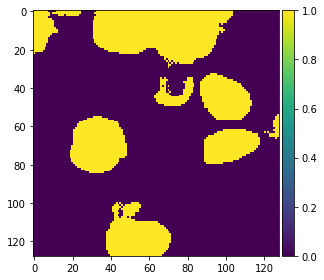

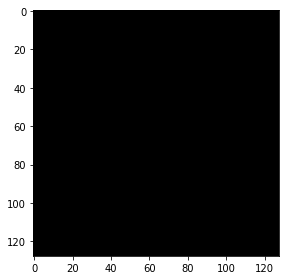

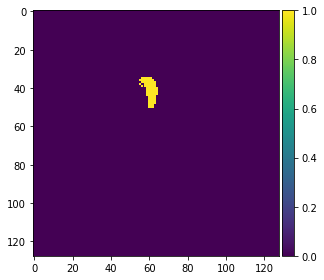

In [142]:
# Perform a sanity check on some random validation samples
ix = random.randint(0, len(preds_val_t))
imshow(X_train[int(X_train.shape[0]*0.9):][ix])
plt.show()
imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
plt.show()
imshow(np.squeeze(preds_val_t[ix]))
plt.show()
for ix in range(0,len(preds_val_t) -1):
    #imshow(X_train[int(X_train.shape[0]*0.9):][ix])
    #plt.show()
    imshow(np.squeeze(Y_train[int(Y_train.shape[0]*0.9):][ix]))
    plt.show()
    imshow(np.squeeze(preds_val_t[ix]))
    plt.show()

/usr/local/lib/python3.6/site-packages/skimage/io/_plugins/matplotlib_plugin.py:51: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  out_of_range_float = (np.issubdtype(image.dtype, np.float) and


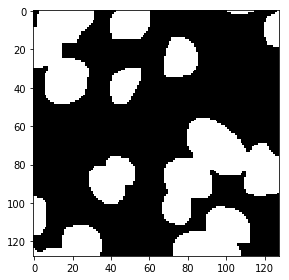

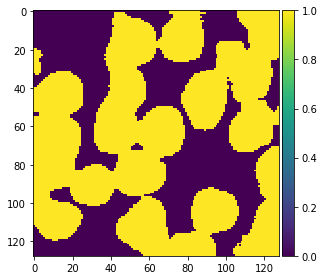

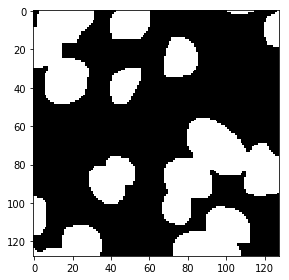

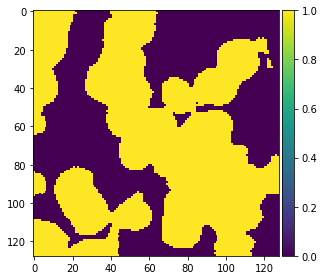

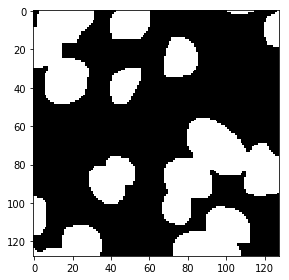

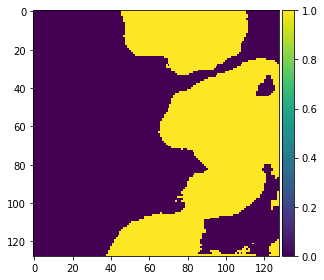

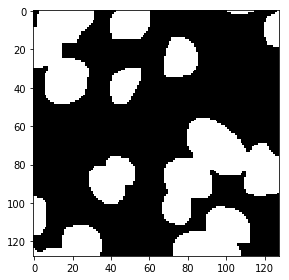

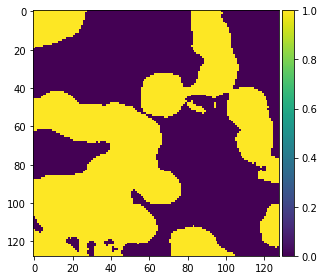

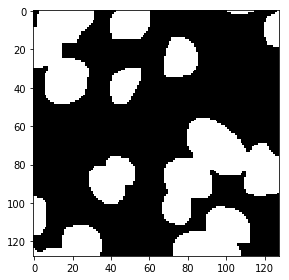

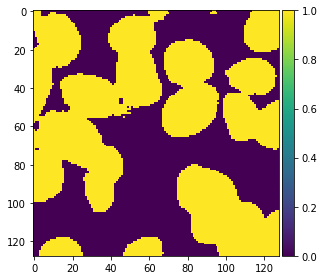

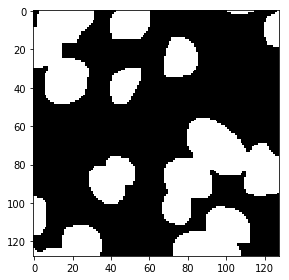

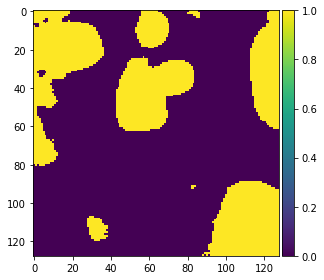

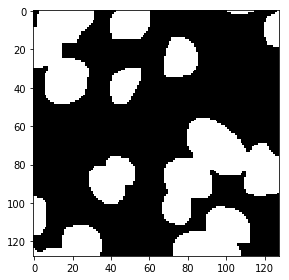

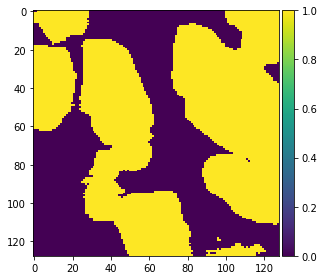

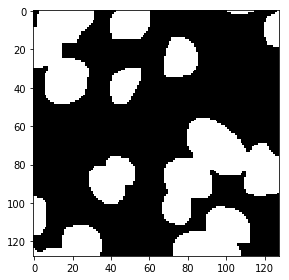

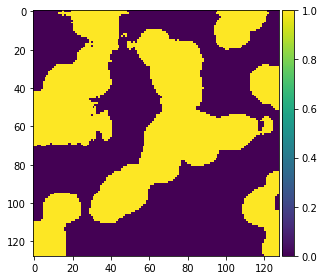

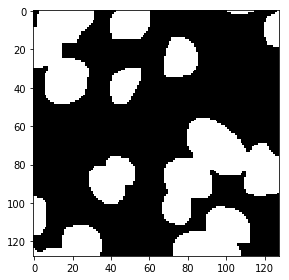

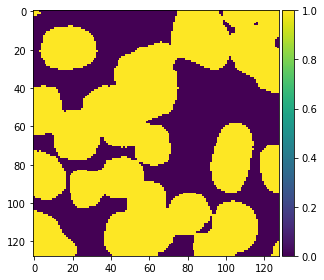

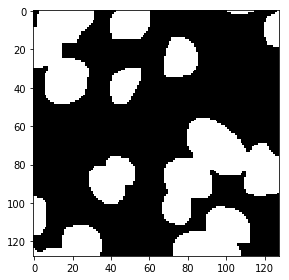

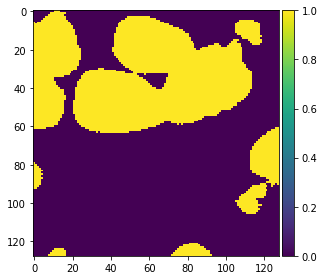

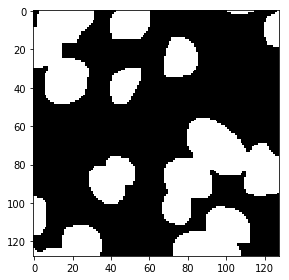

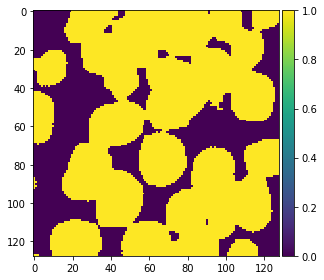

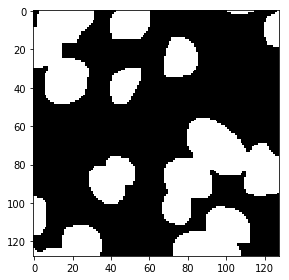

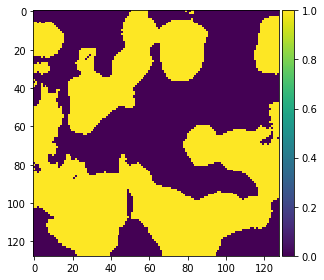

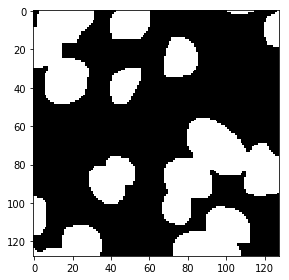

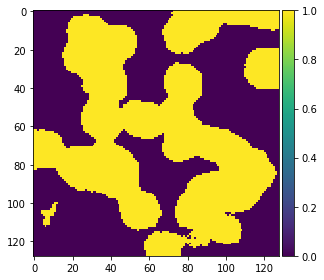

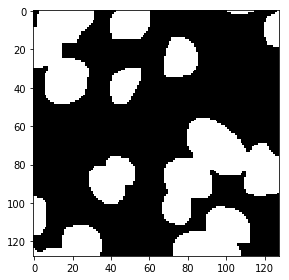

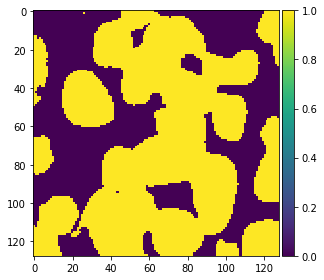

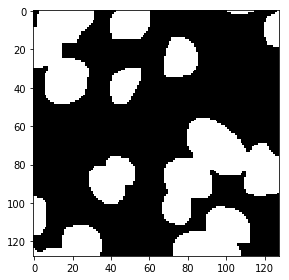

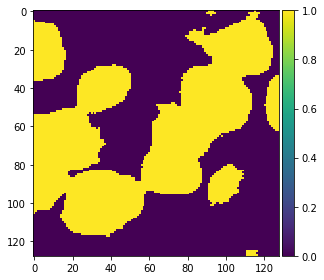

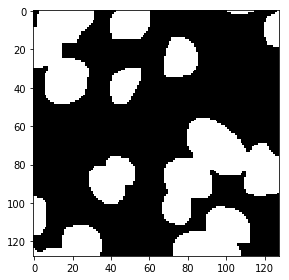

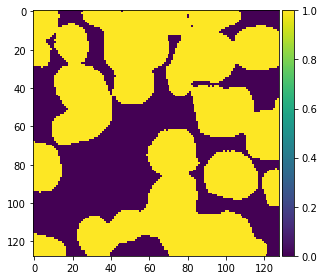

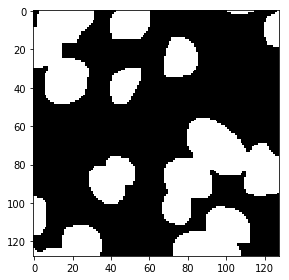

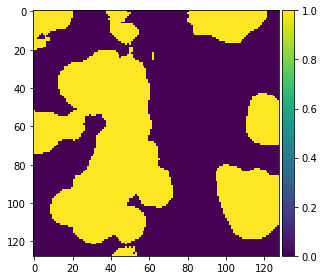

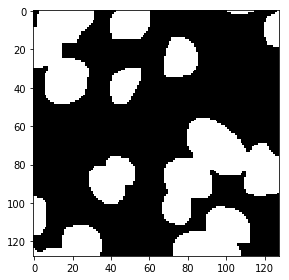

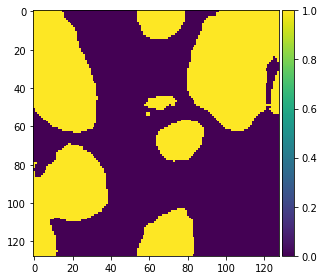

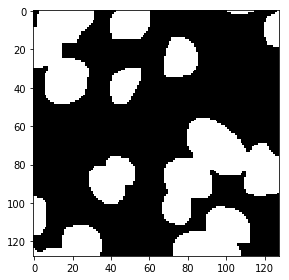

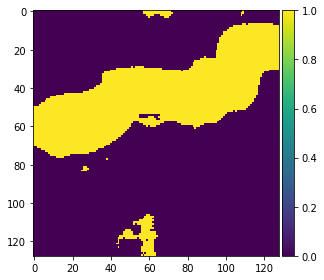

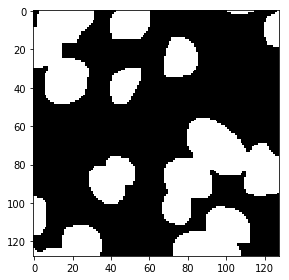

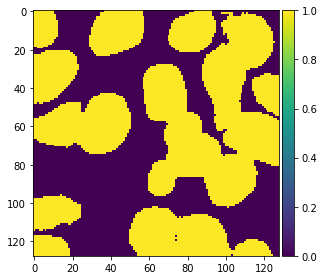

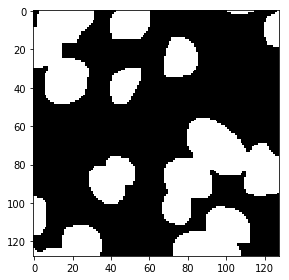

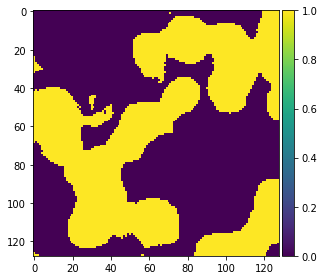

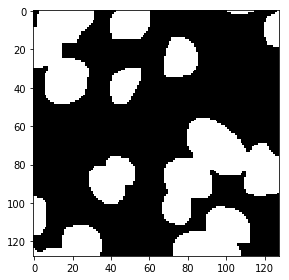

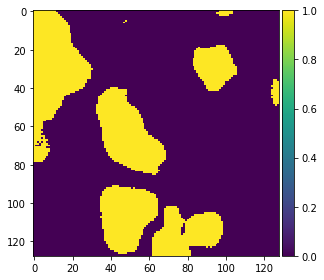

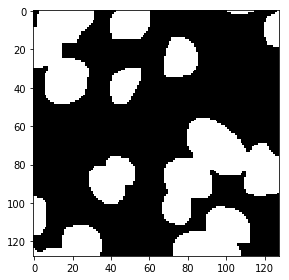

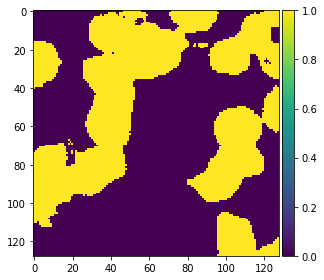

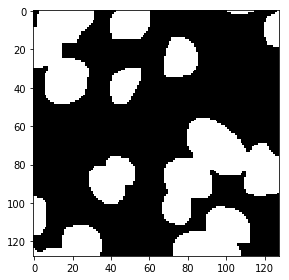

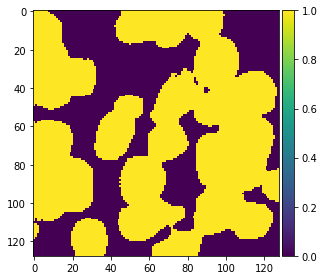

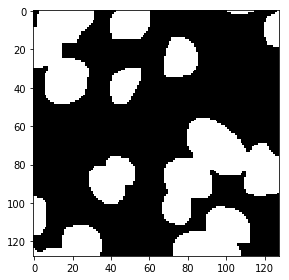

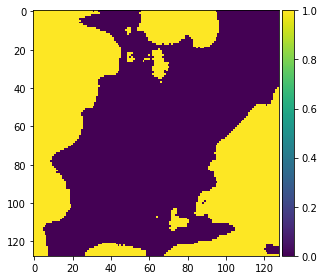

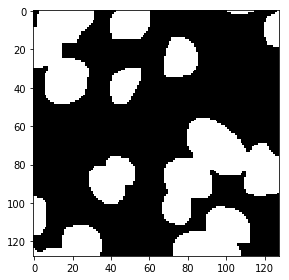

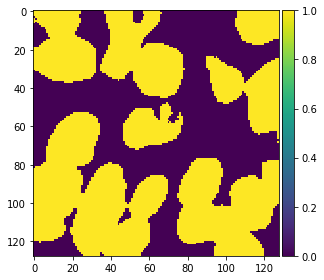

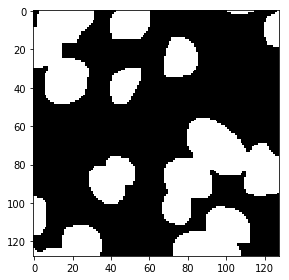

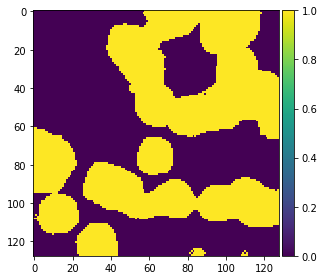

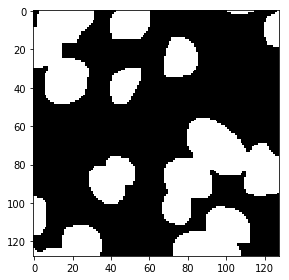

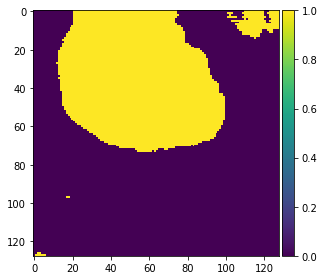

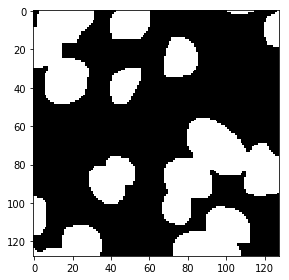

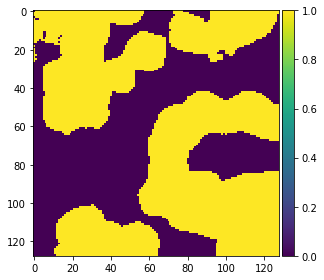

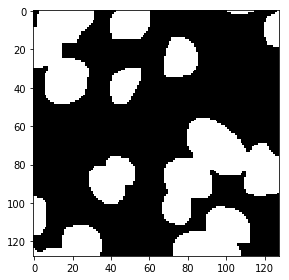

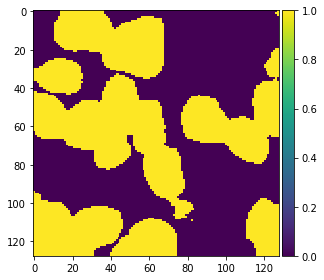

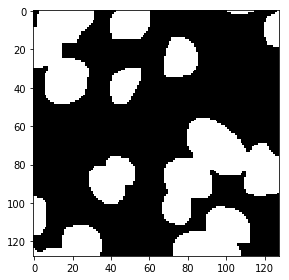

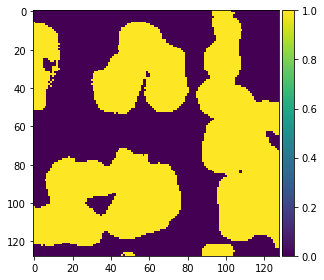

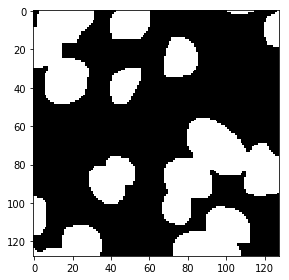

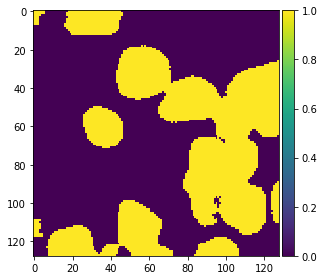

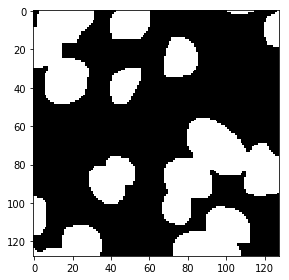

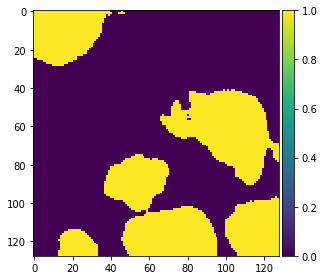

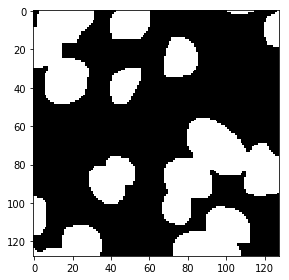

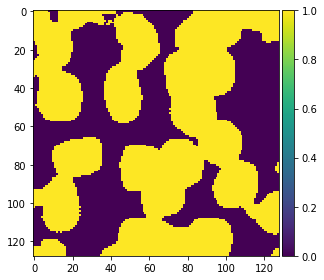

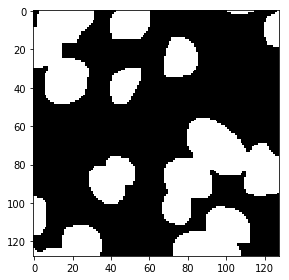

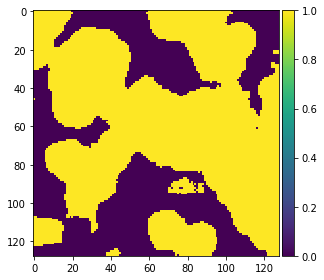

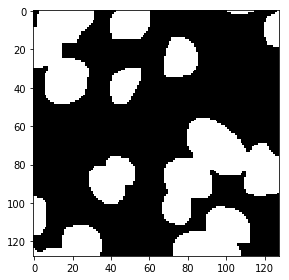

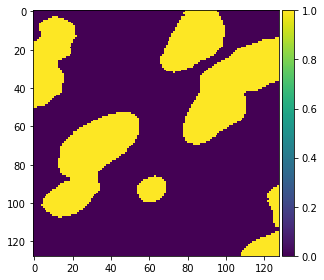

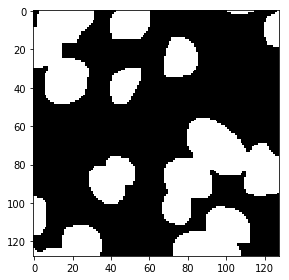

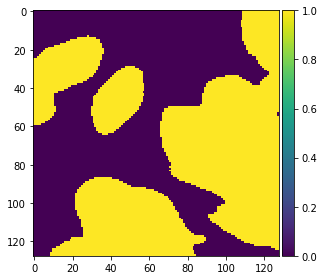

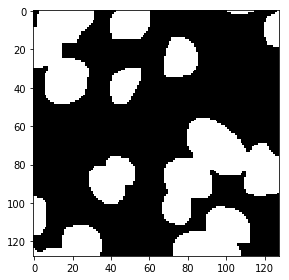

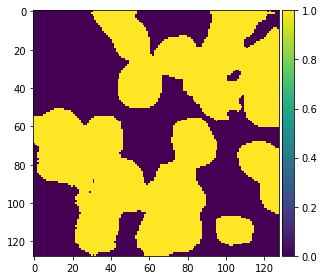

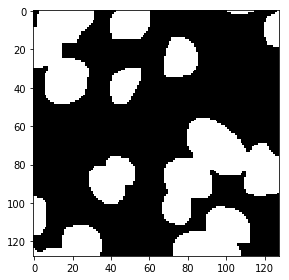

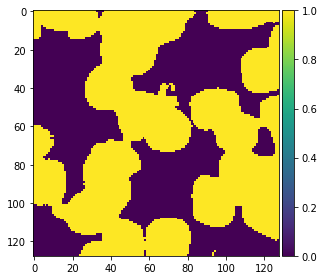

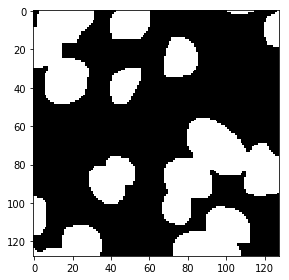

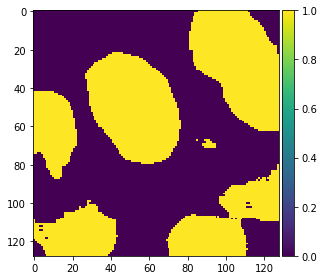

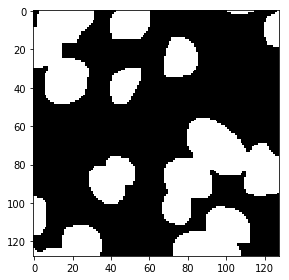

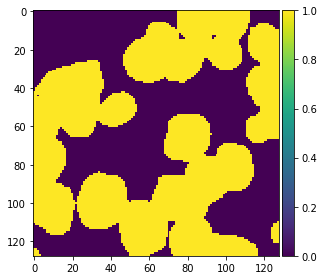

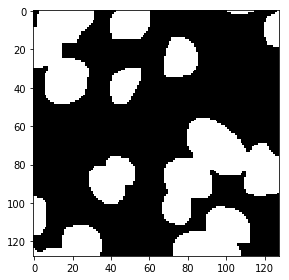

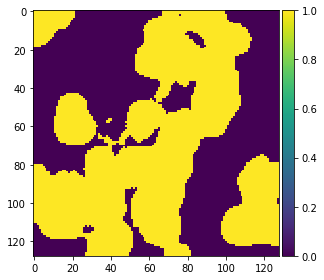

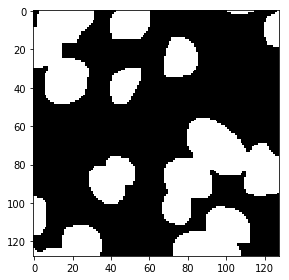

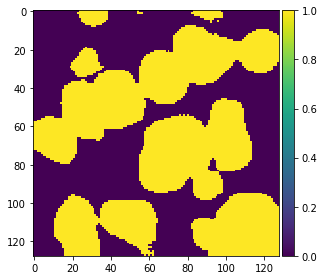

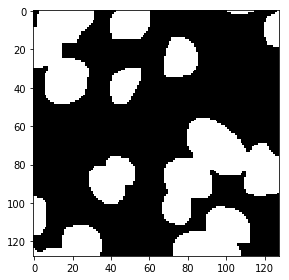

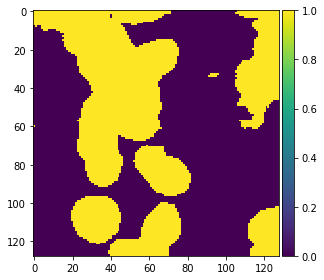

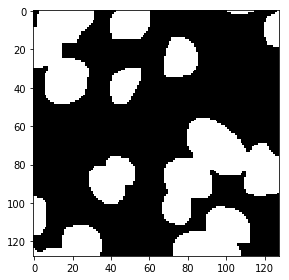

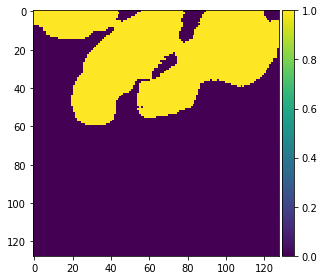

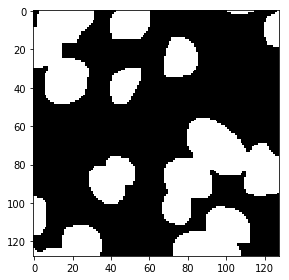

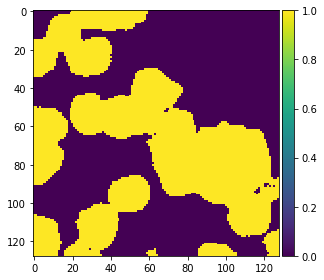

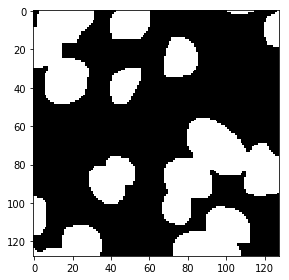

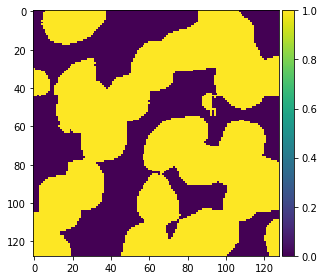

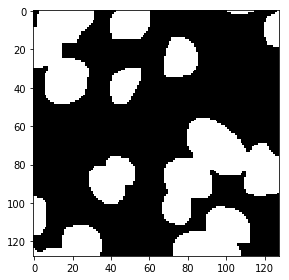

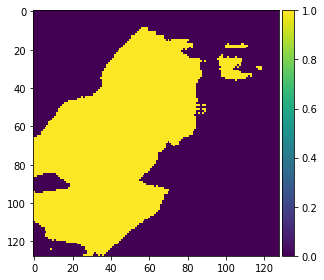

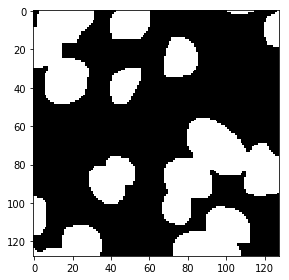

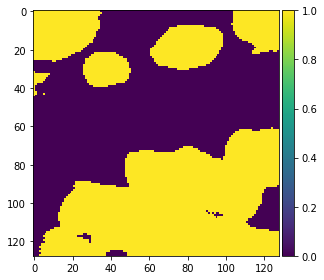

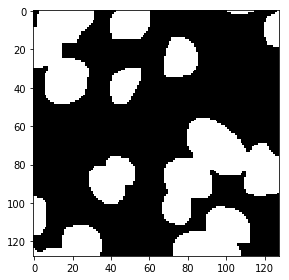

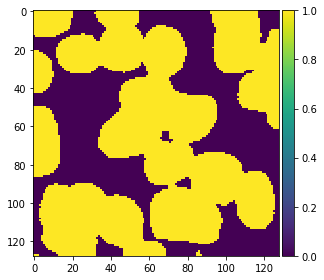

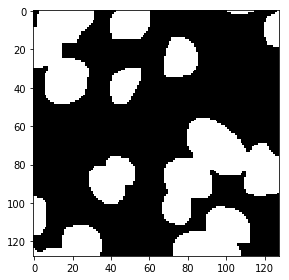

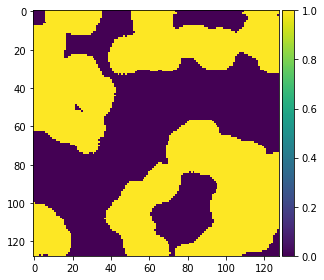

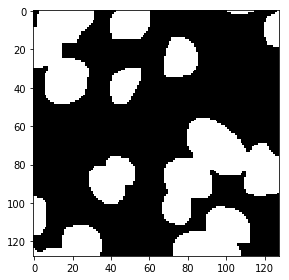

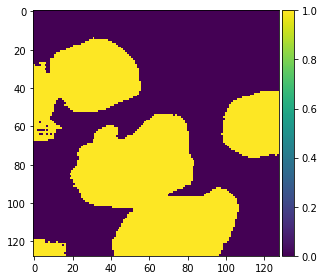

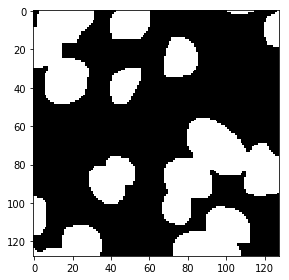

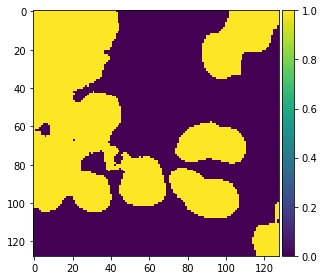

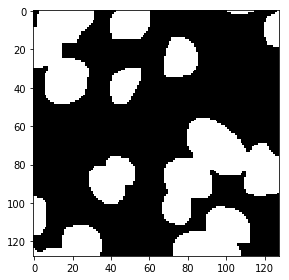

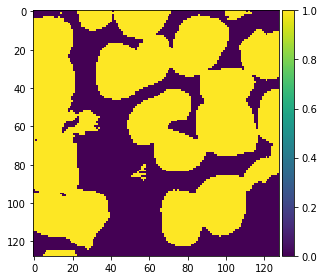

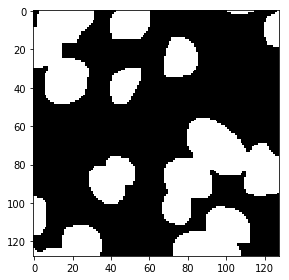

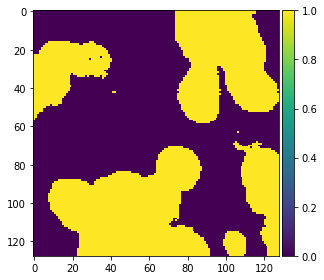

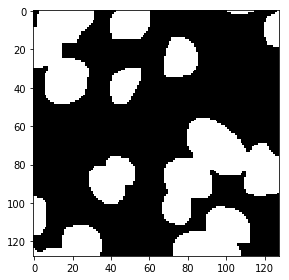

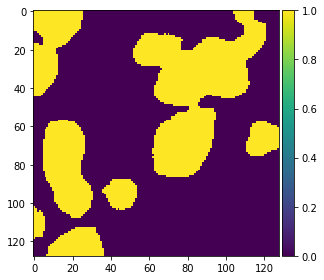

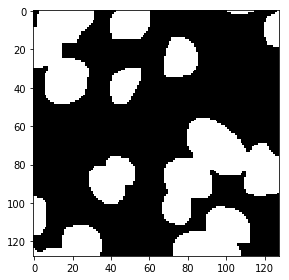

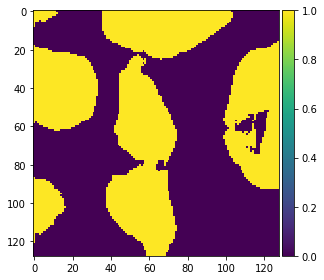

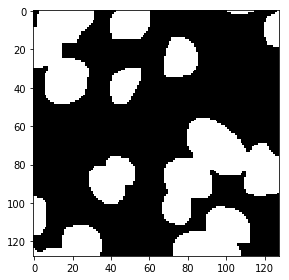

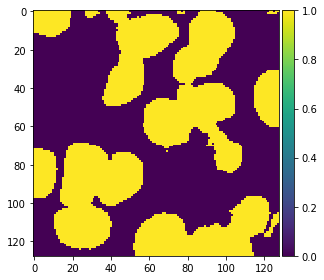

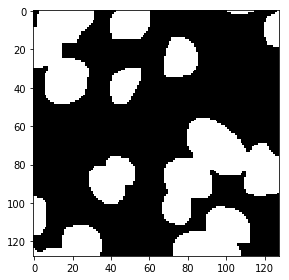

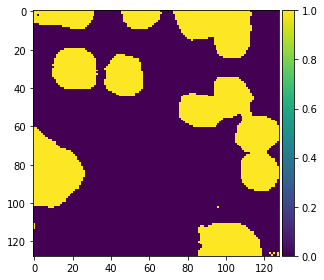

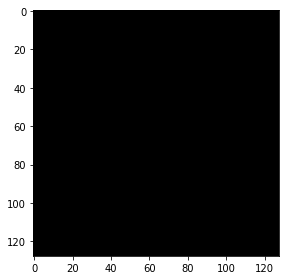

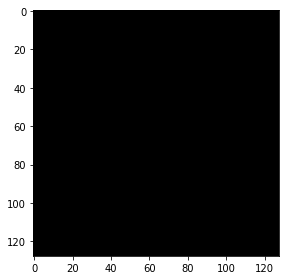

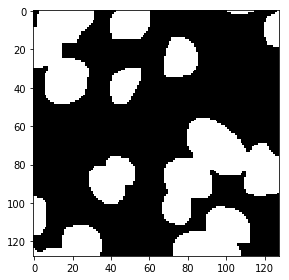

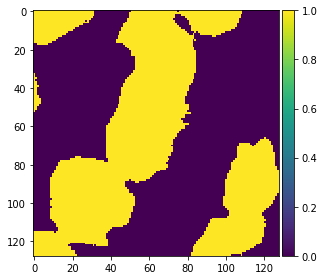

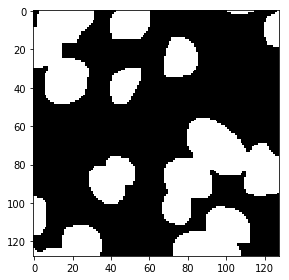

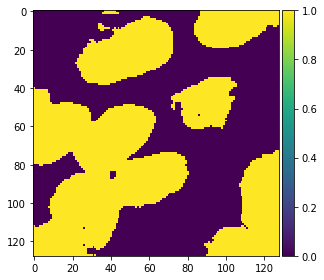

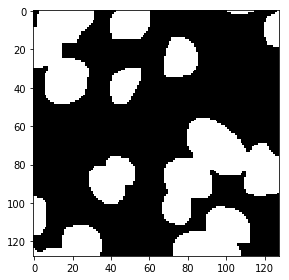

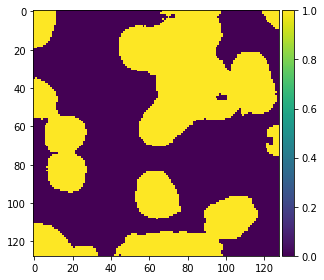

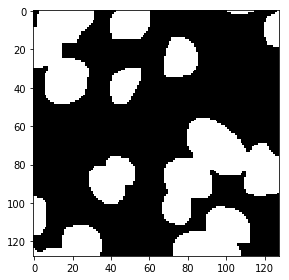

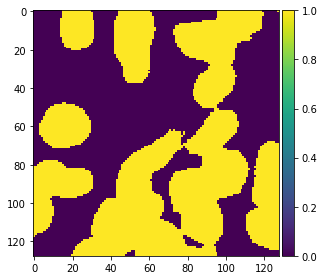

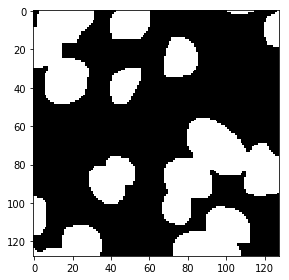

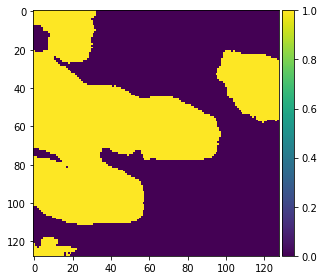

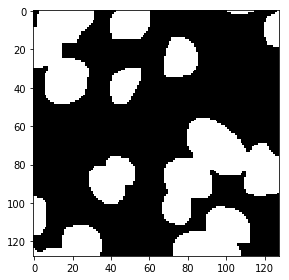

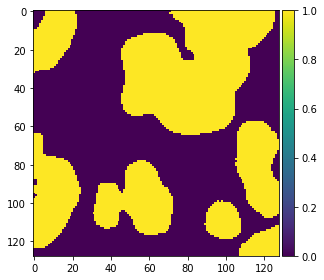

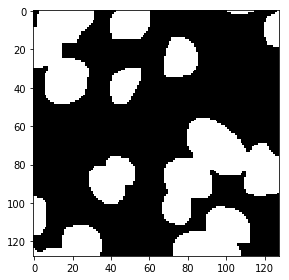

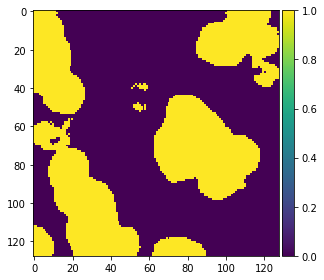

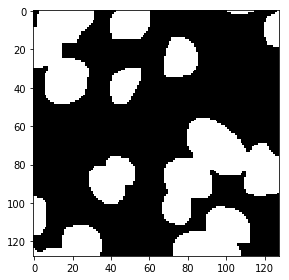

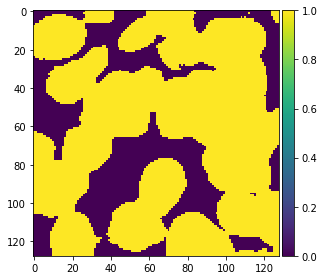

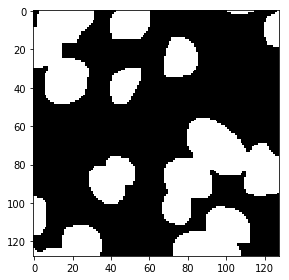

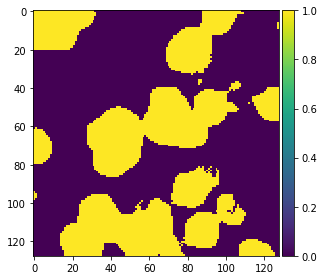

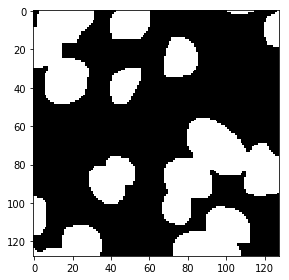

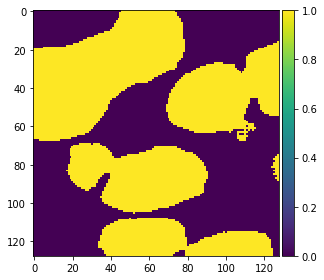

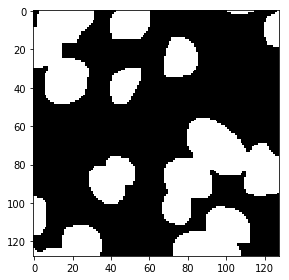

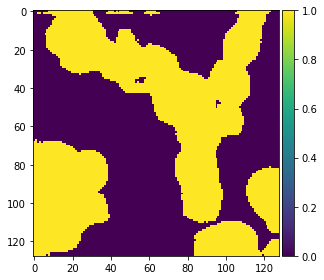

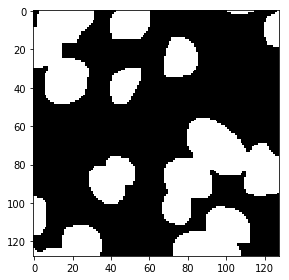

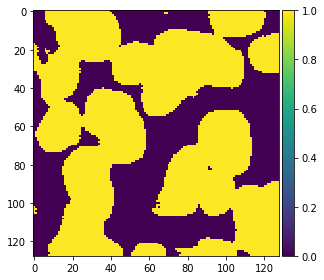

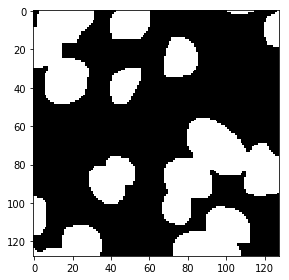

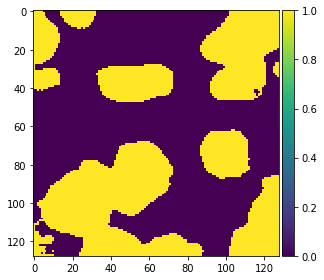

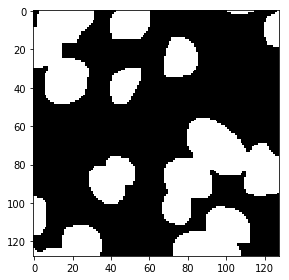

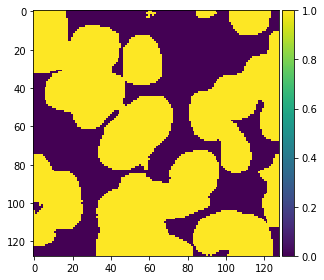

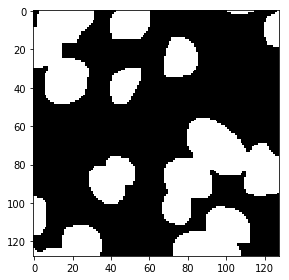

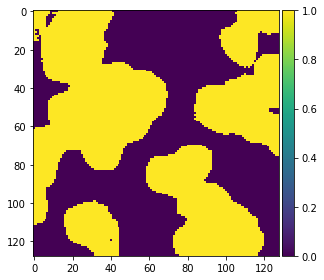

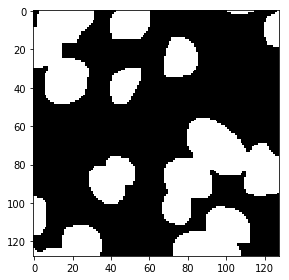

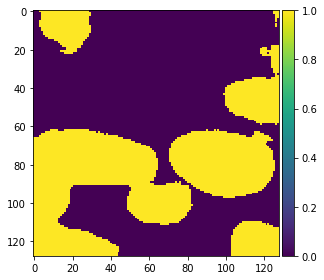

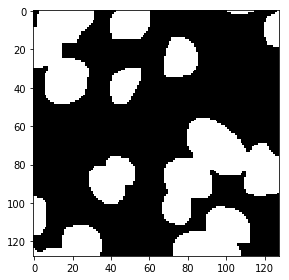

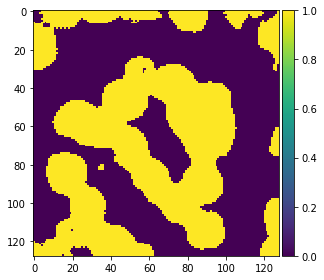

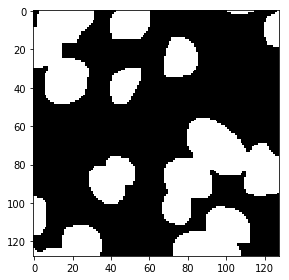

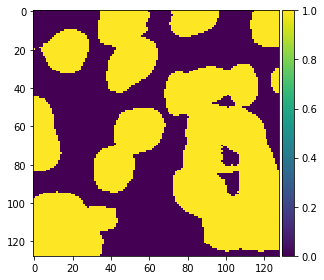

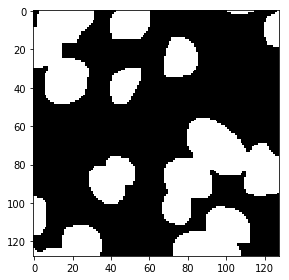

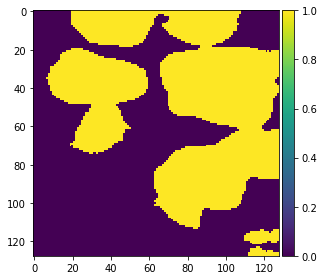

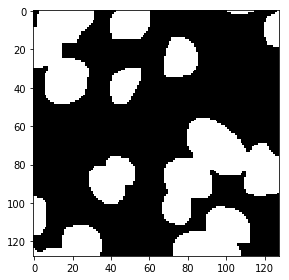

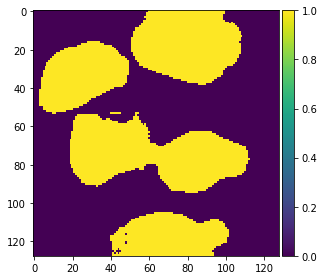

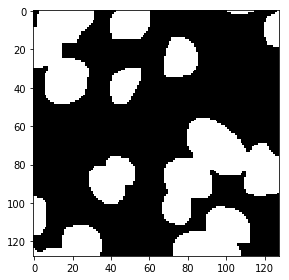

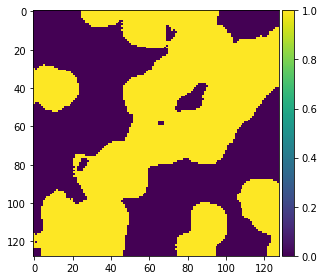

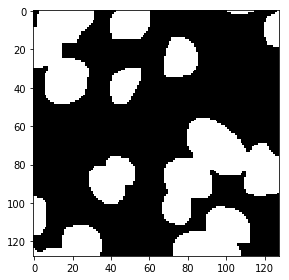

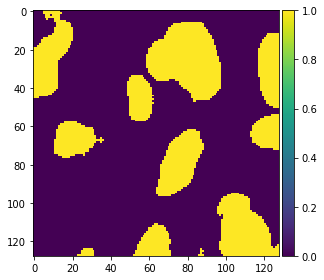

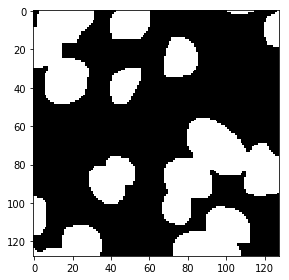

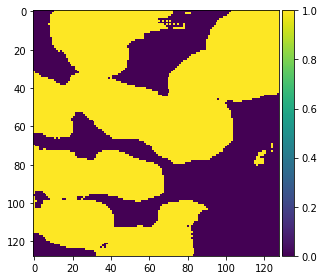

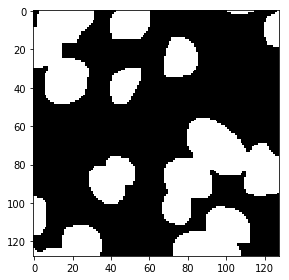

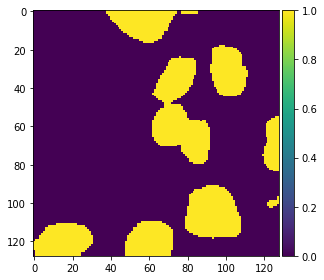

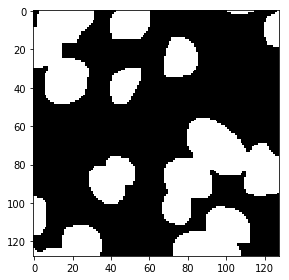

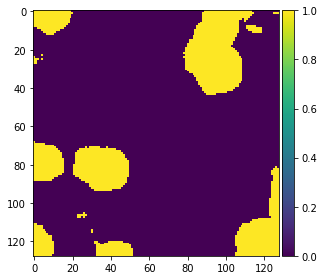

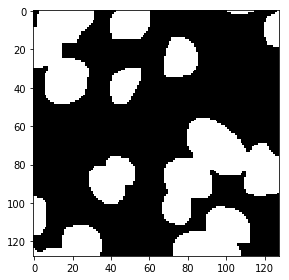

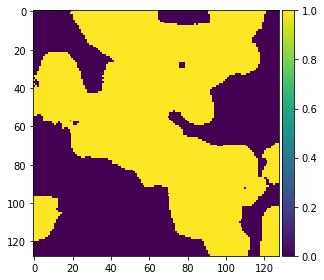

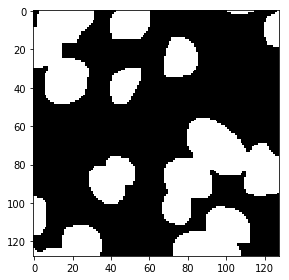

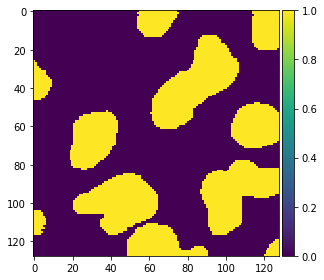

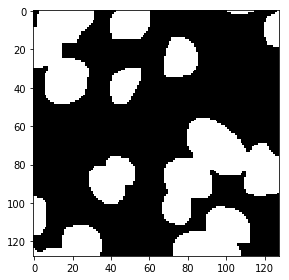

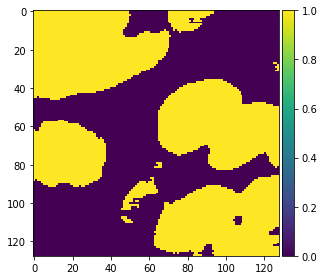

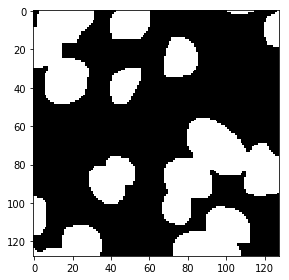

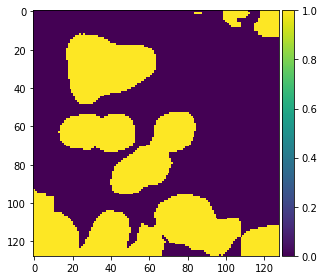

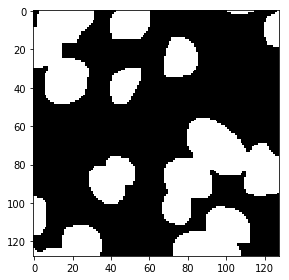

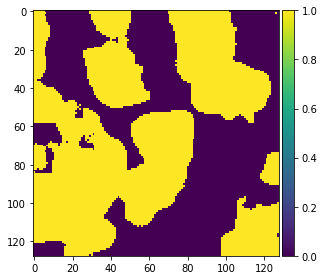

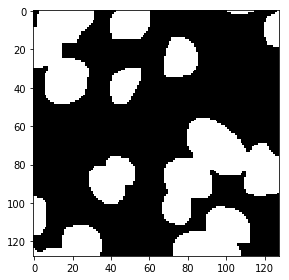

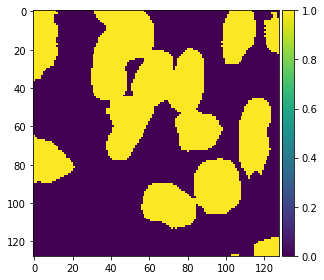

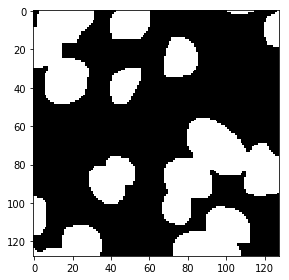

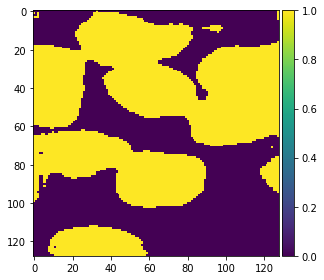

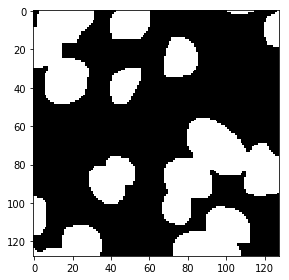

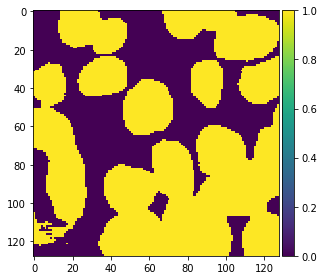

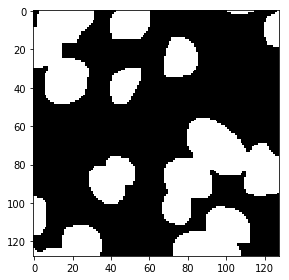

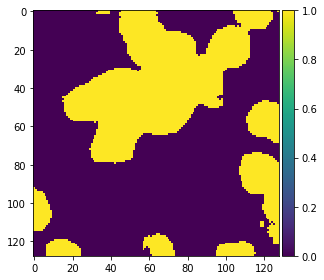

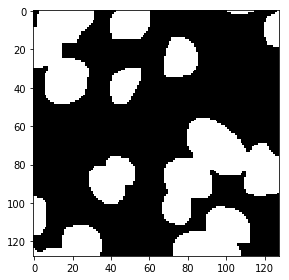

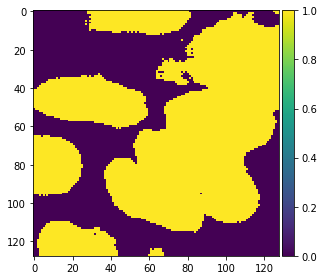

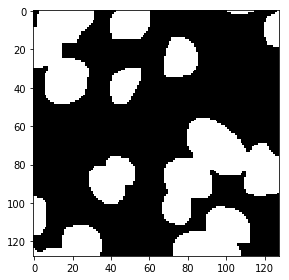

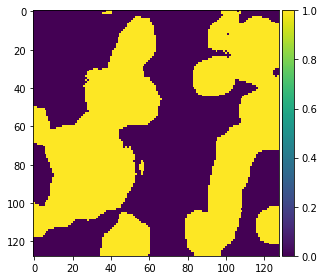

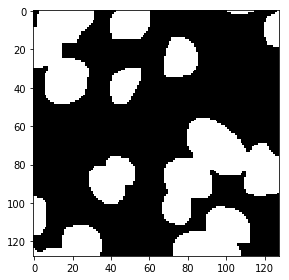

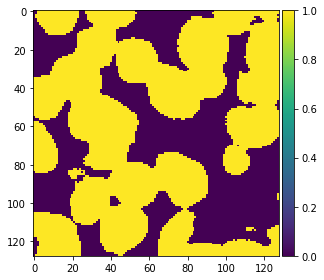

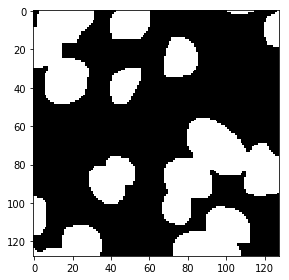

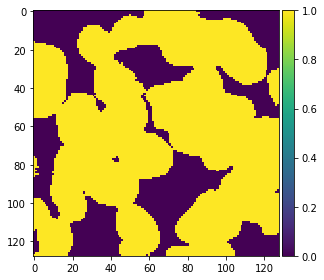

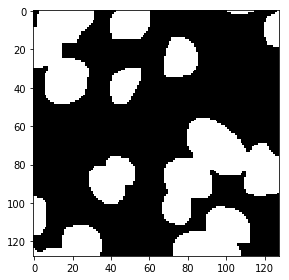

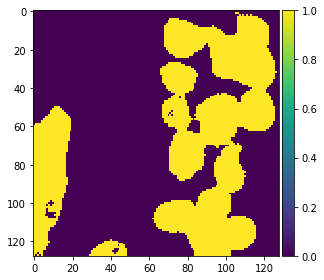

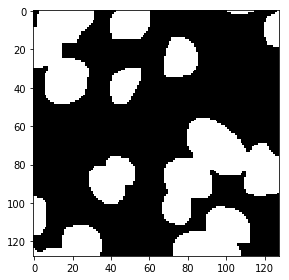

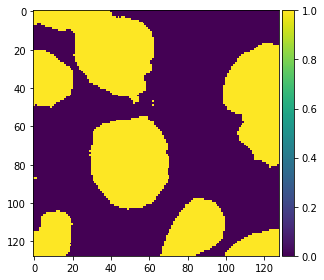

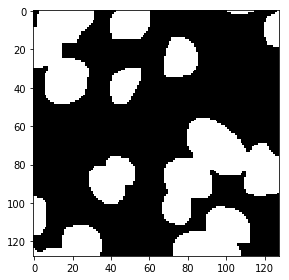

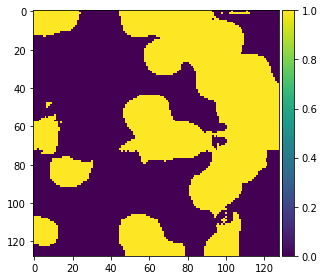

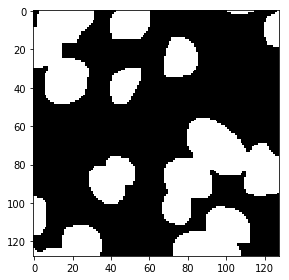

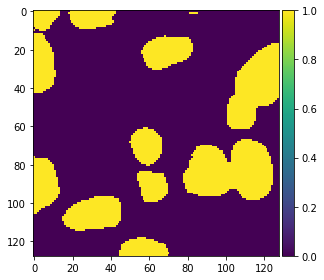

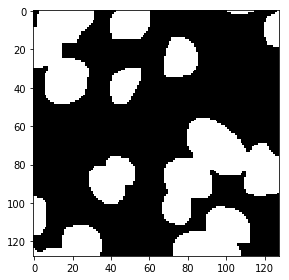

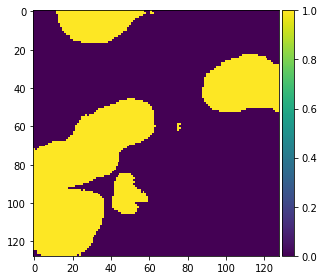

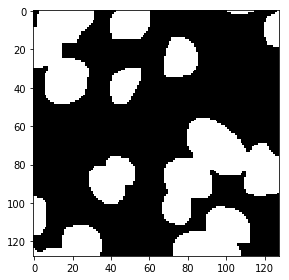

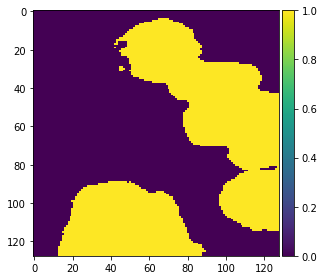

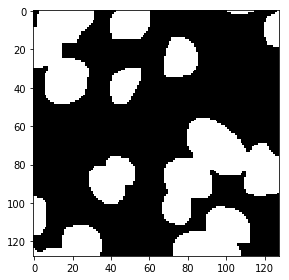

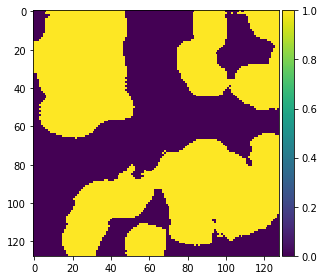

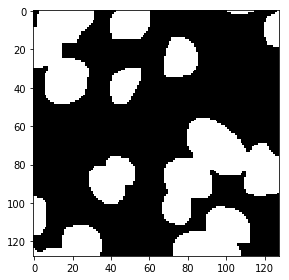

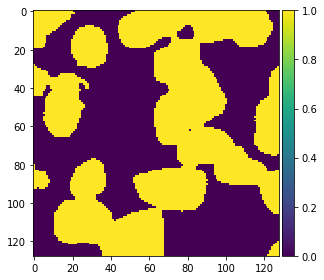

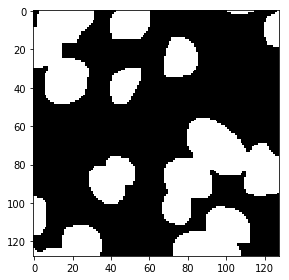

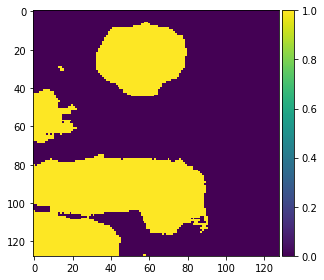

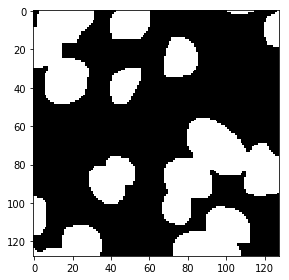

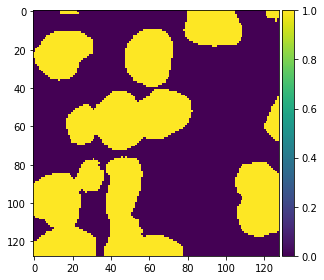

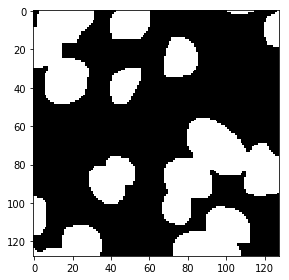

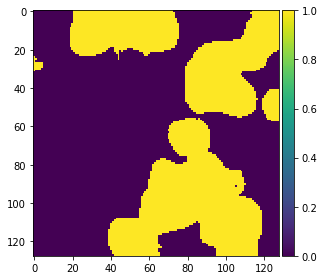

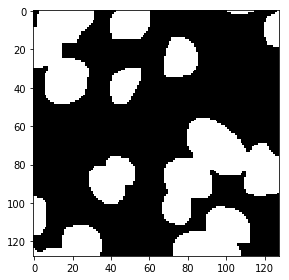

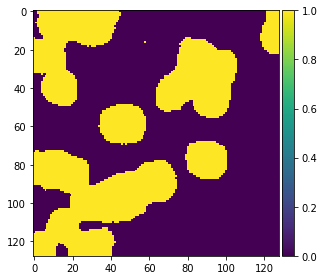

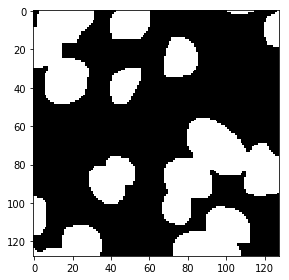

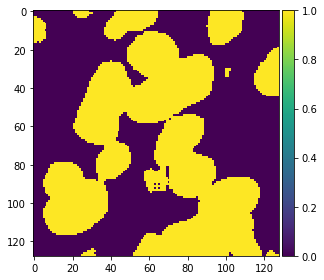

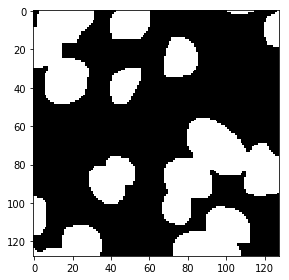

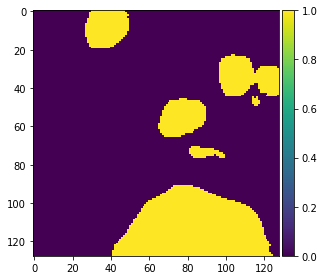

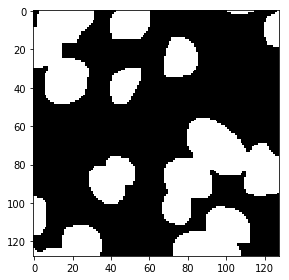

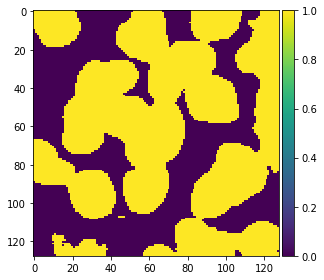

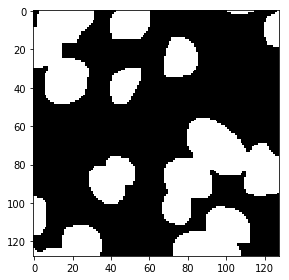

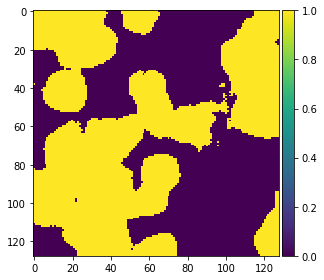

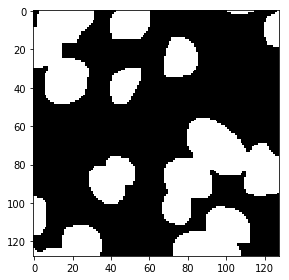

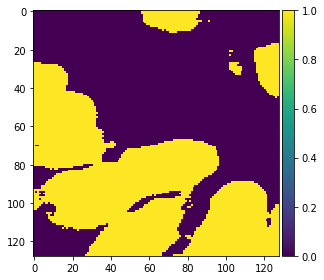

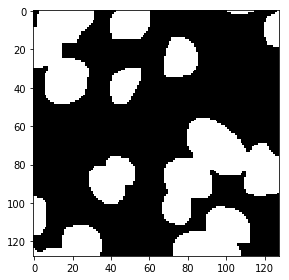

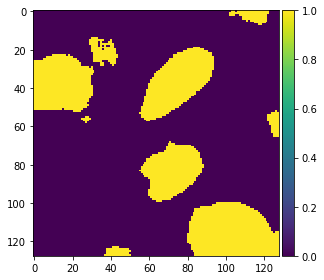

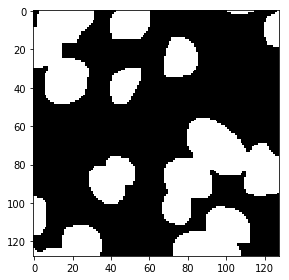

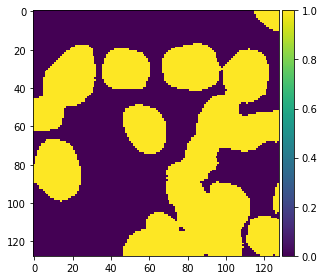

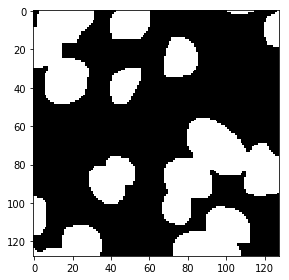

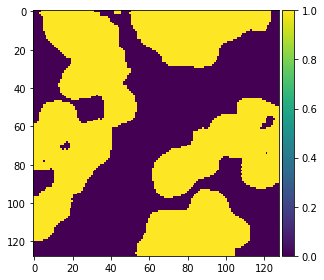

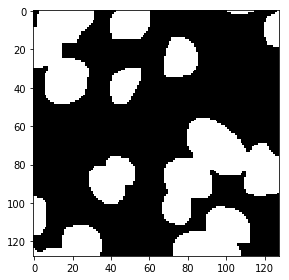

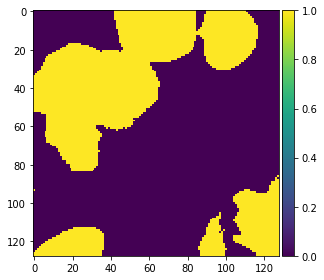

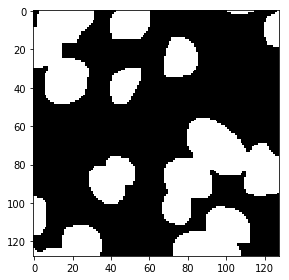

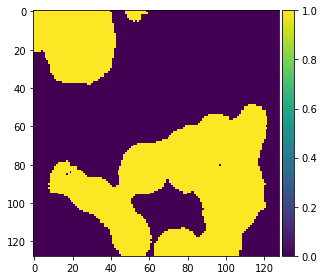

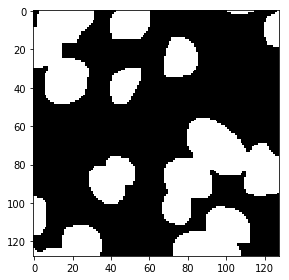

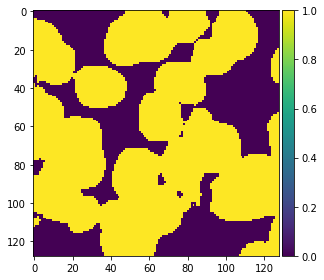

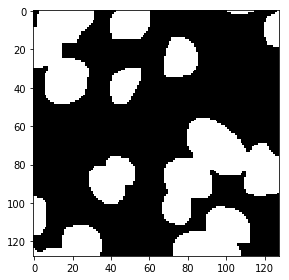

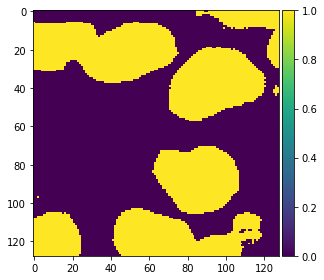

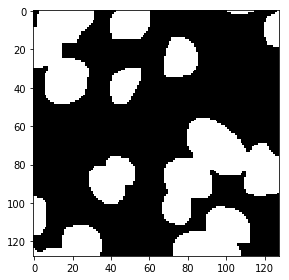

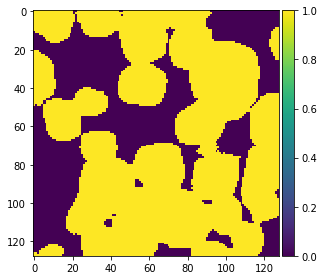

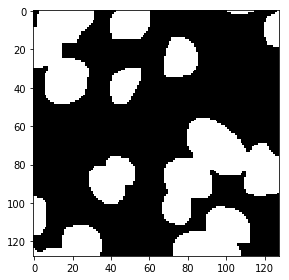

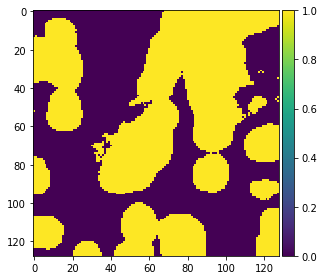

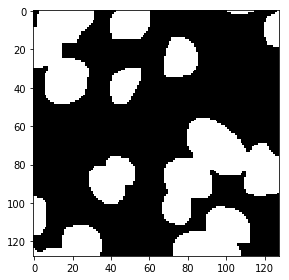

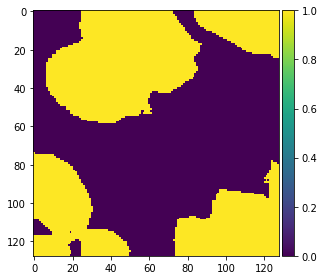

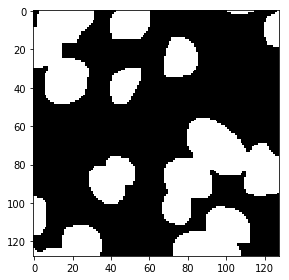

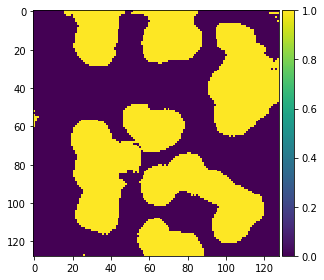

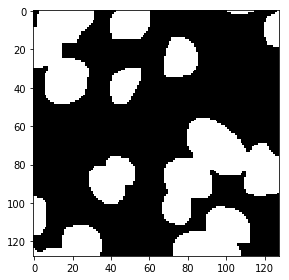

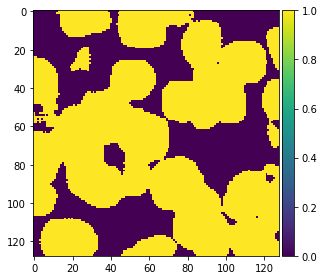

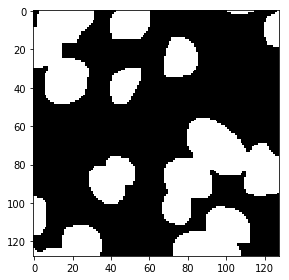

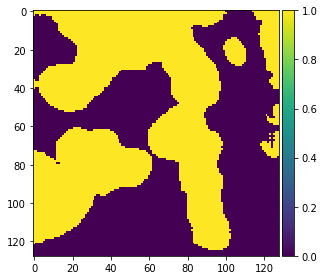

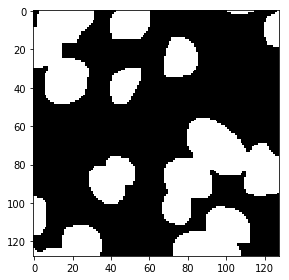

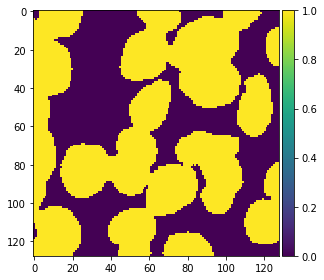

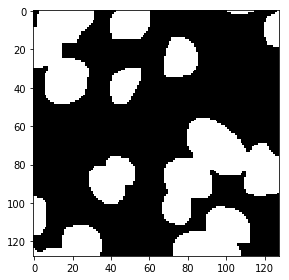

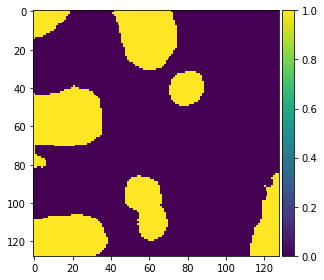

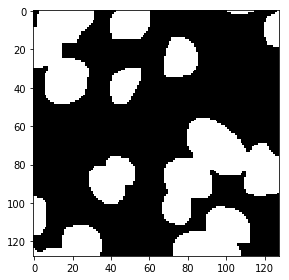

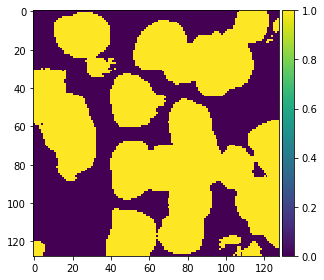

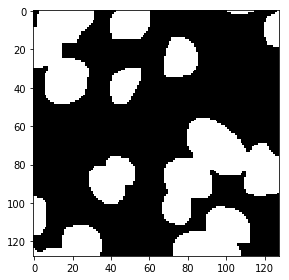

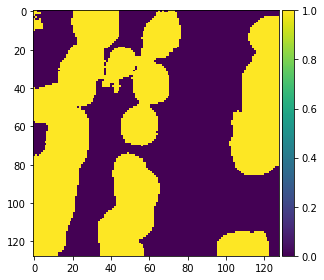

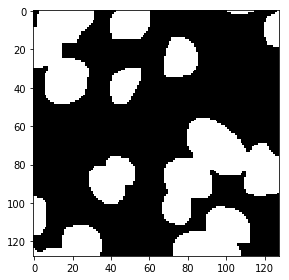

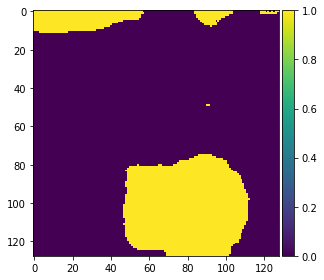

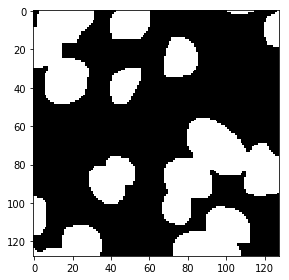

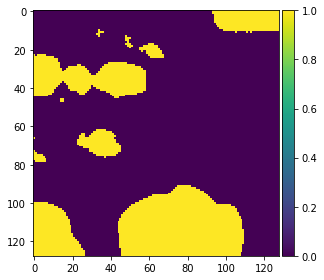

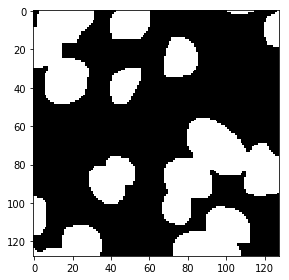

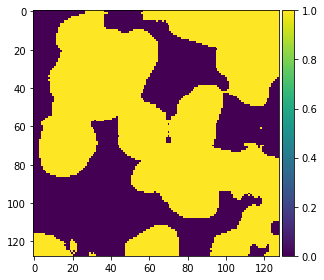

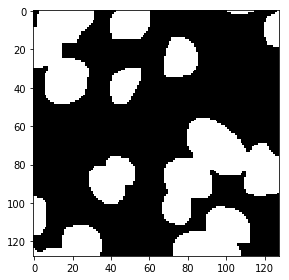

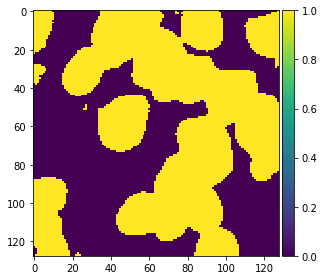

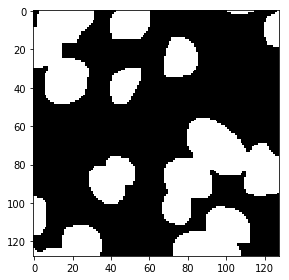

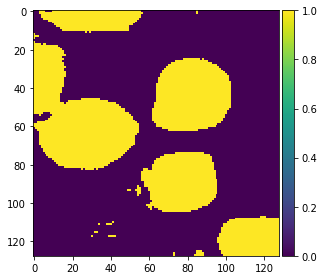

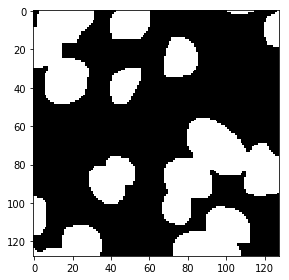

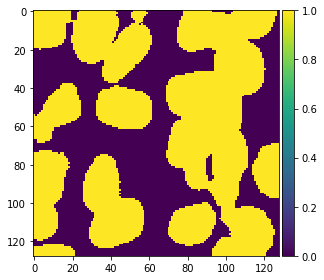

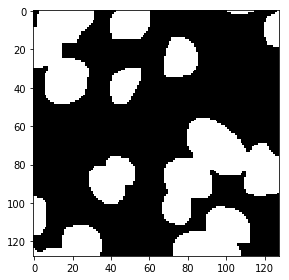

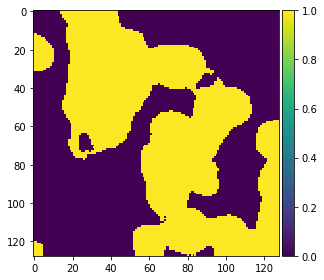

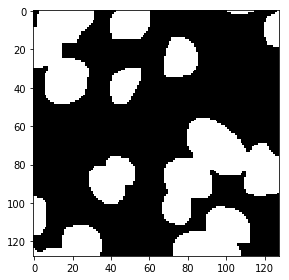

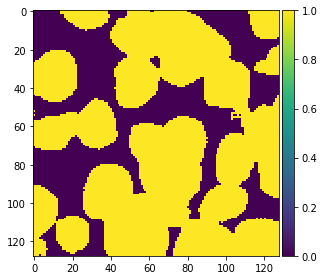

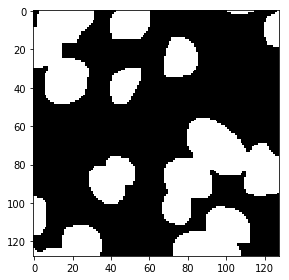

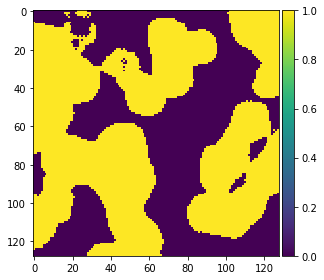

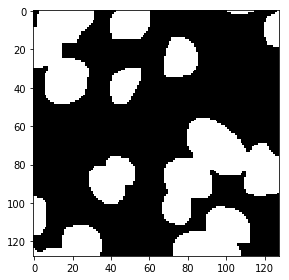

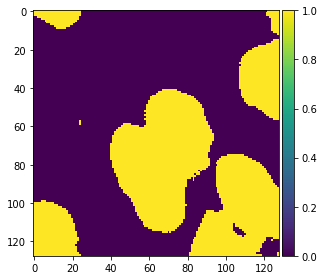

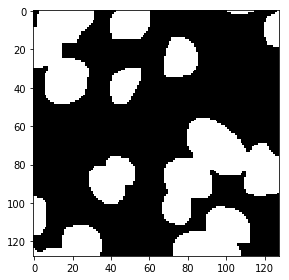

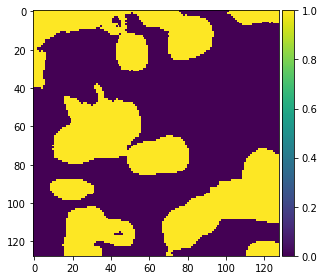

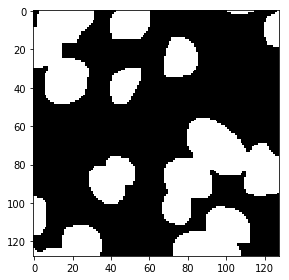

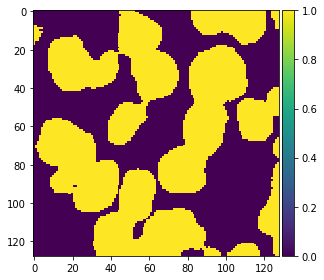

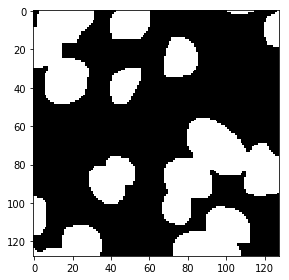

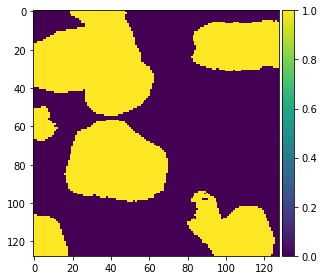

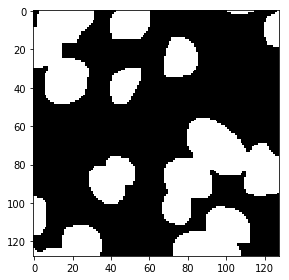

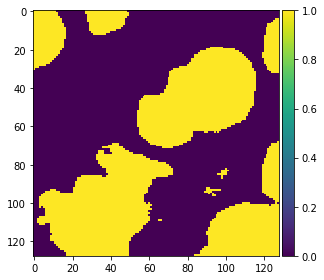

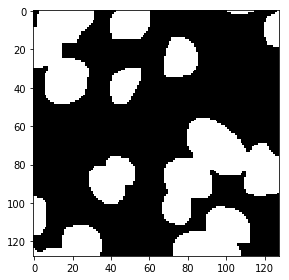

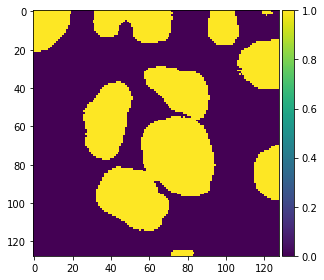

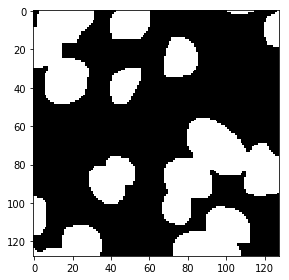

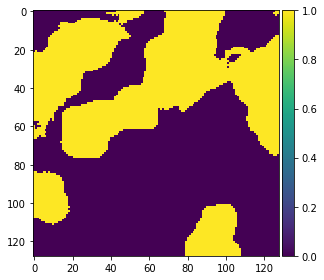

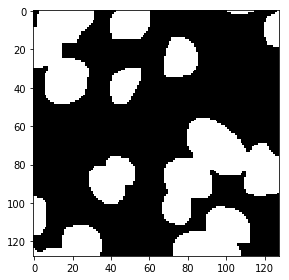

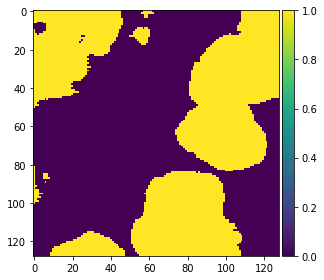

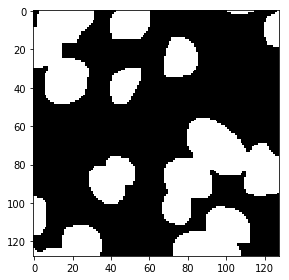

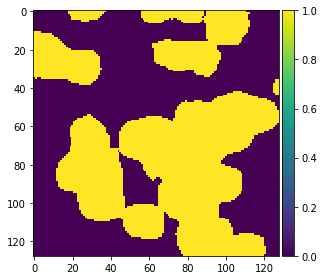

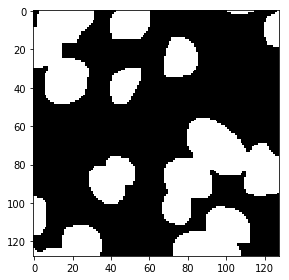

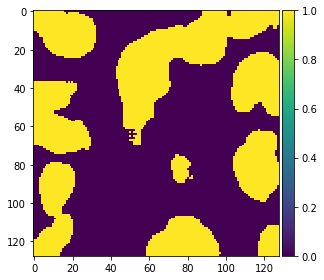

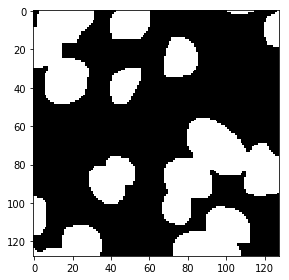

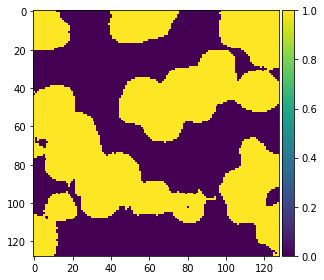

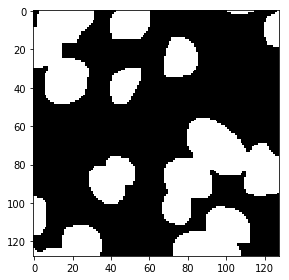

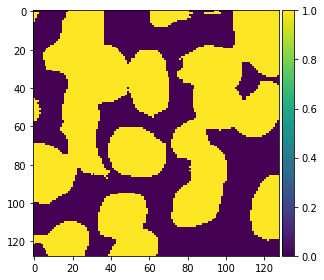

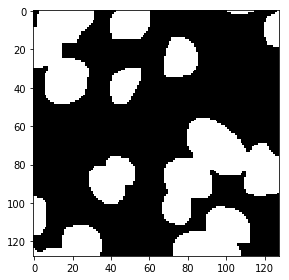

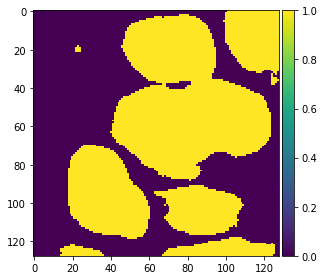

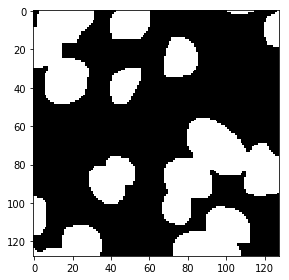

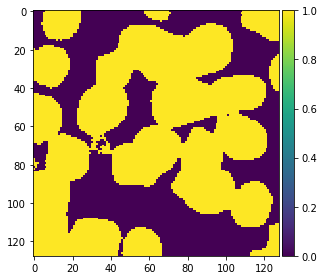

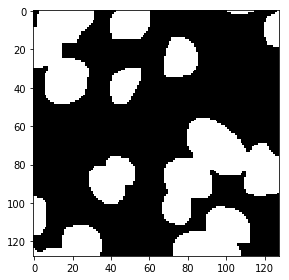

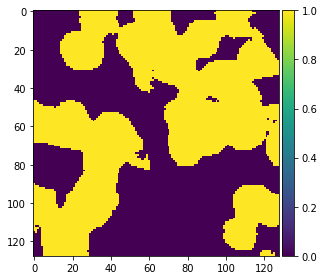

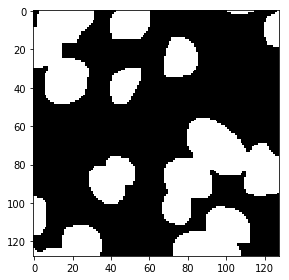

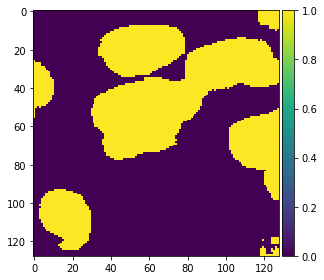

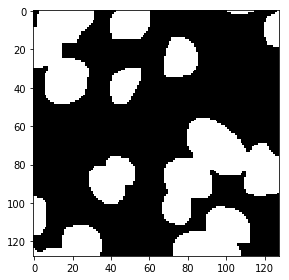

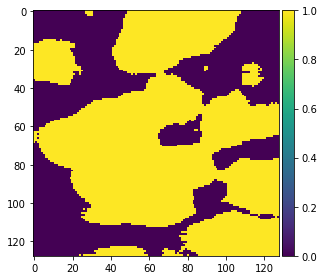

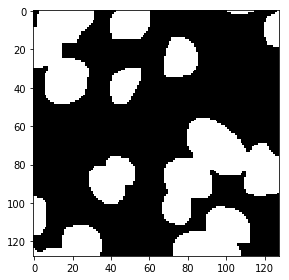

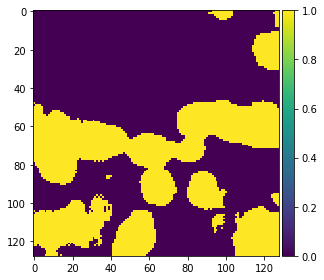

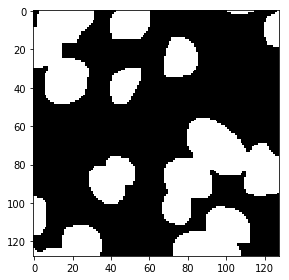

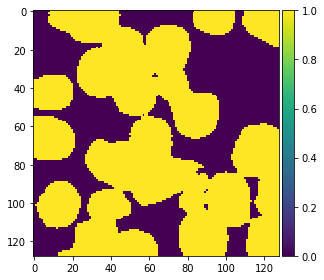

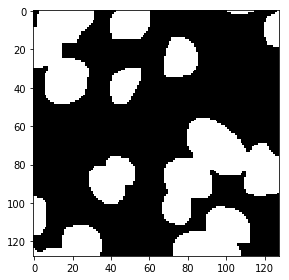

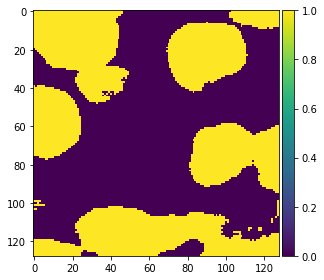

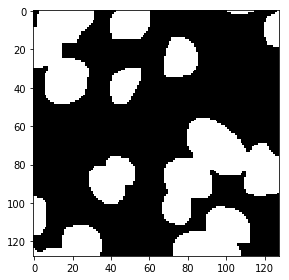

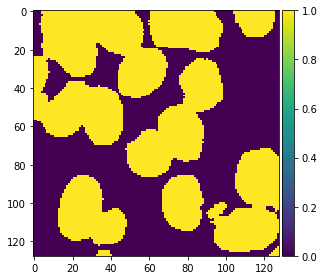

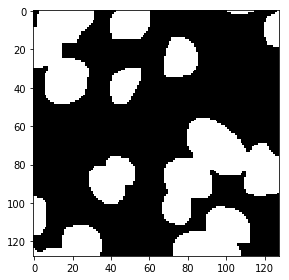

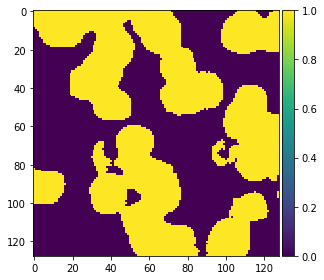

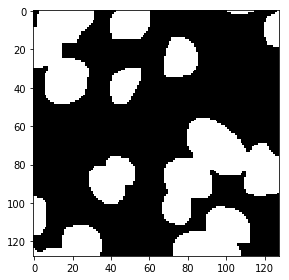

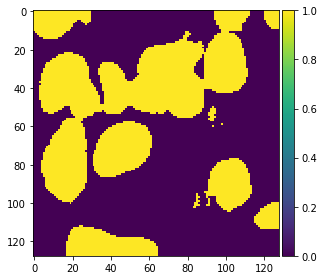

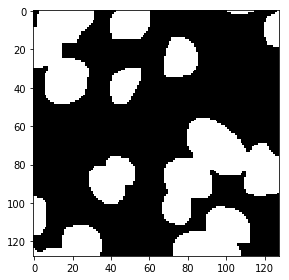

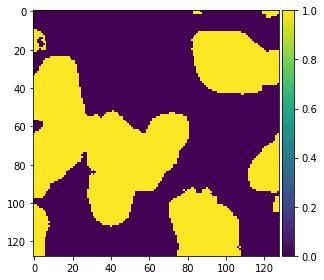

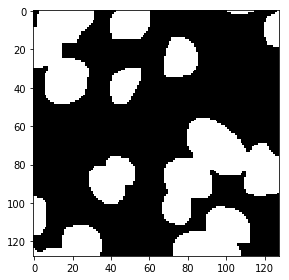

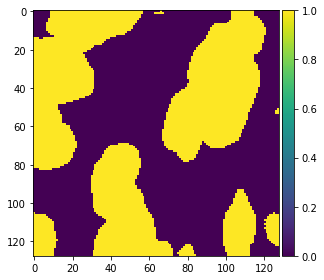

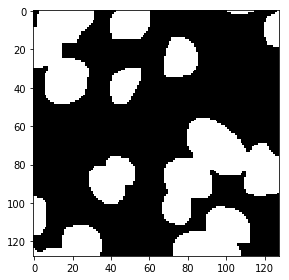

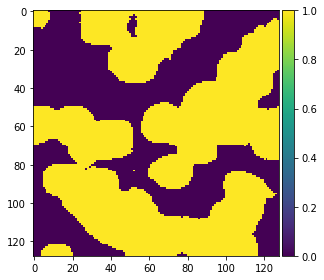

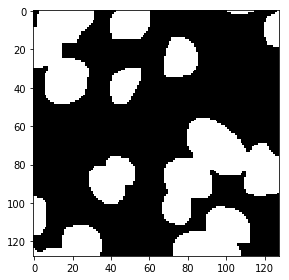

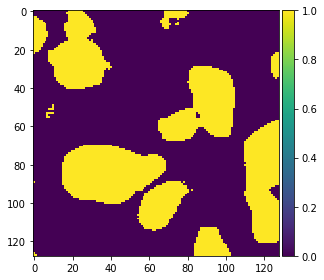

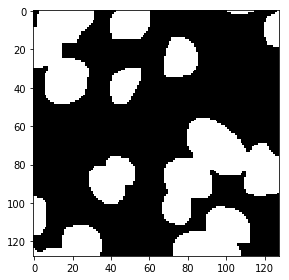

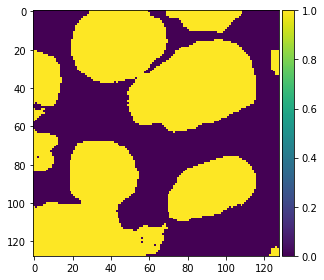

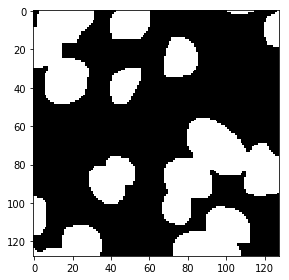

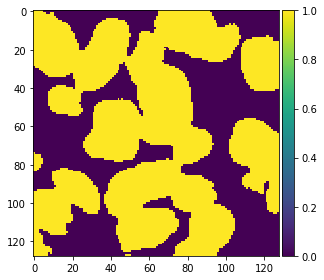

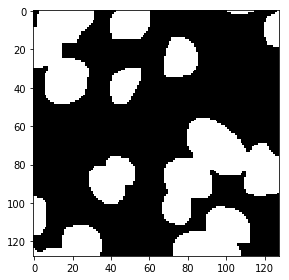

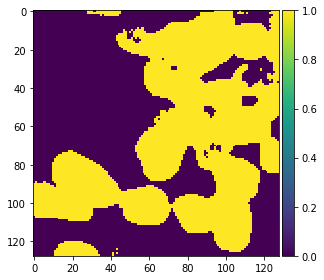

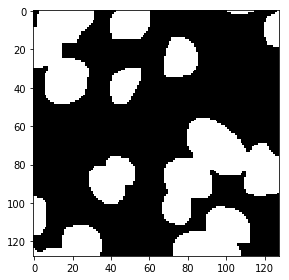

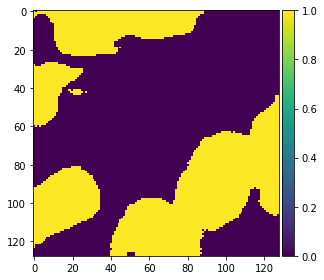

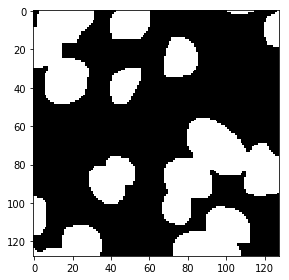

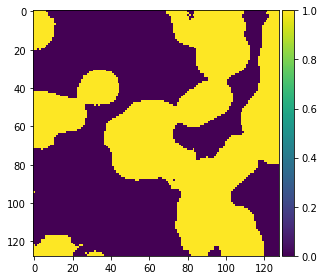

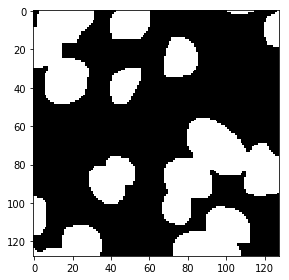

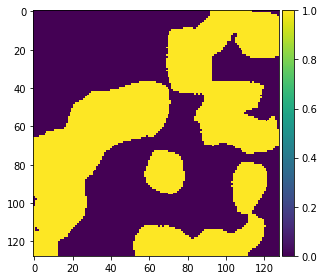

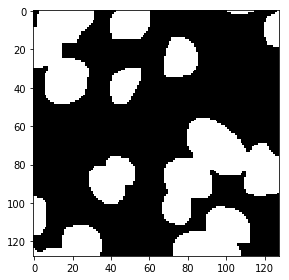

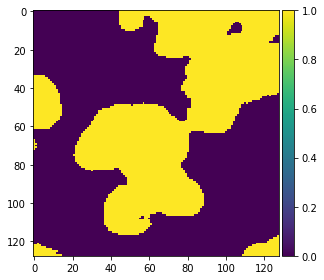

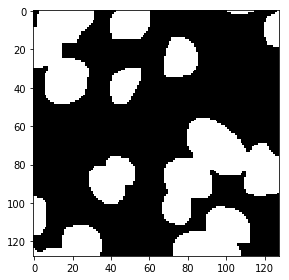

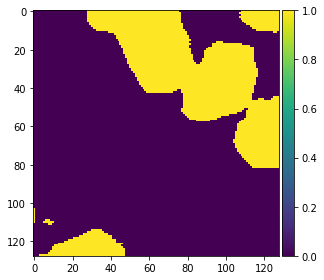

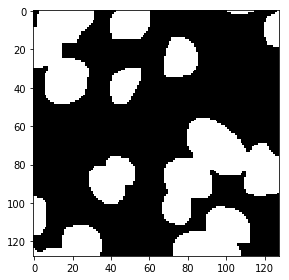

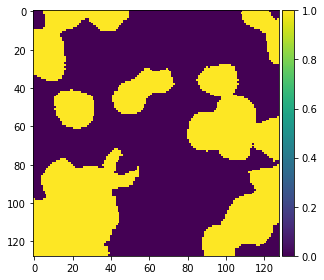

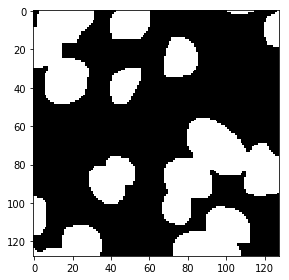

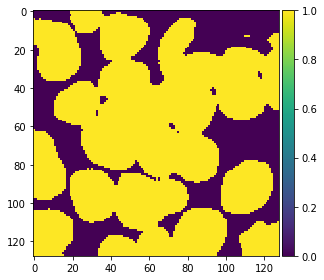

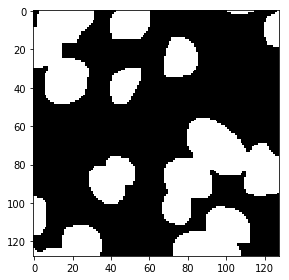

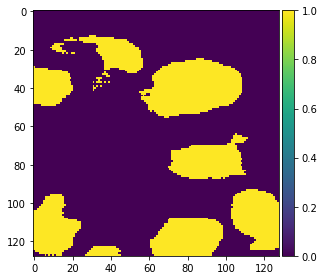

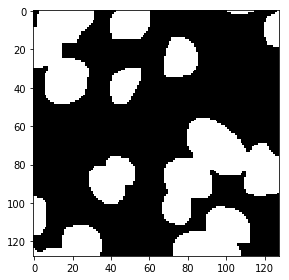

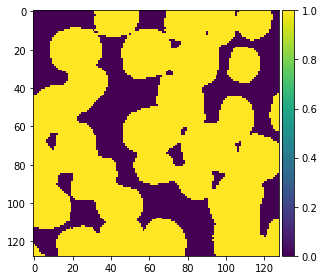

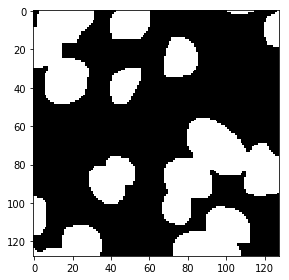

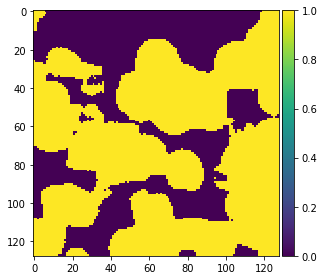

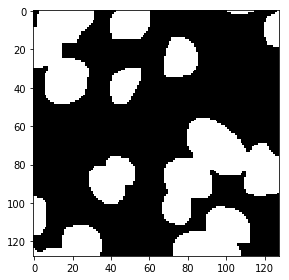

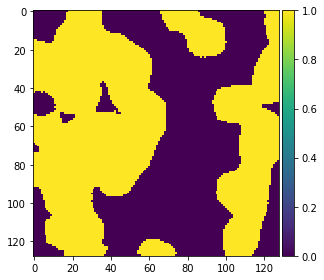

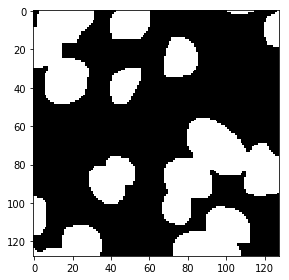

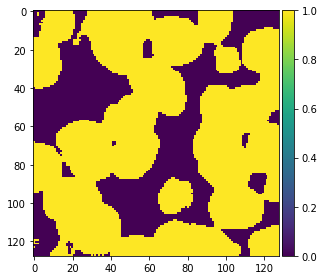

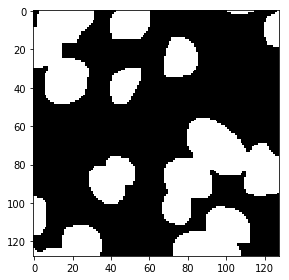

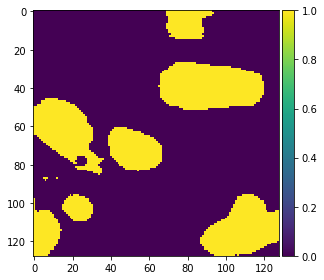

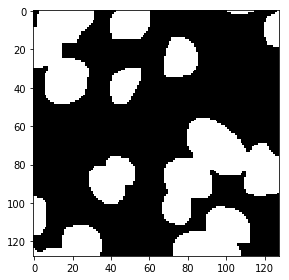

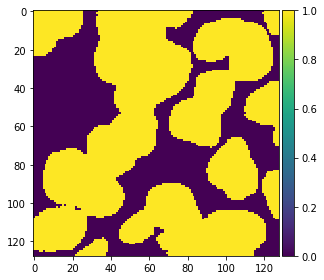

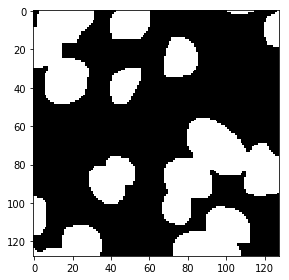

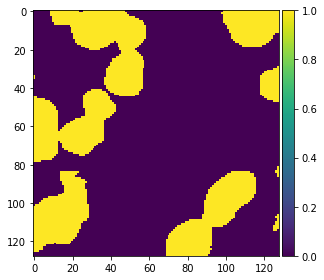

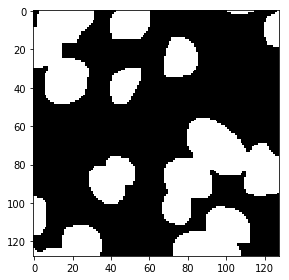

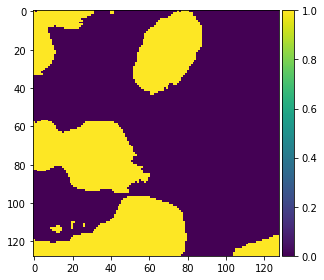

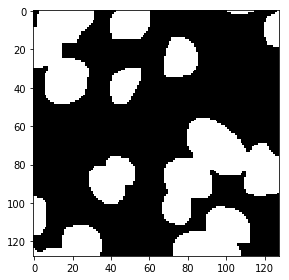

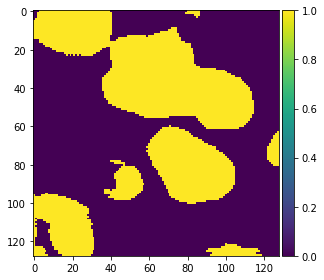

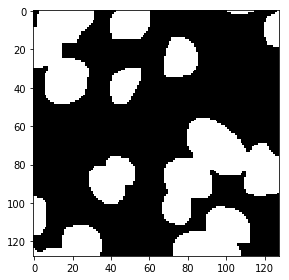

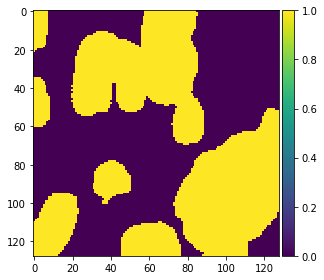

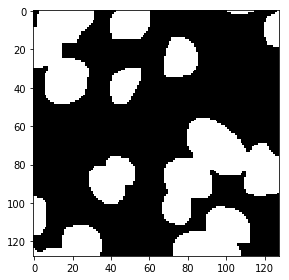

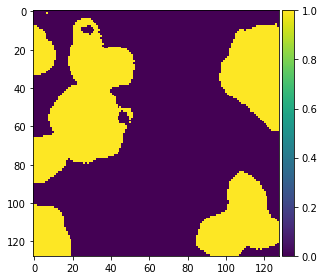

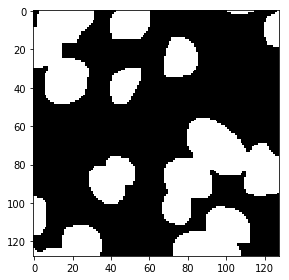

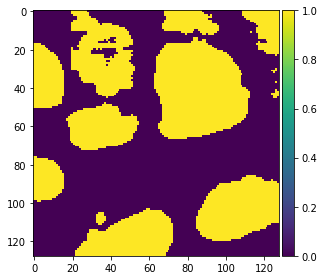

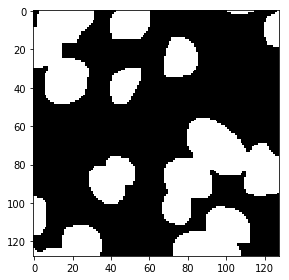

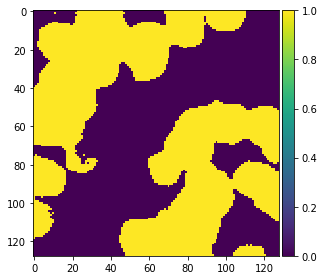

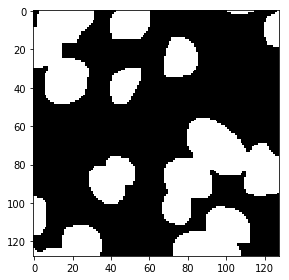

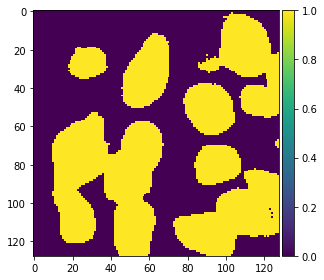

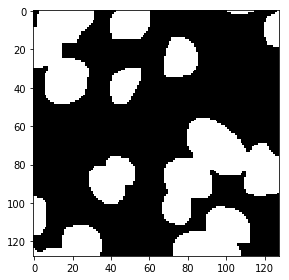

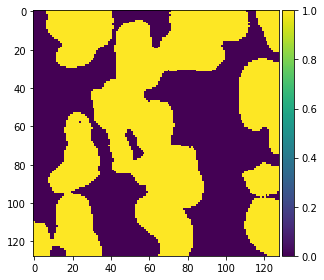

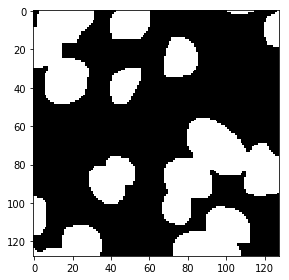

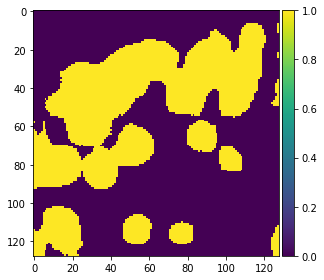

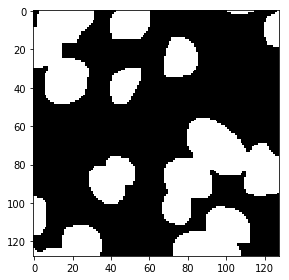

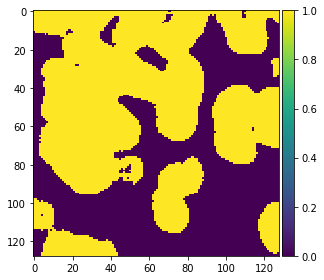

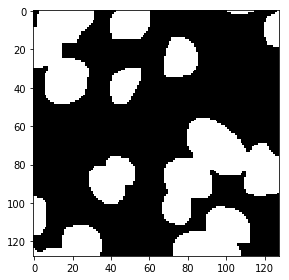

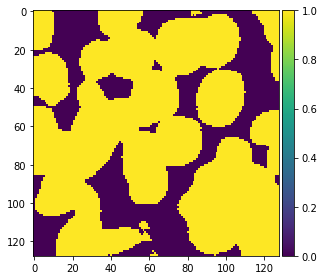

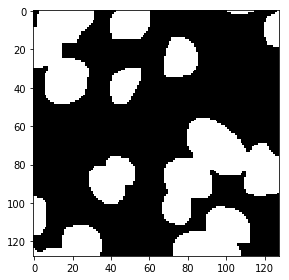

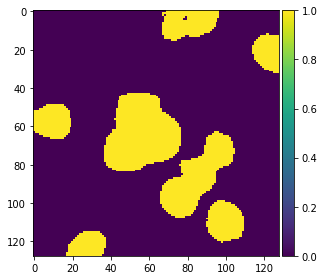

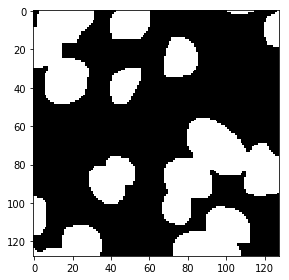

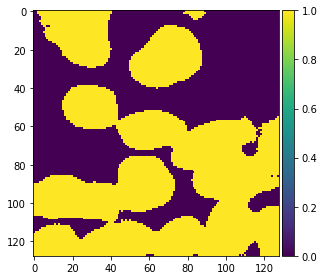

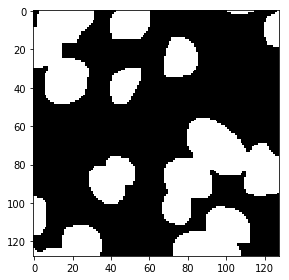

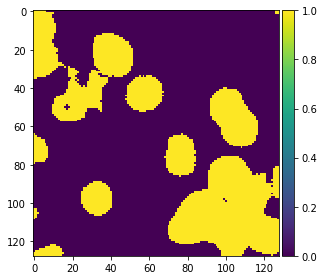

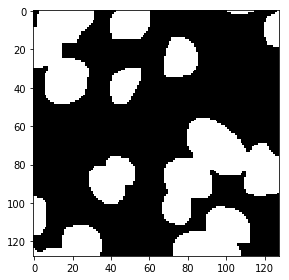

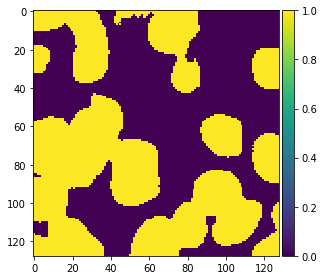

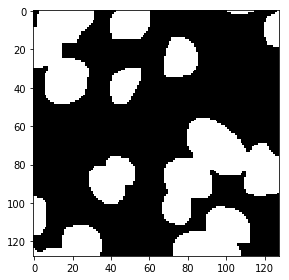

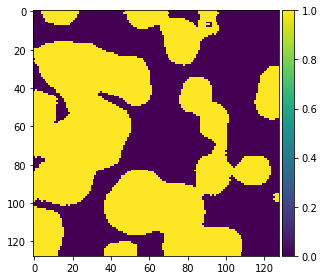

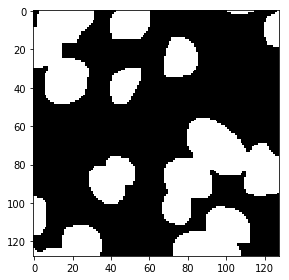

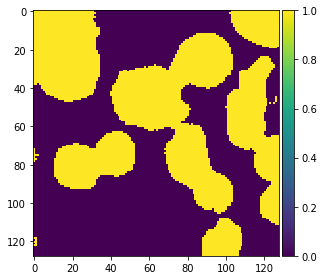

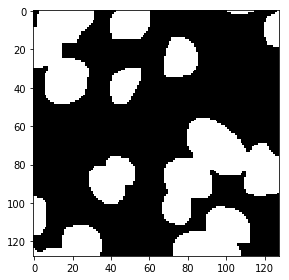

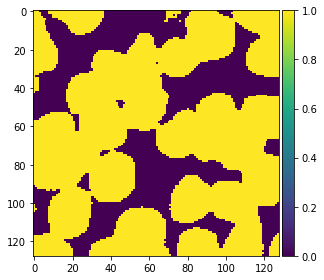

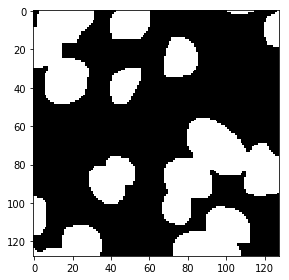

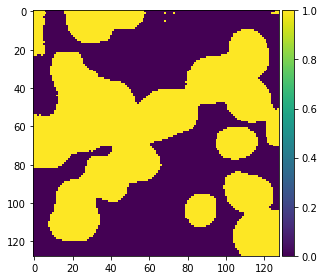

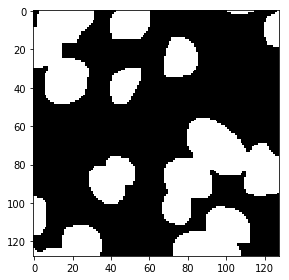

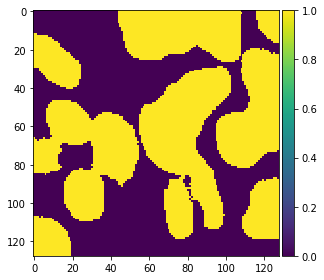

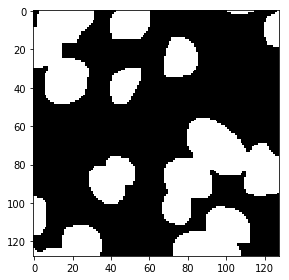

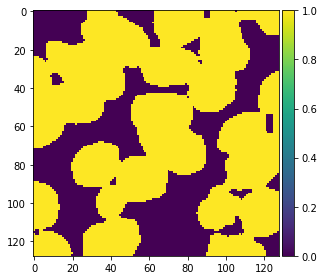

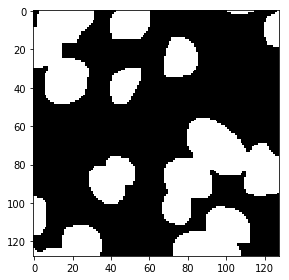

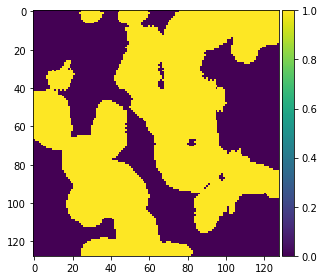

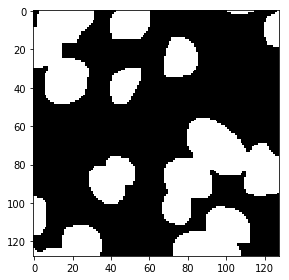

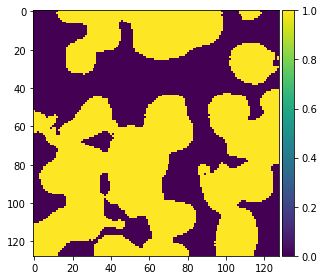

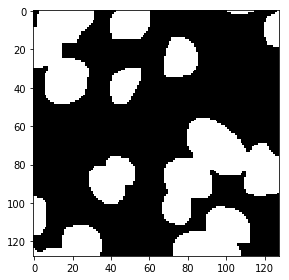

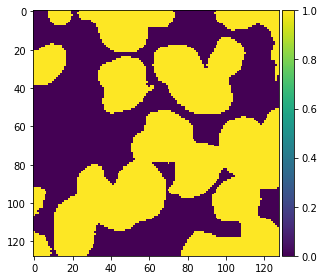

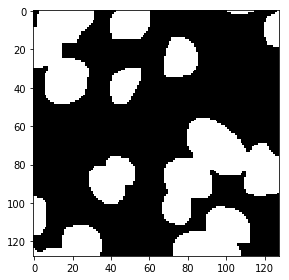

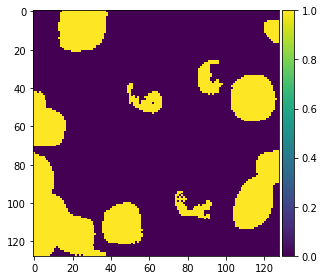

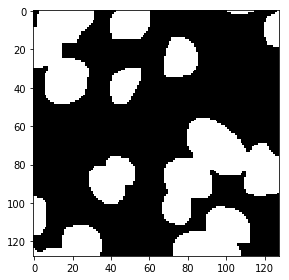

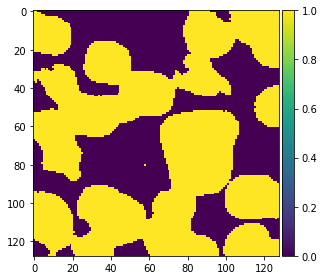

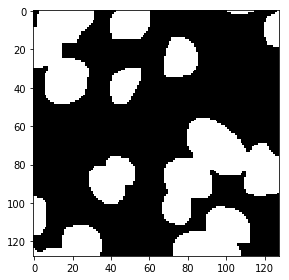

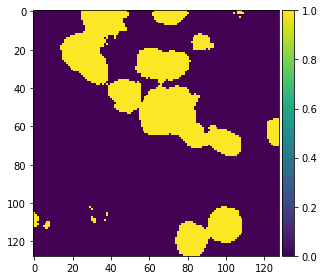

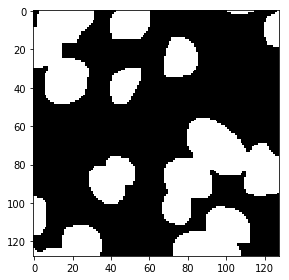

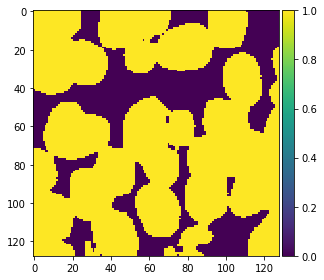

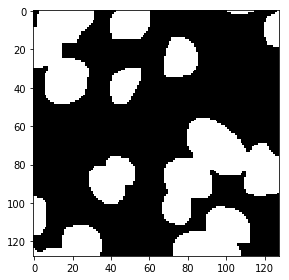

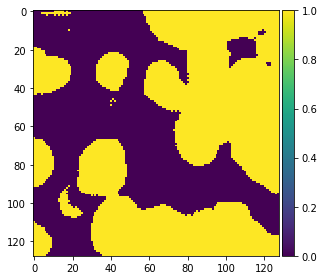

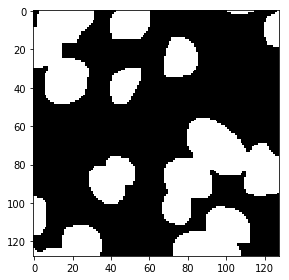

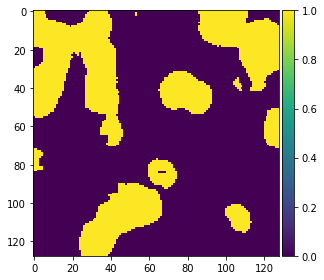

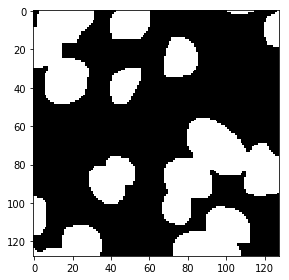

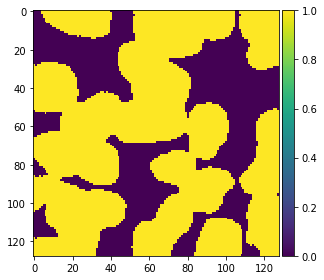

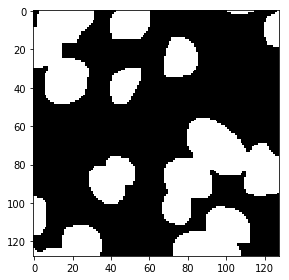

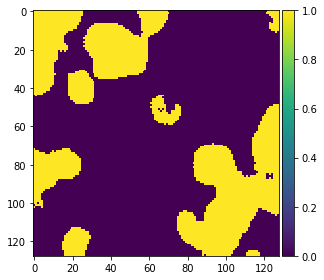

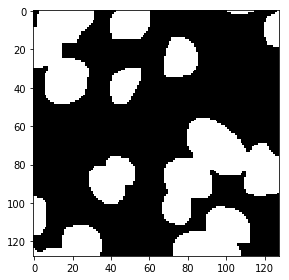

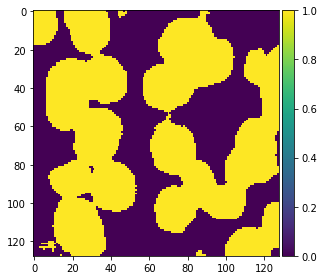

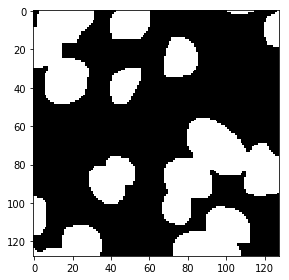

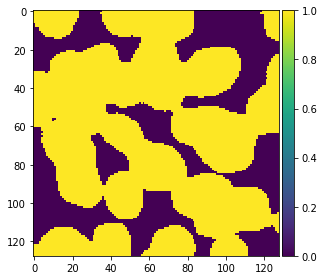

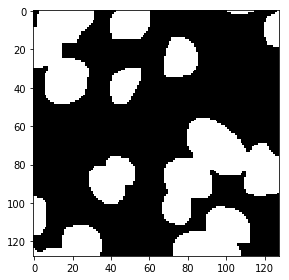

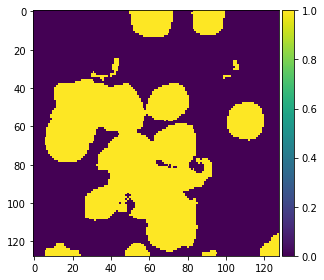

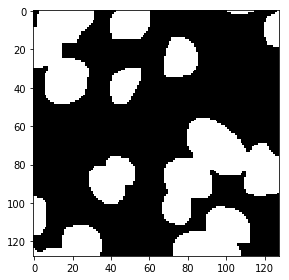

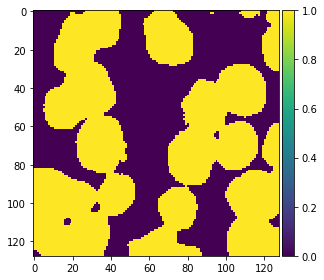

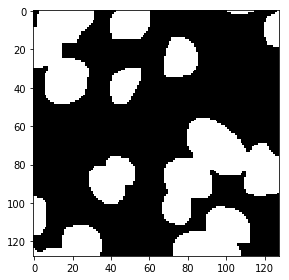

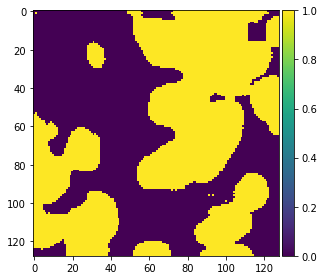

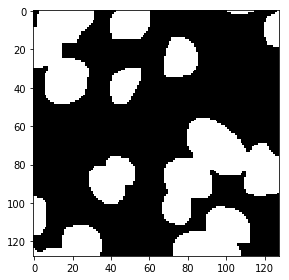

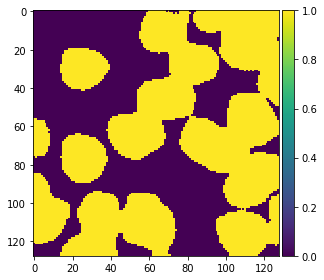

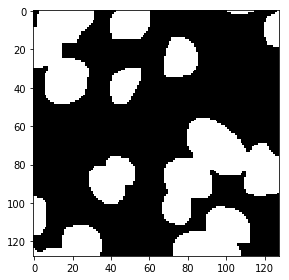

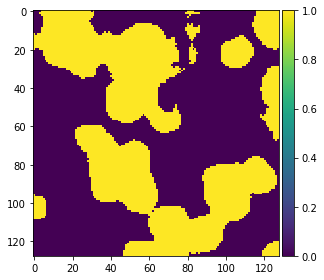

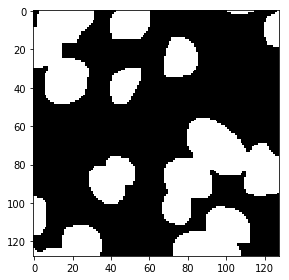

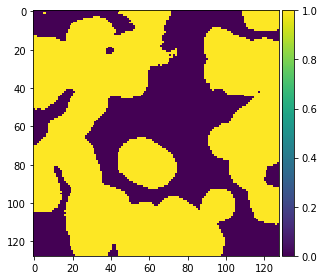

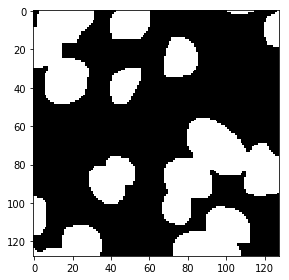

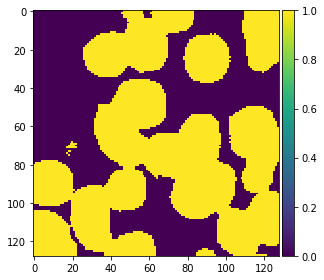

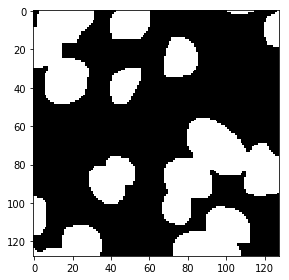

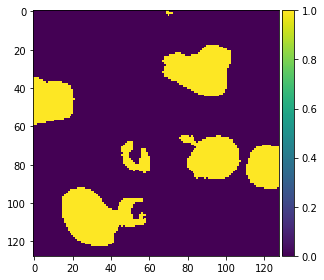

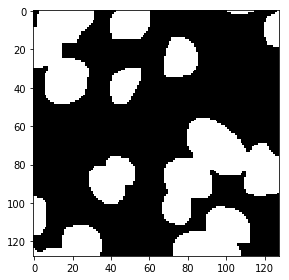

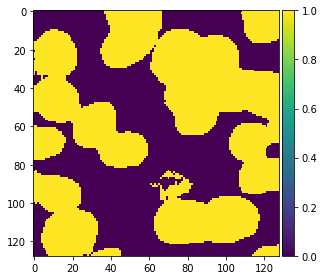

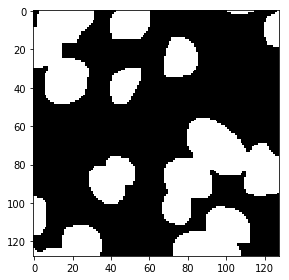

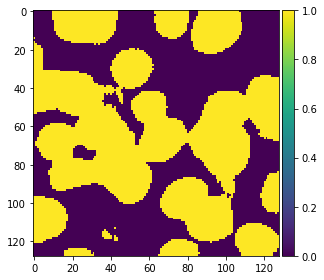

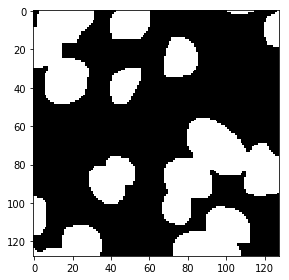

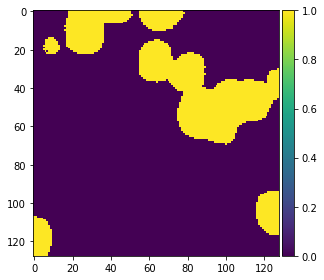

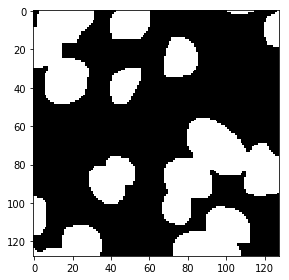

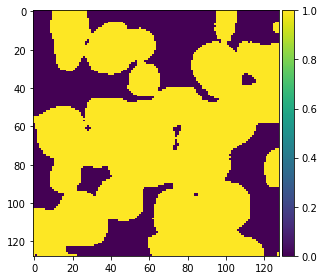

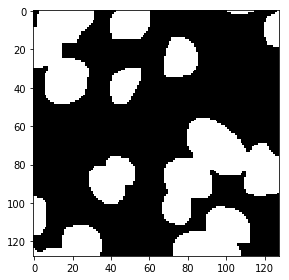

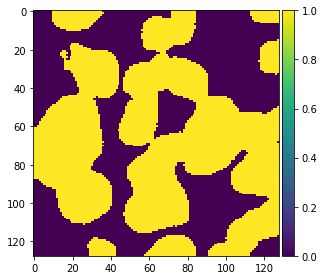

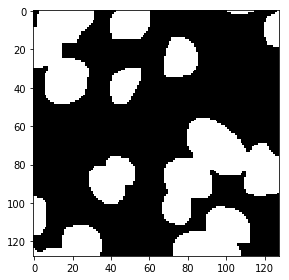

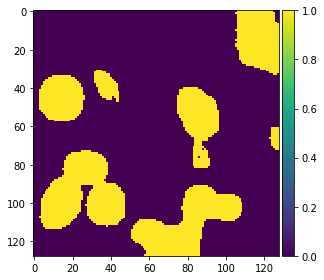

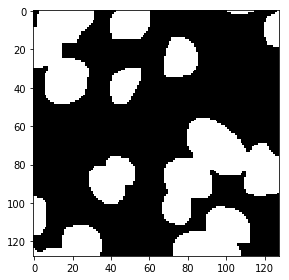

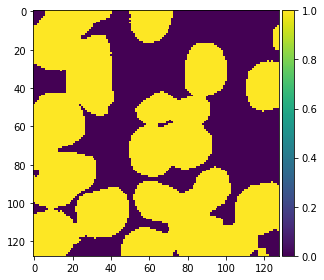

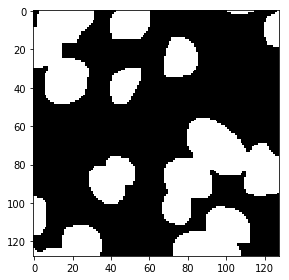

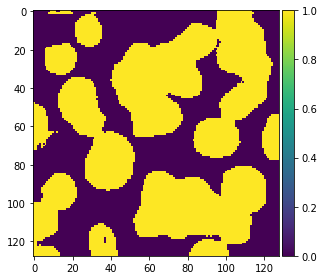

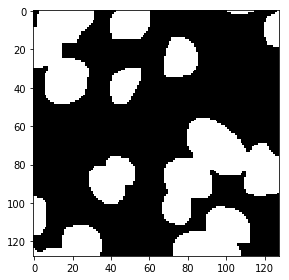

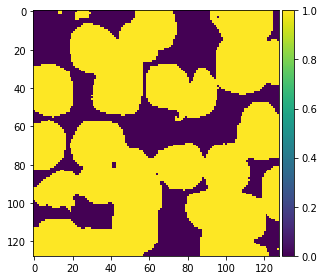

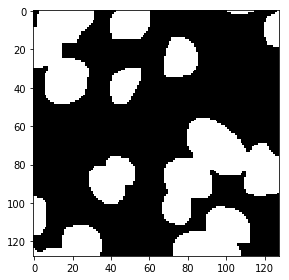

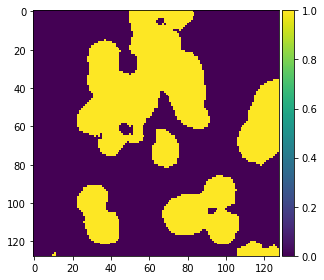

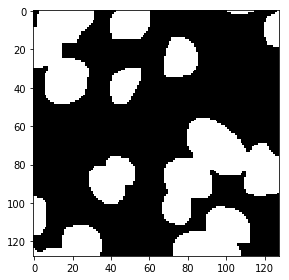

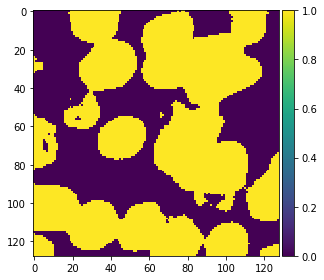

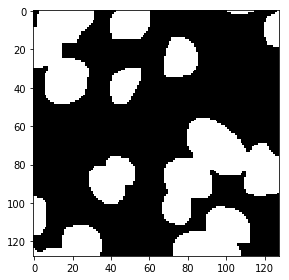

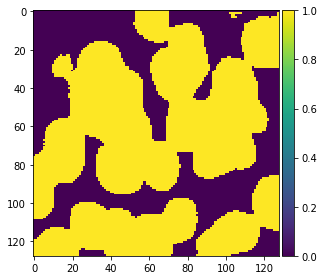

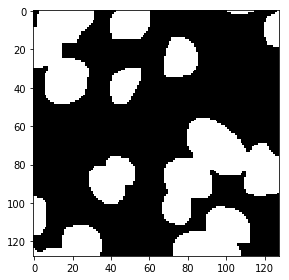

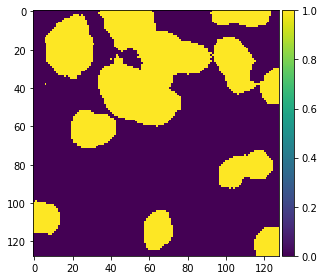

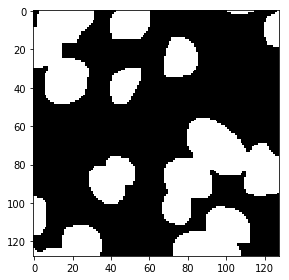

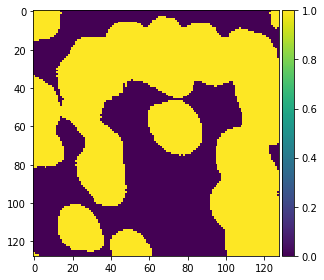

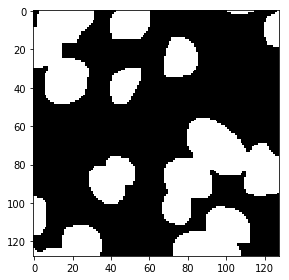

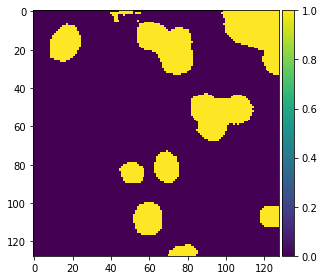

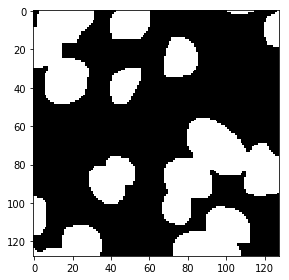

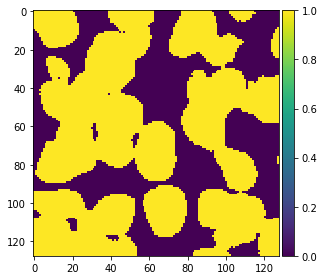

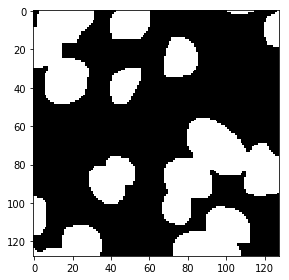

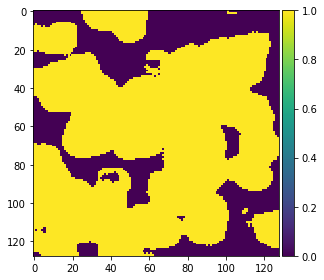

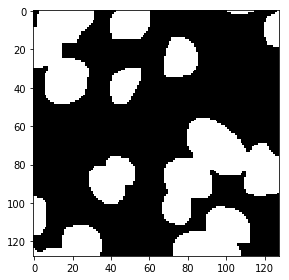

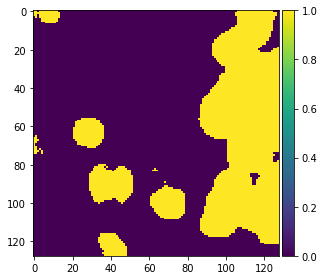

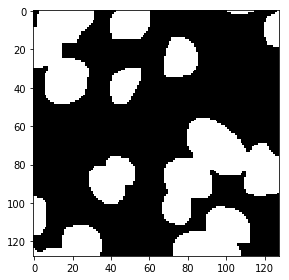

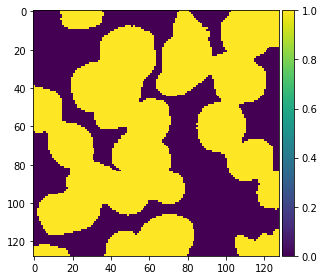

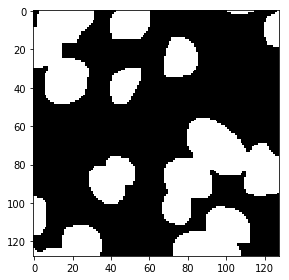

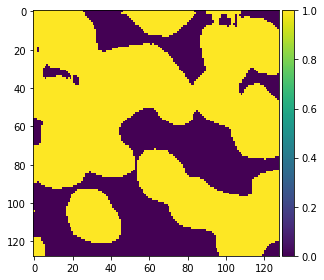

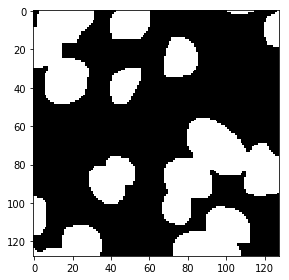

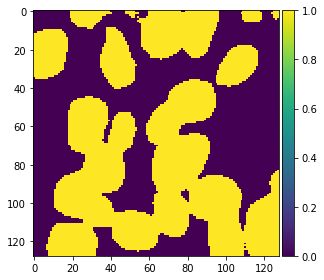

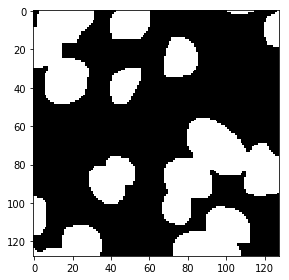

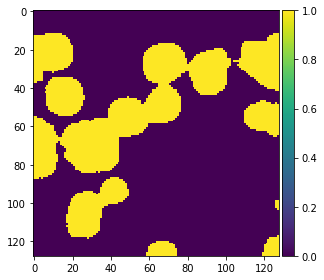

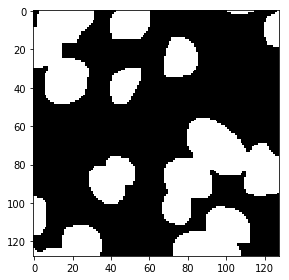

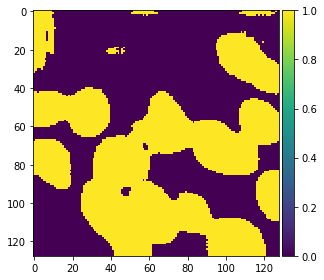

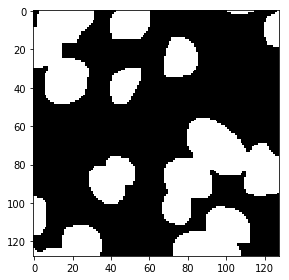

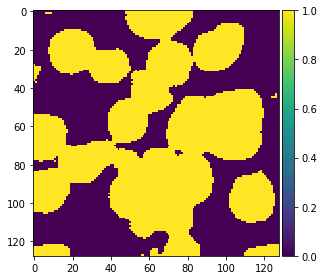

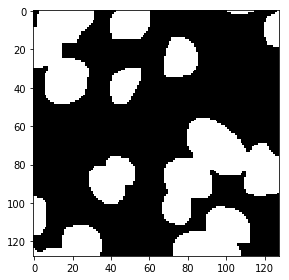

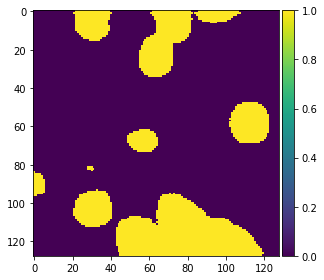

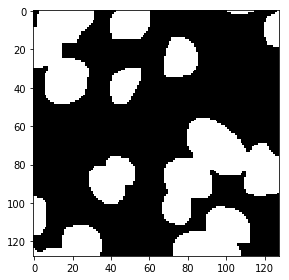

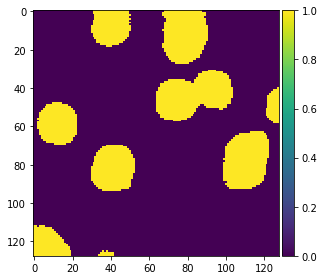

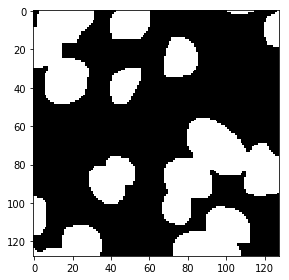

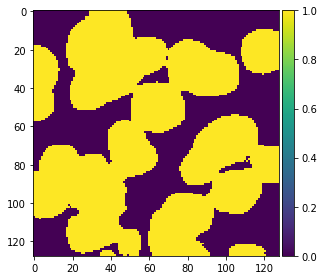

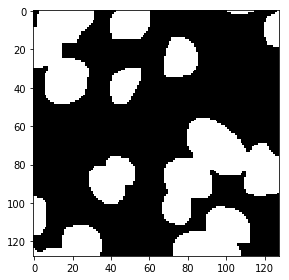

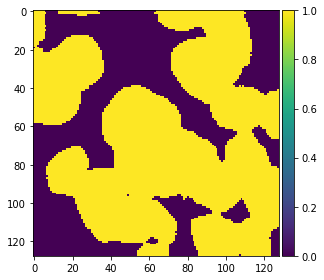

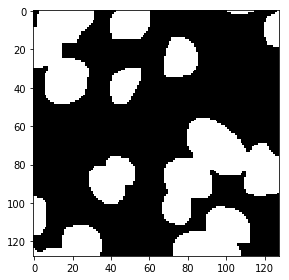

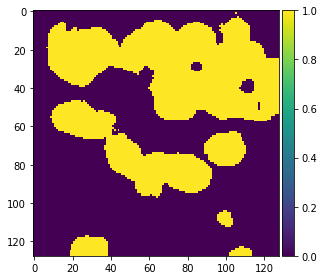

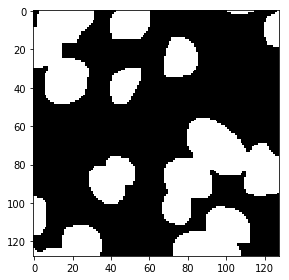

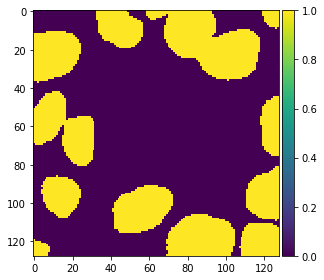

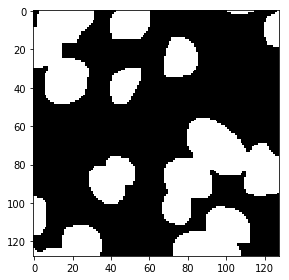

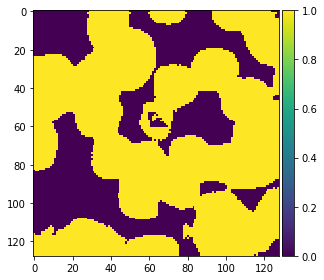

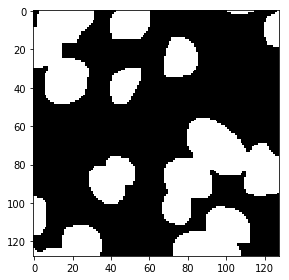

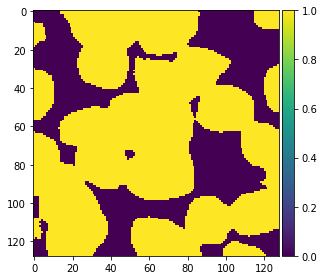

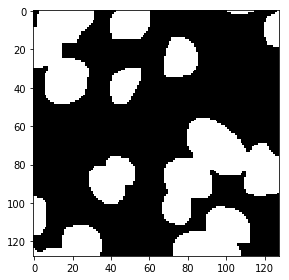

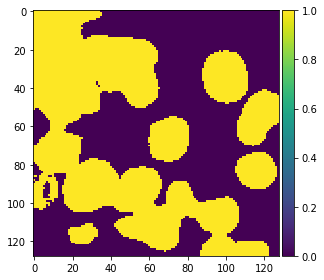

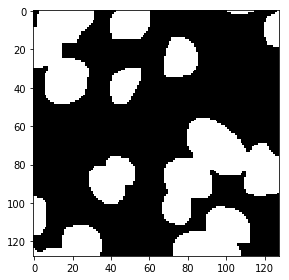

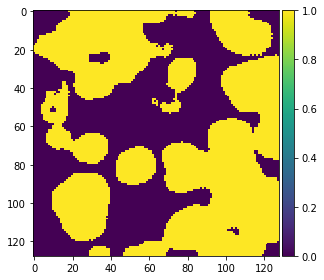

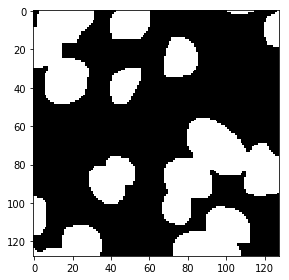

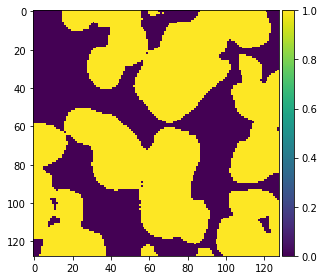

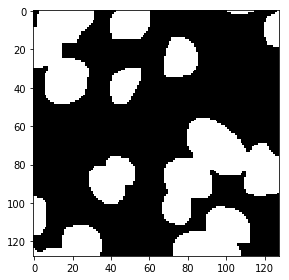

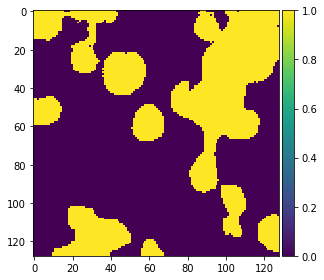

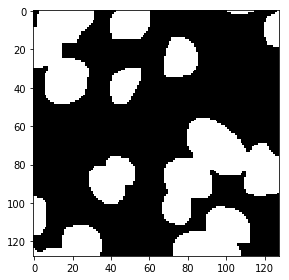

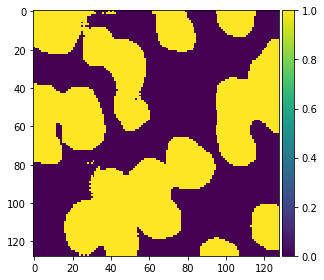

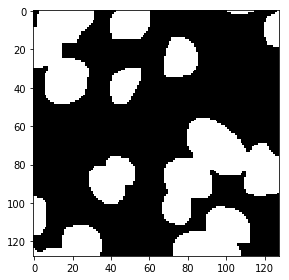

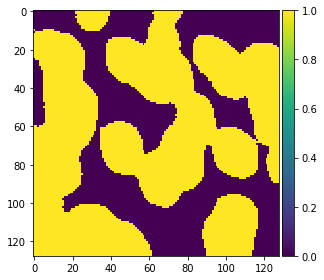

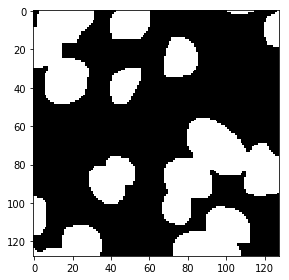

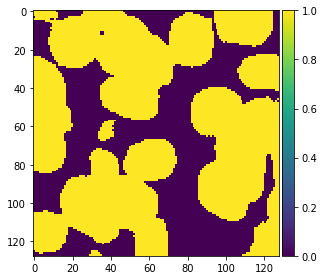

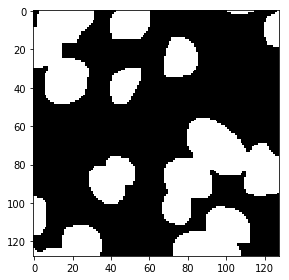

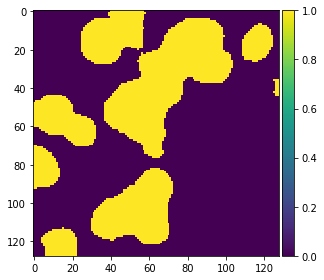

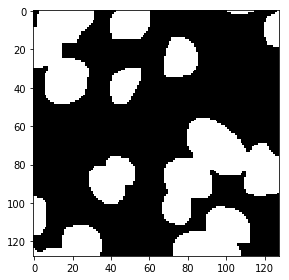

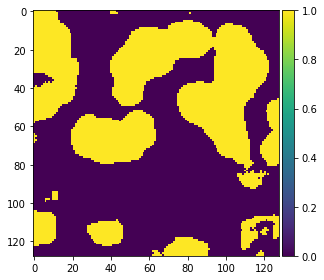

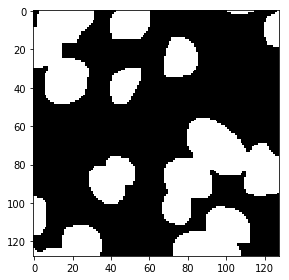

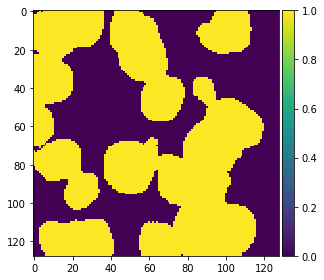

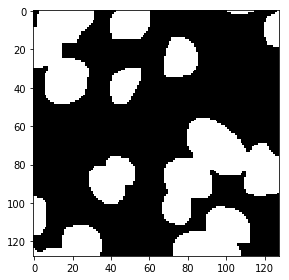

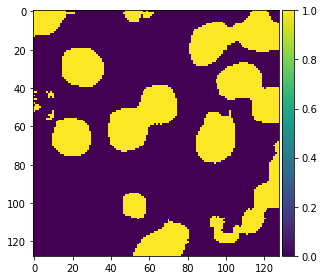

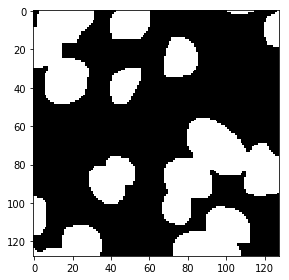

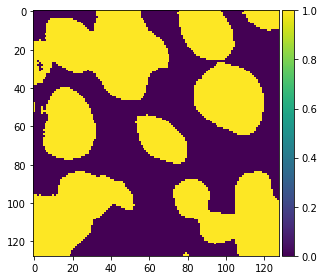

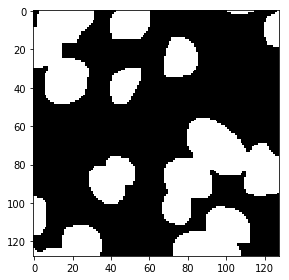

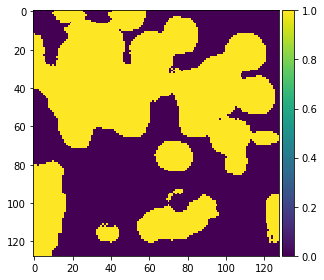

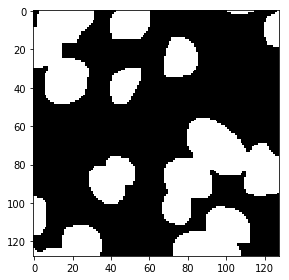

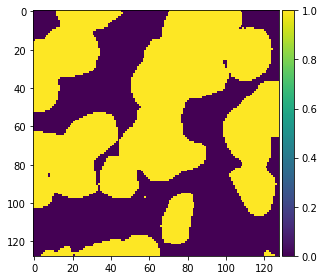

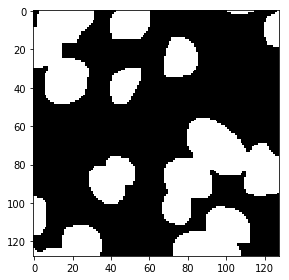

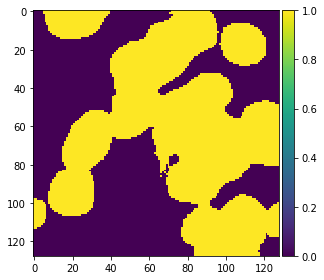

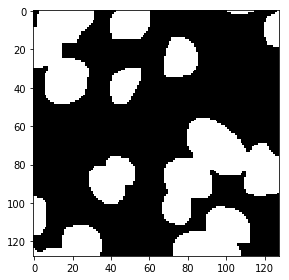

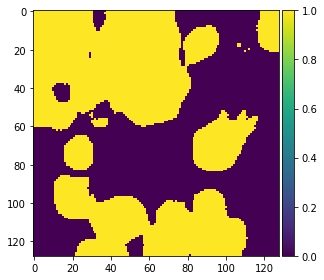

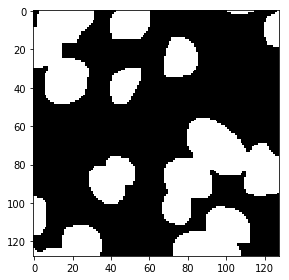

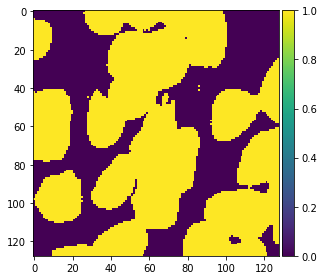

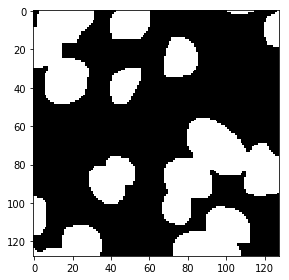

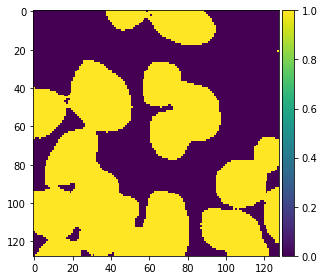

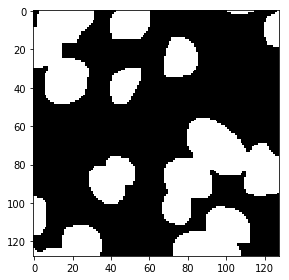

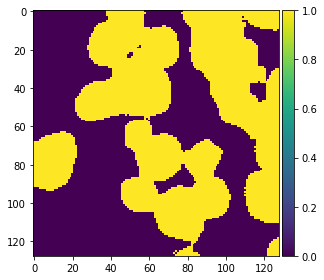

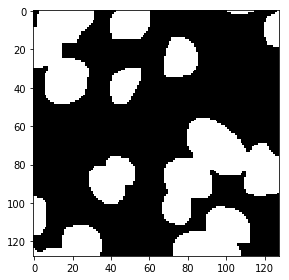

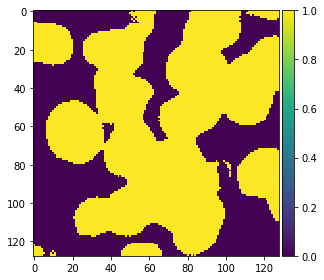

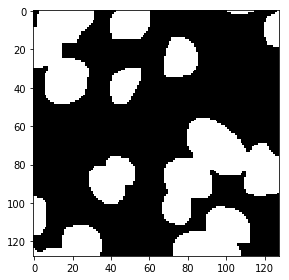

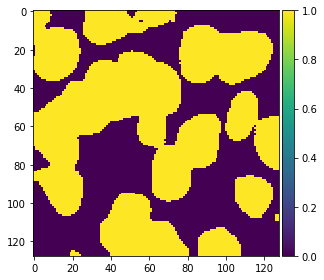

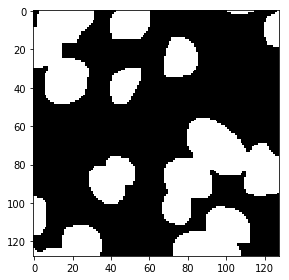

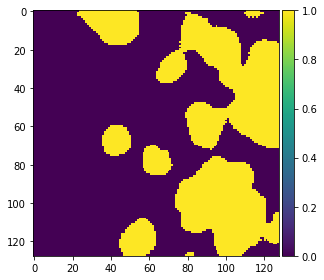

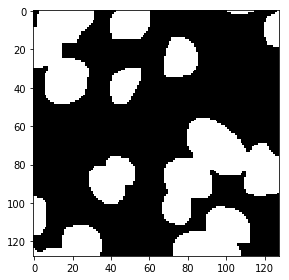

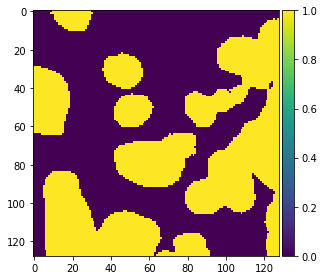

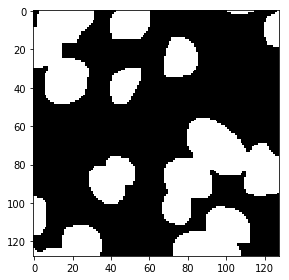

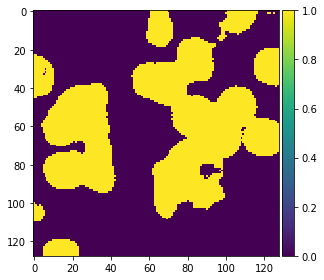

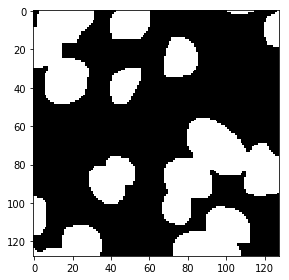

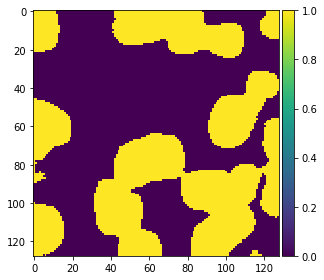

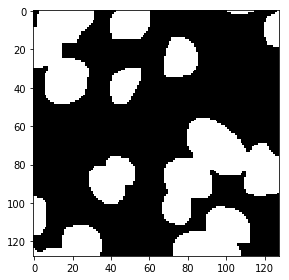

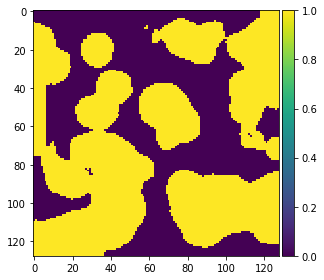

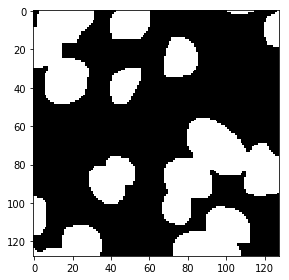

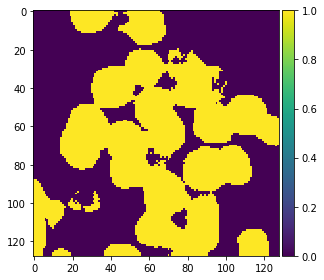

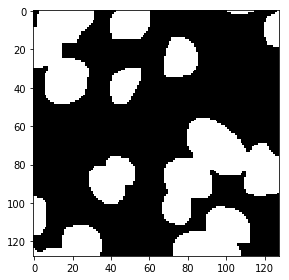

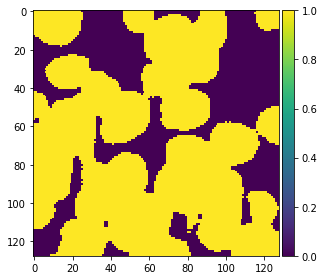

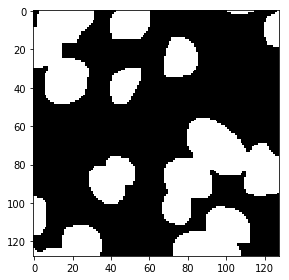

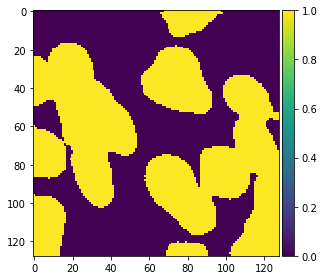

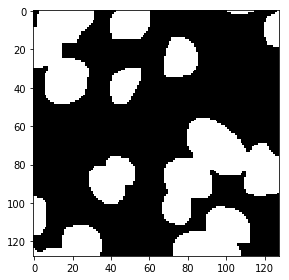

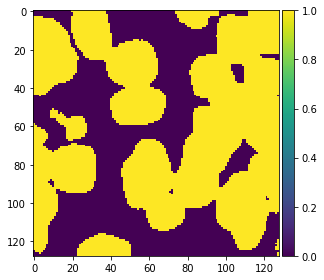

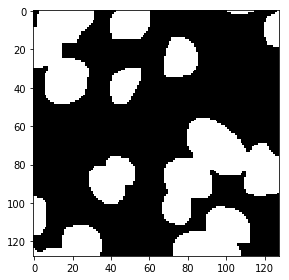

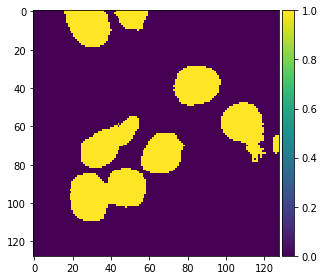

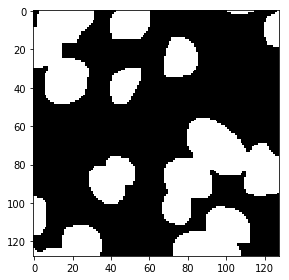

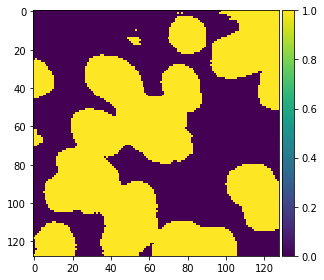

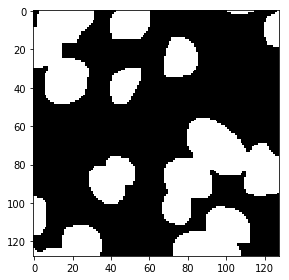

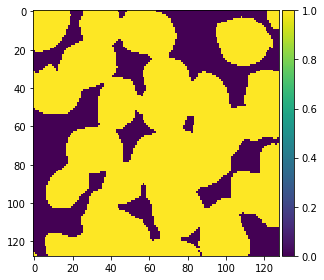

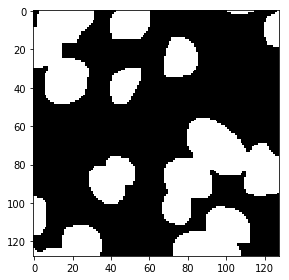

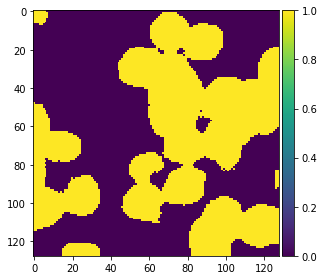

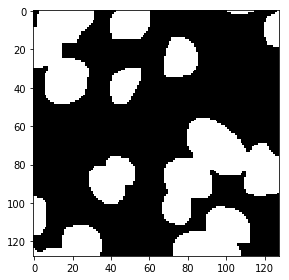

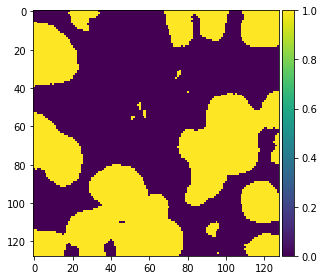

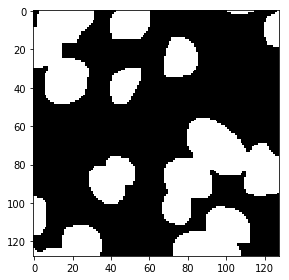

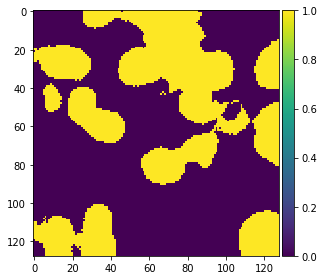

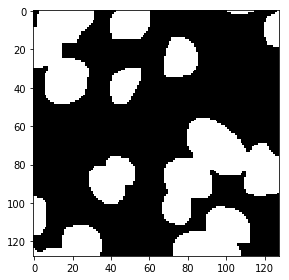

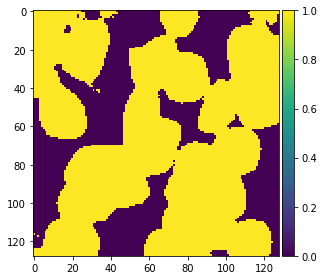

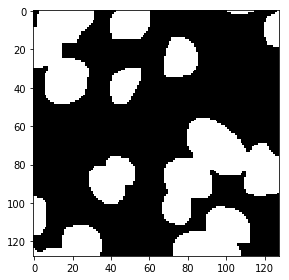

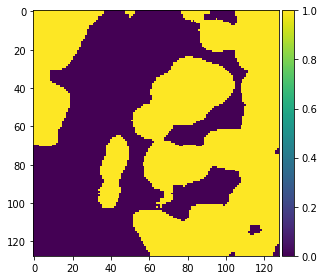

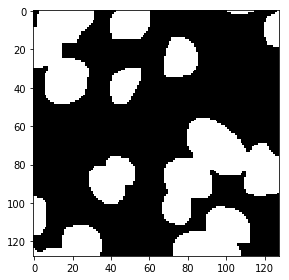

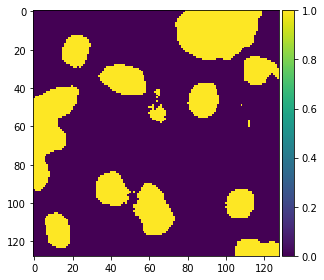

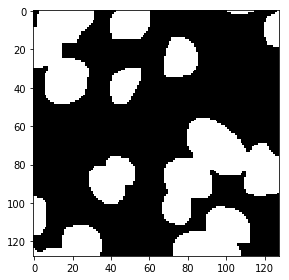

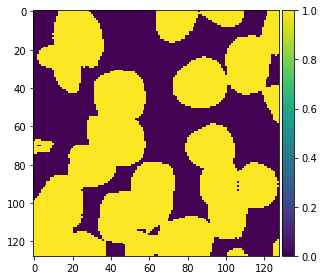

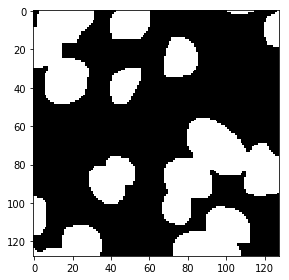

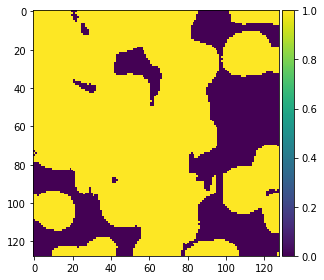

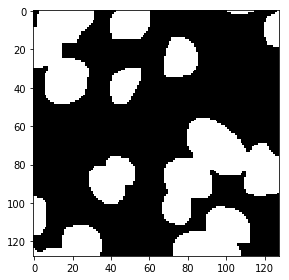

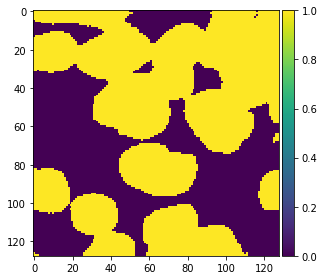

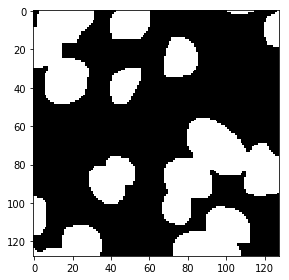

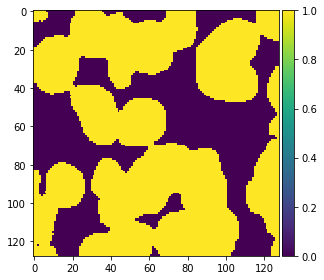

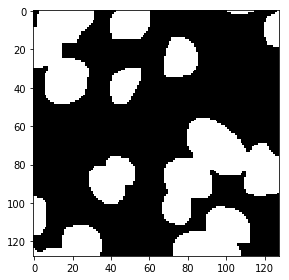

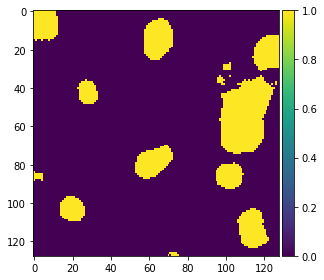

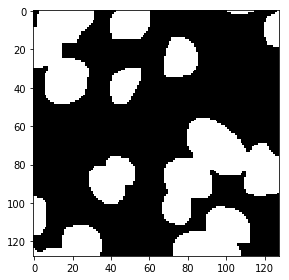

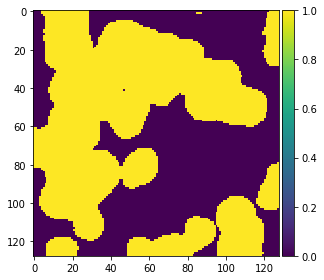

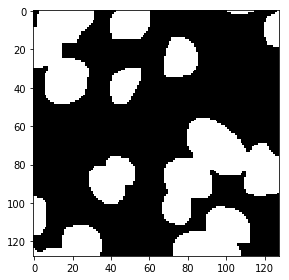

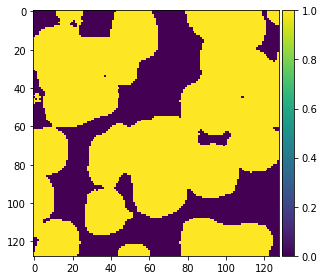

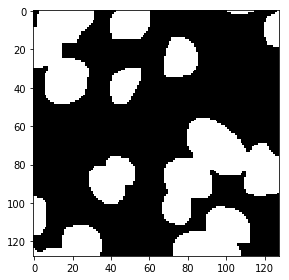

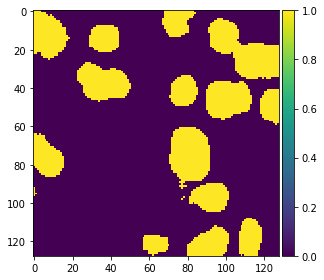

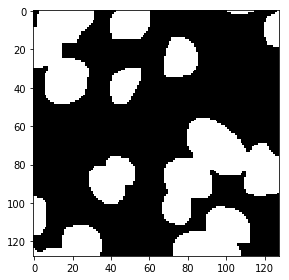

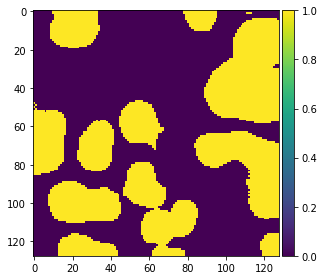

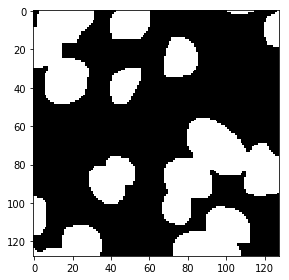

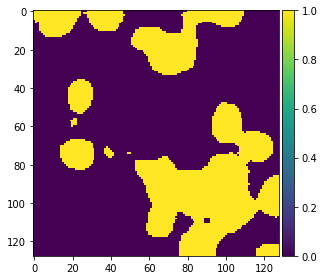

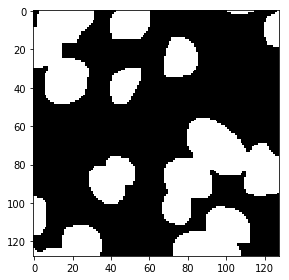

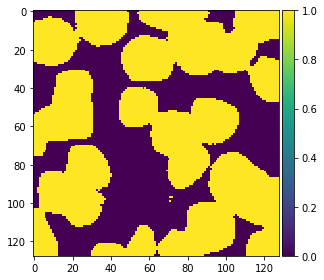

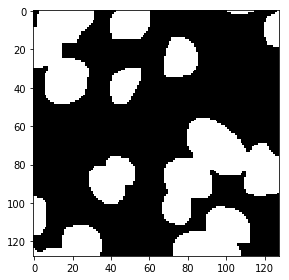

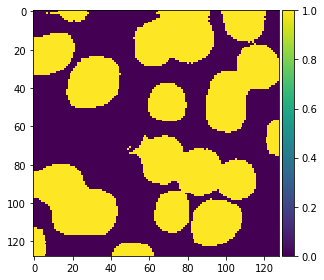

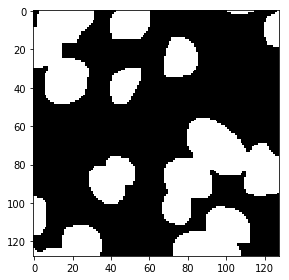

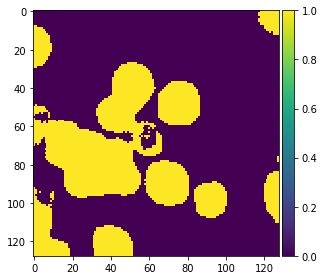

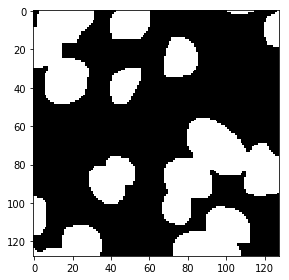

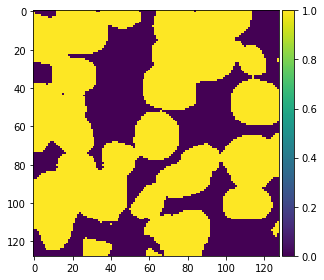

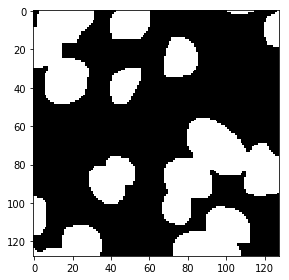

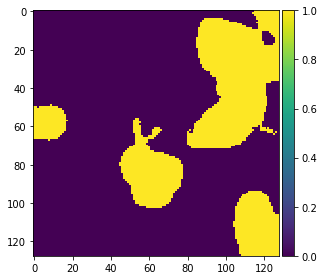

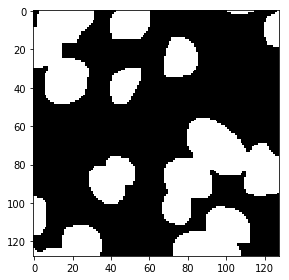

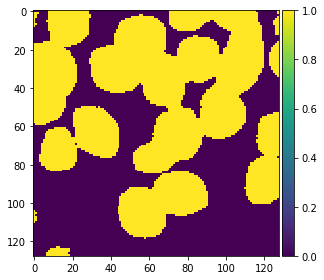

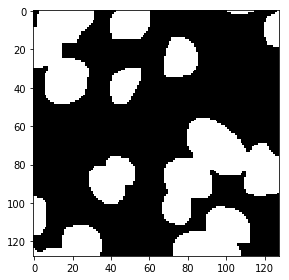

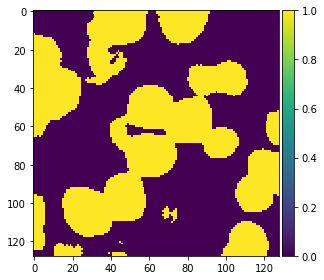

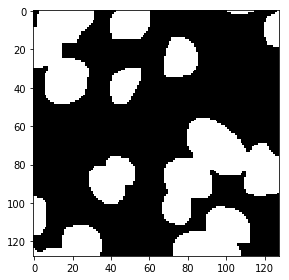

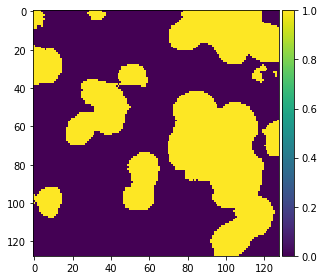

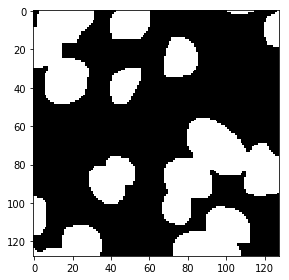

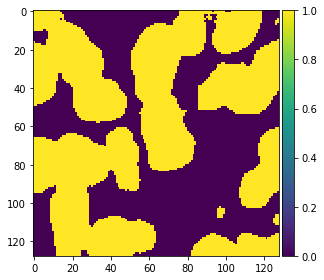

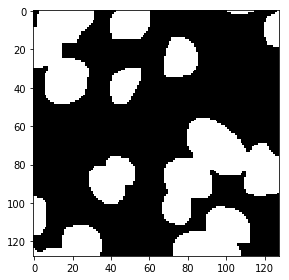

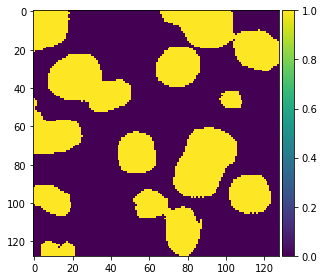

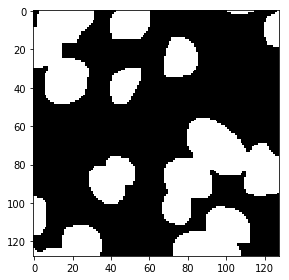

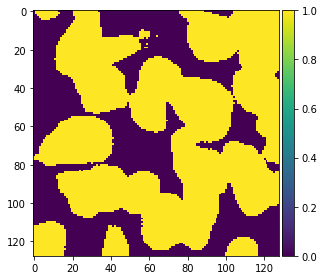

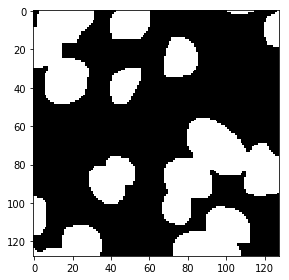

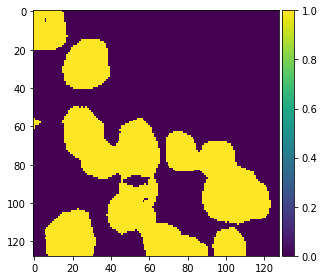

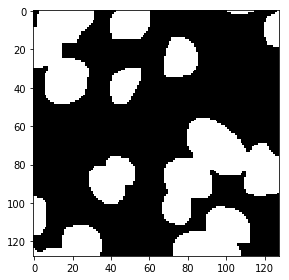

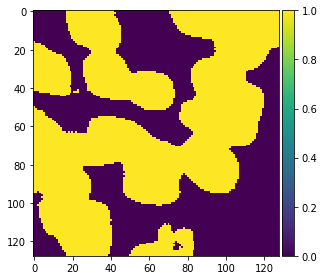

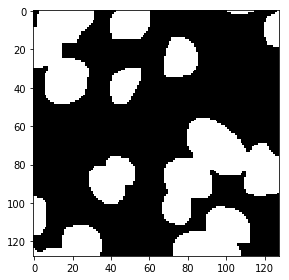

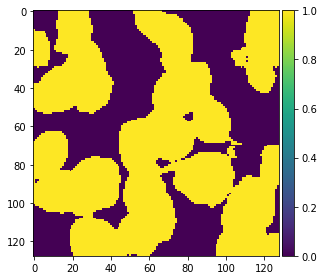

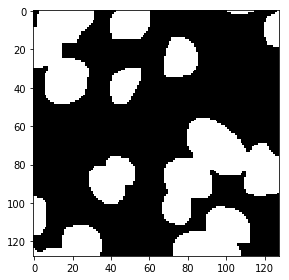

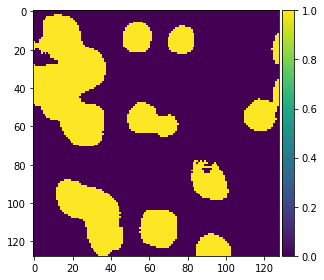

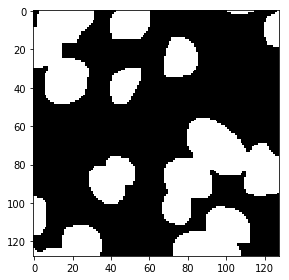

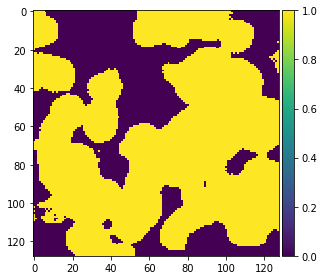

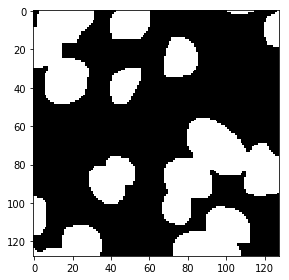

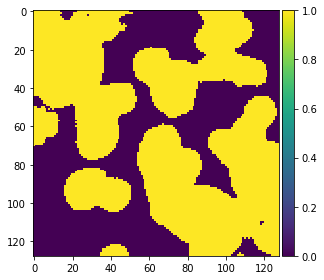

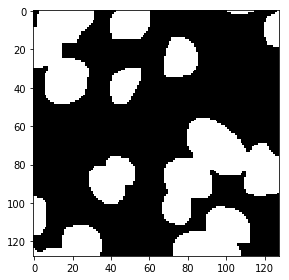

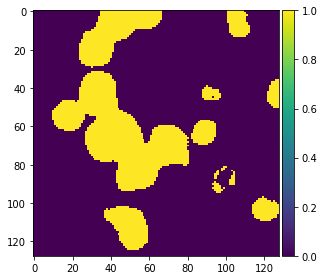

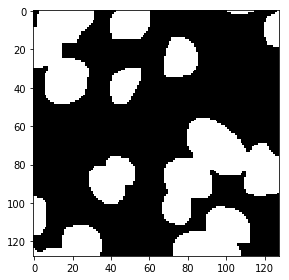

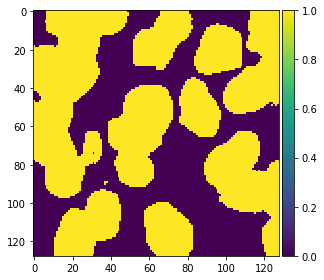

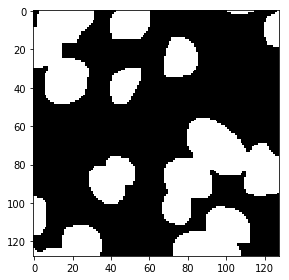

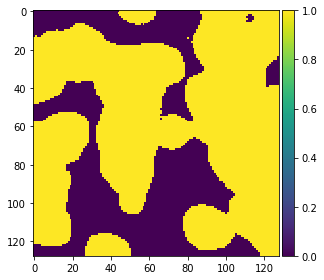

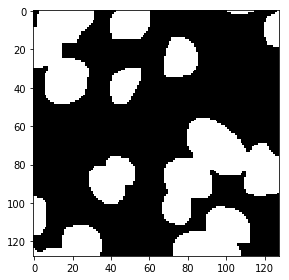

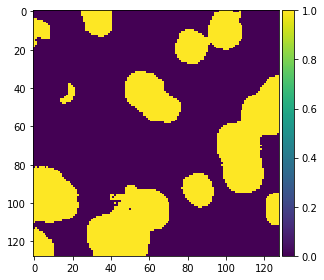

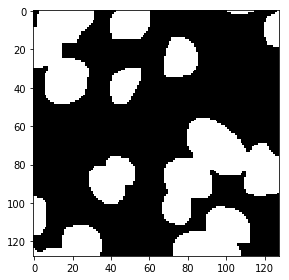

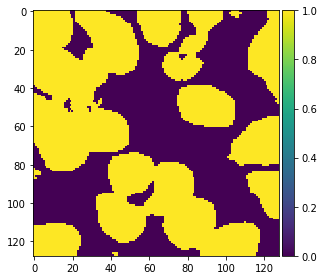

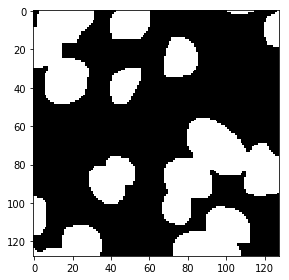

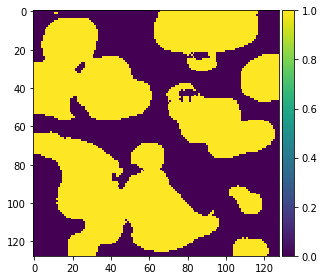

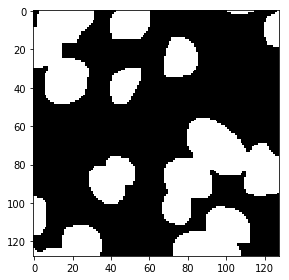

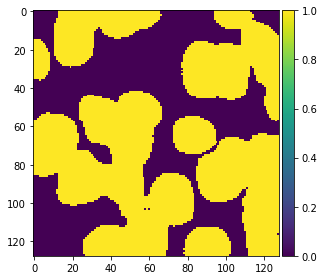

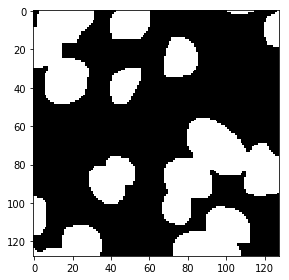

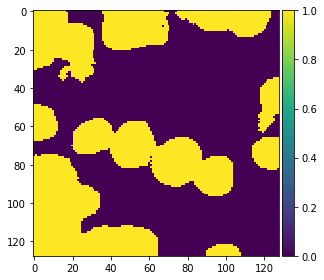

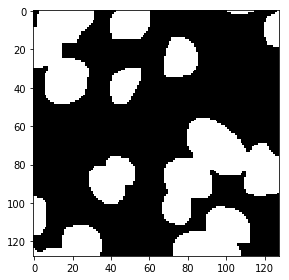

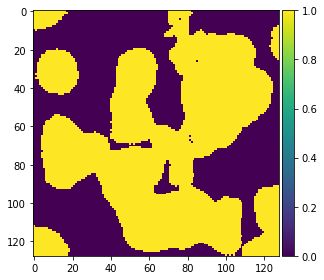

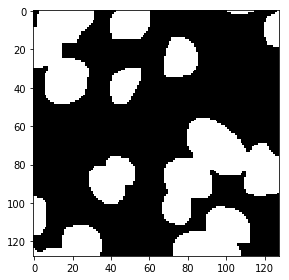

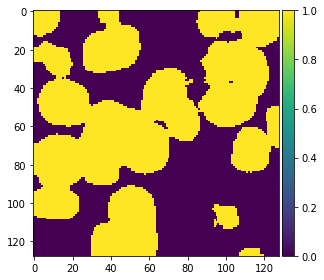

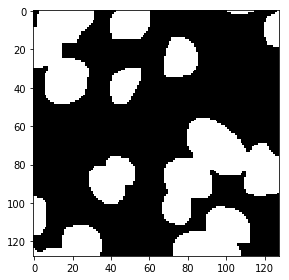

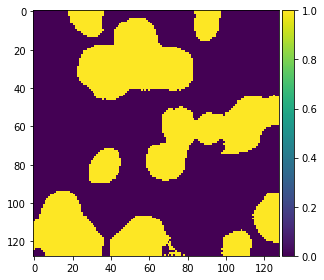

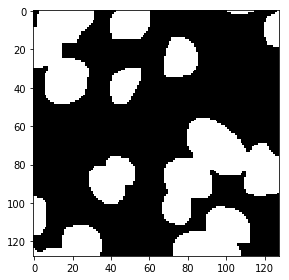

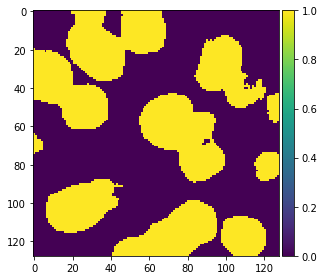

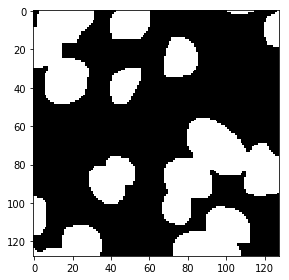

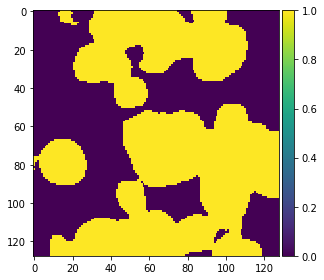

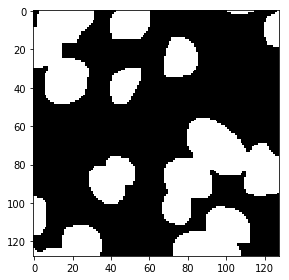

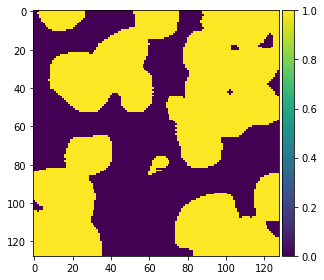

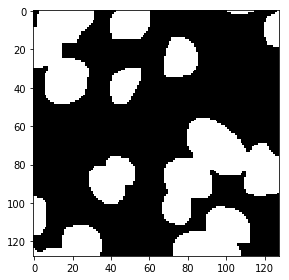

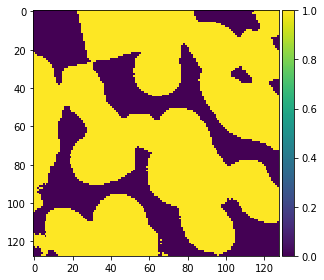

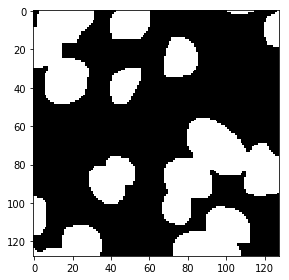

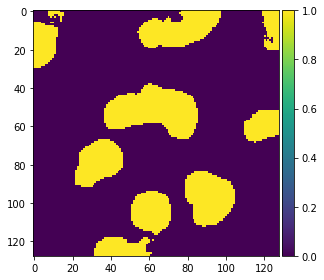

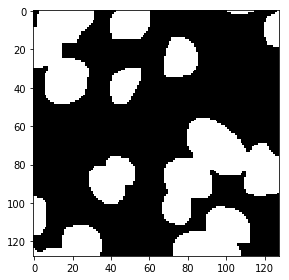

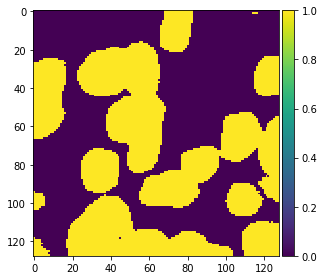

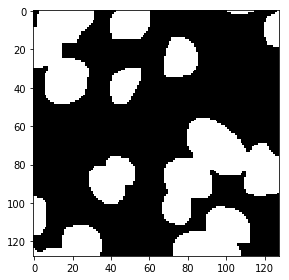

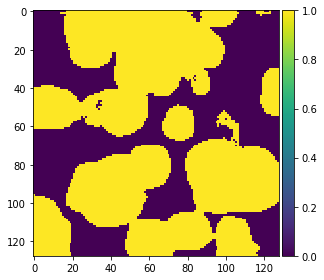

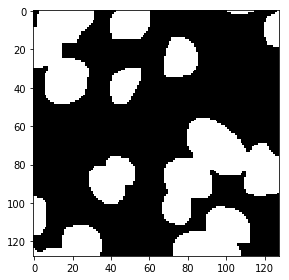

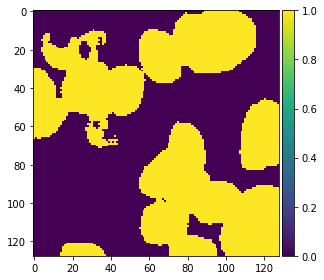

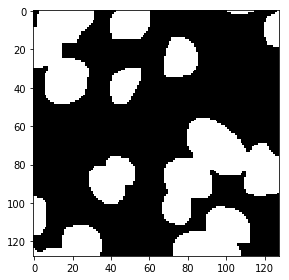

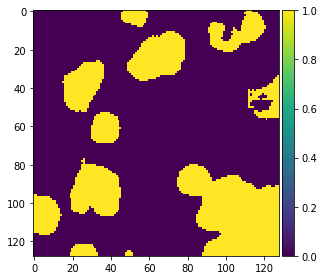

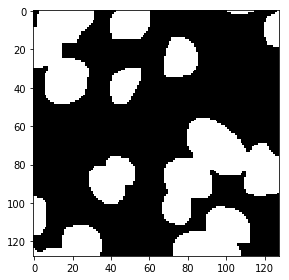

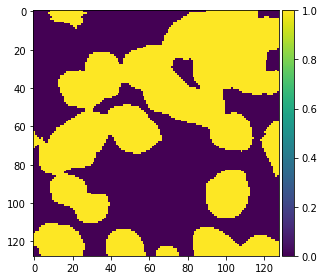

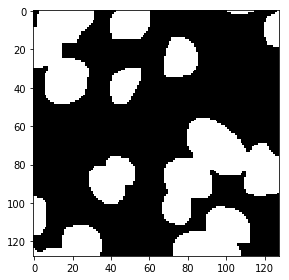

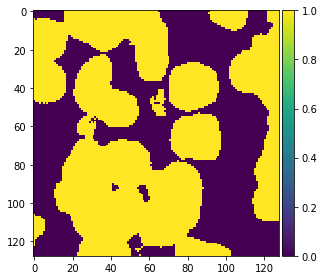

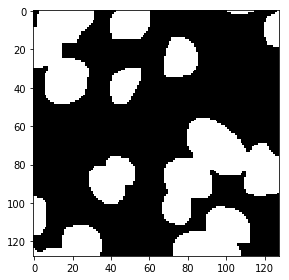

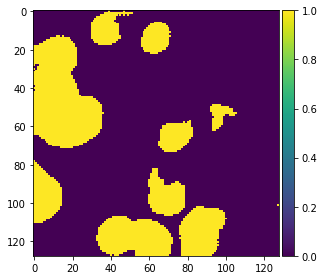

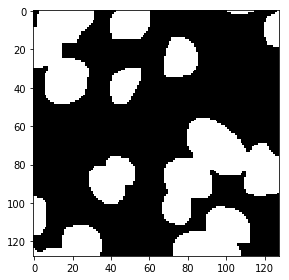

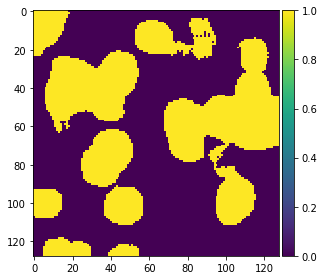

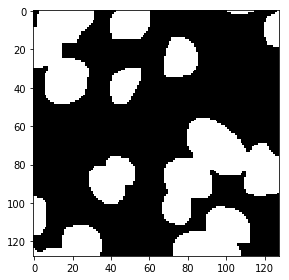

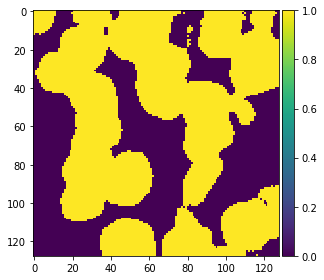

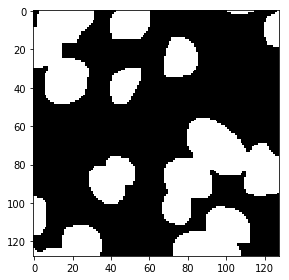

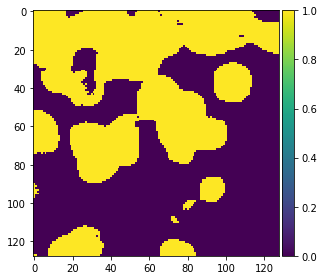

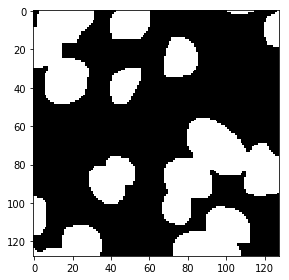

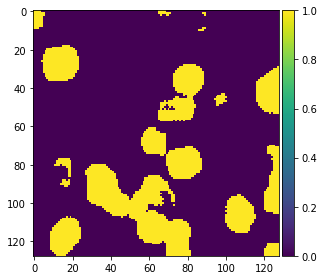

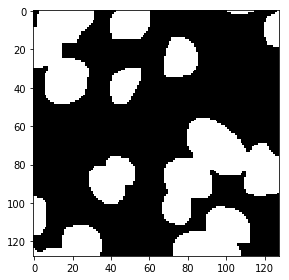

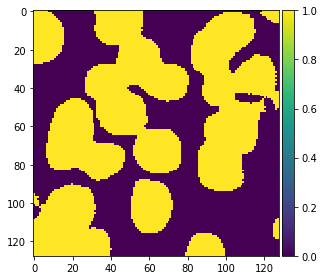

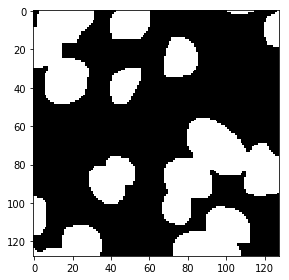

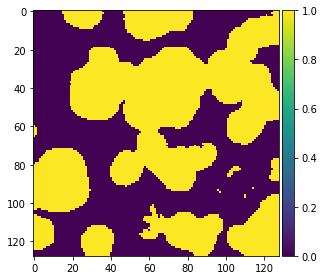

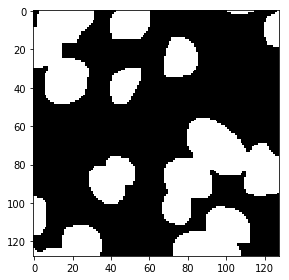

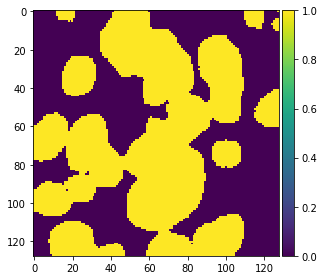

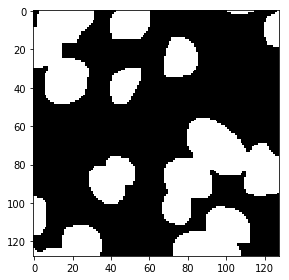

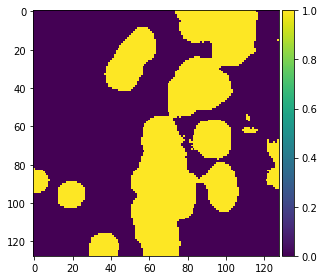

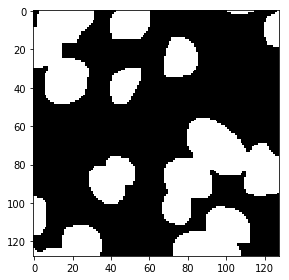

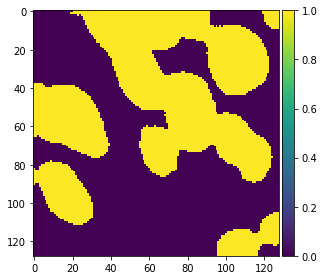

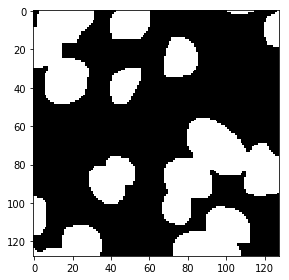

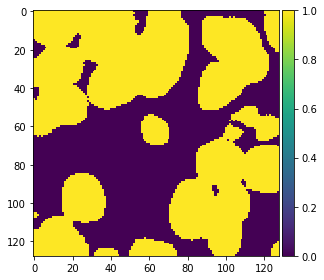

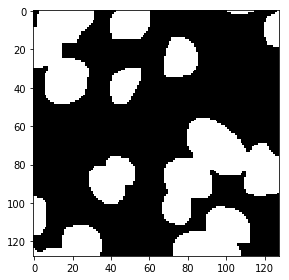

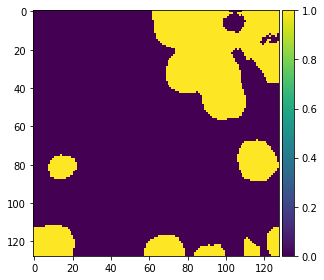

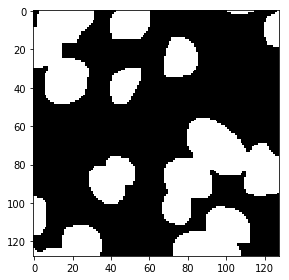

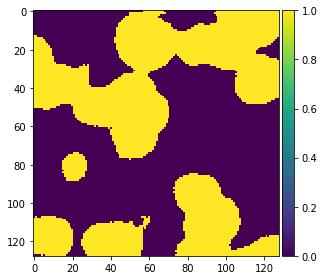

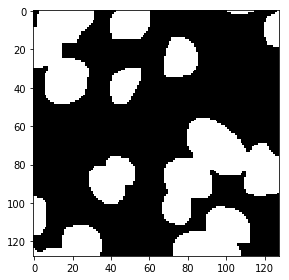

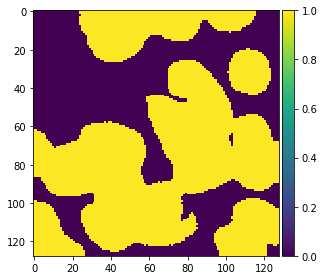

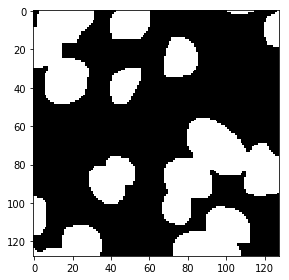

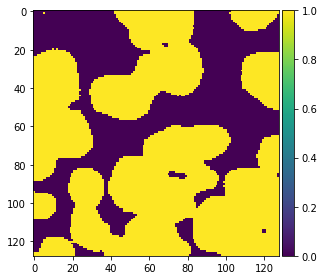

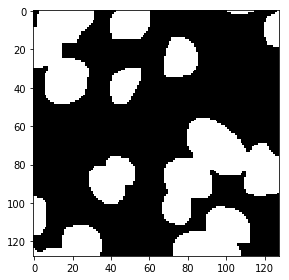

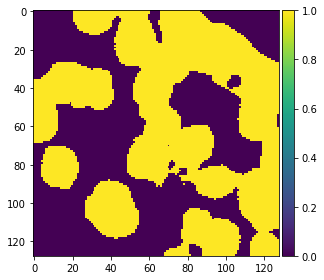

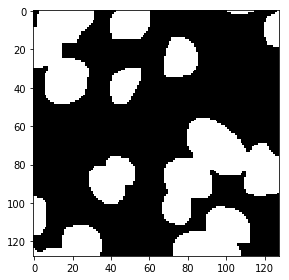

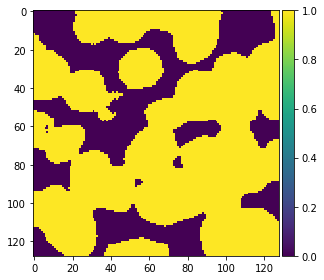

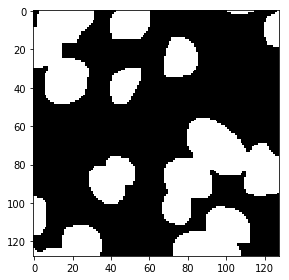

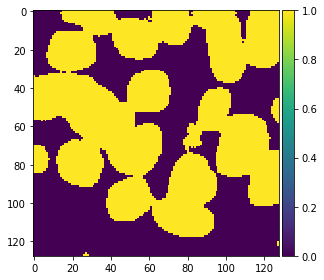

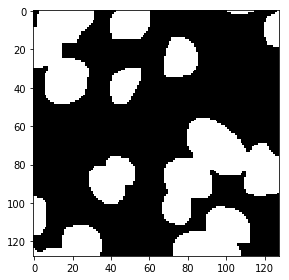

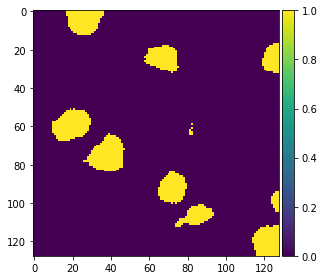

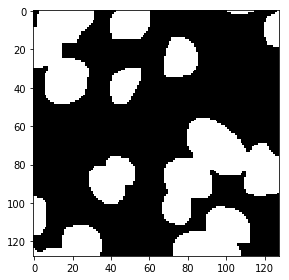

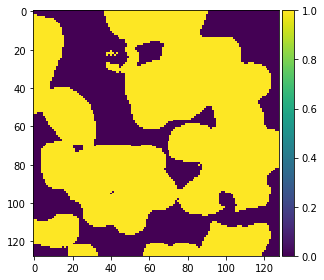

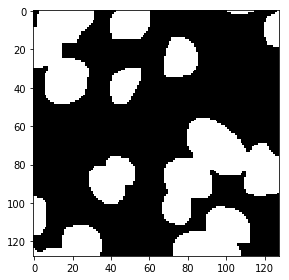

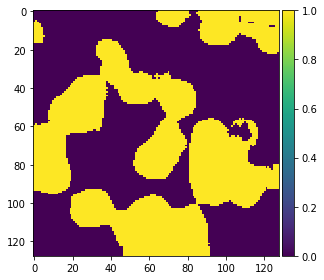

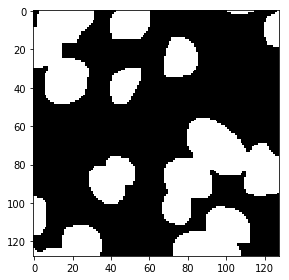

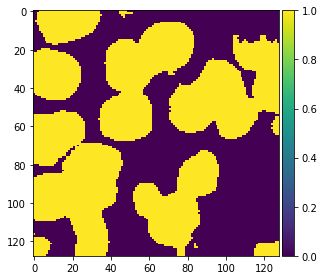

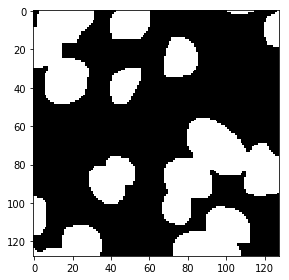

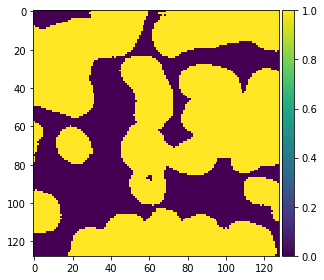

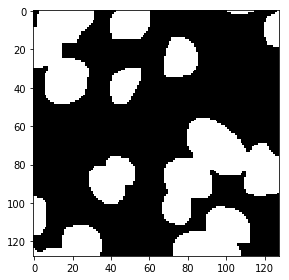

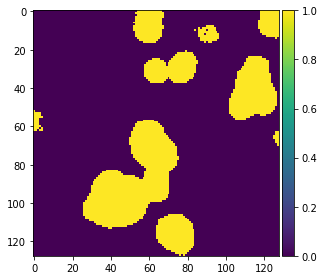

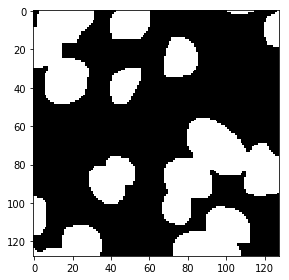

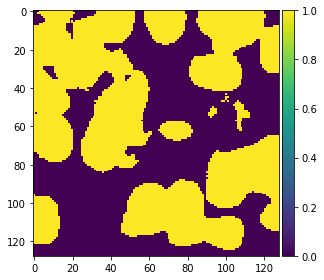

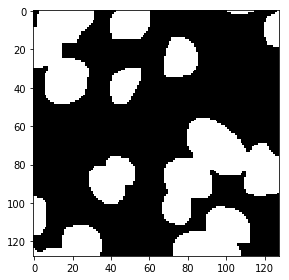

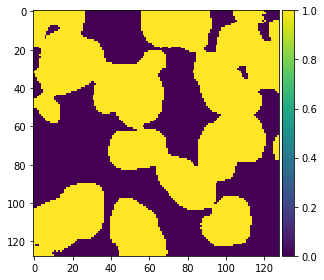

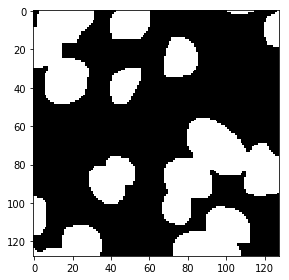

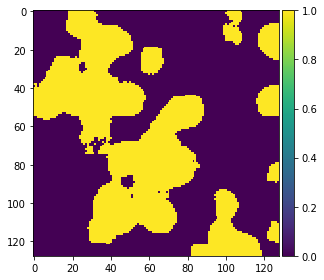

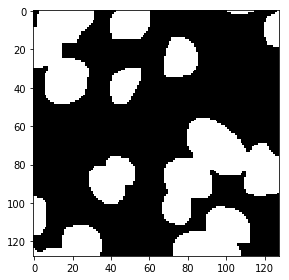

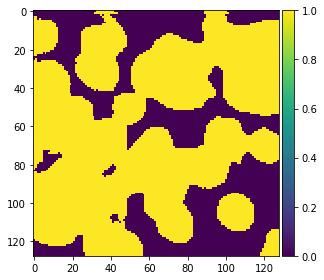

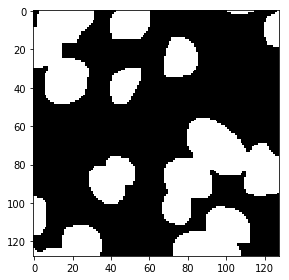

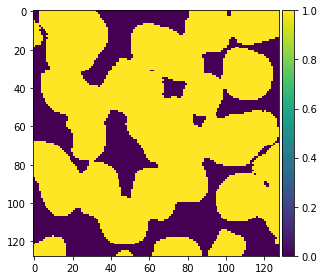

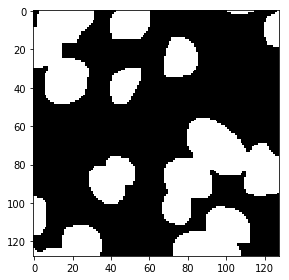

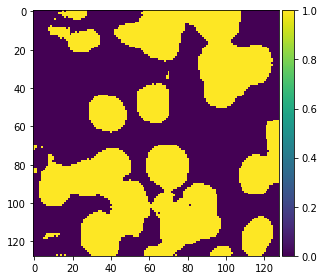

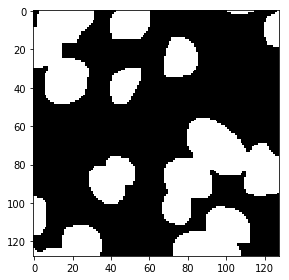

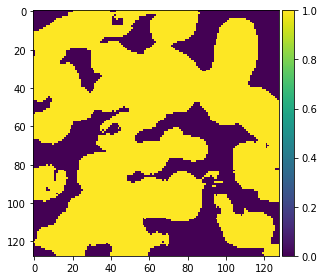

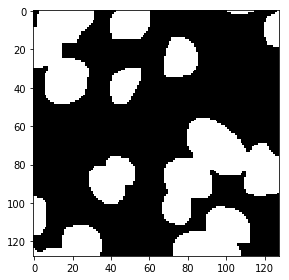

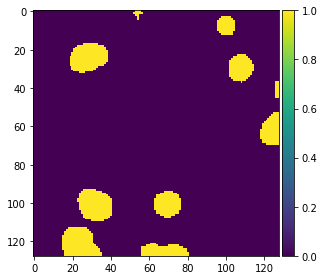

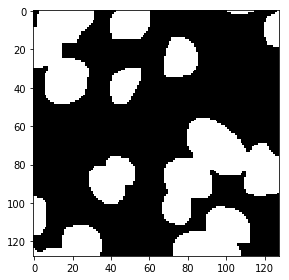

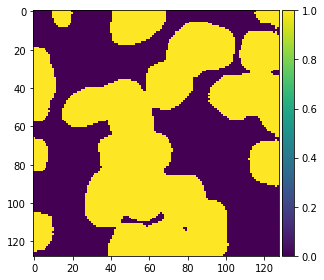

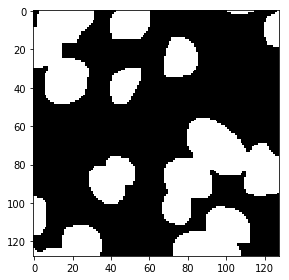

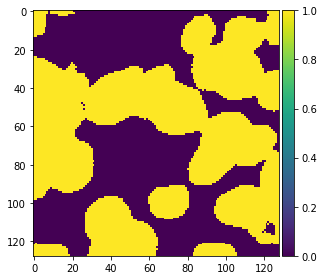

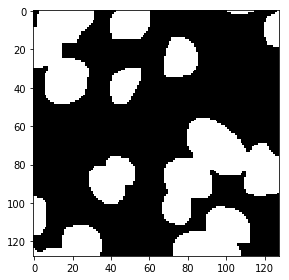

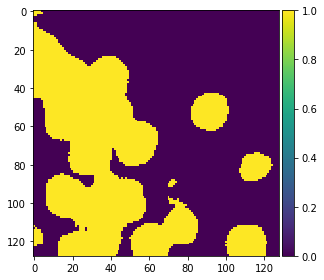

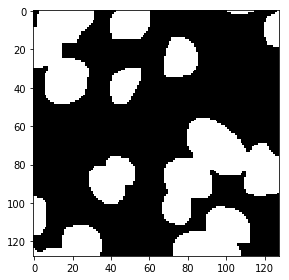

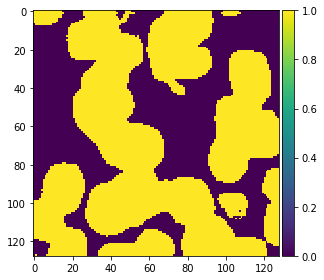

In [144]:
for ix in range(0,len(preds_test_t) -1):
    #imshow(X_train[int(X_train.shape[0]*0.9):][ix])
    #plt.show()
    imshow(np.squeeze(Y_test[ix]))
    plt.show()
    imshow(np.squeeze(preds_test_t[ix]))
    plt.show()

In [127]:
import imageio
from skimage.util.shape import view_as_windows
train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images')]
print('Splitting training img ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(train_ids), total=len(train_ids)):
    path = TRAIN_PATH
    if os.path.isfile(path + '/images/' + id_ + '.tif'):
        img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
        window_shape = (128, 128,3)
        B = view_as_windows(img[50:950,50:950,:], window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'images','tmp',id_ + "-%s-%s.png" % (i,j))
                imageio.imwrite(tmp_path, B[i,j,0])

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = np.load(path + '/masks/' + id_ + '.npy')
        mask_window_shape = (128, 128)
        C = view_as_windows(mask_, mask_window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'masks','tmp',id_ + "-%s-%s.npy" % (i,j))
                np.save(tmp_path, C[i,j])
        #mask = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
        #                             preserve_range=True), axis=-1)
        #Y_train[n] = mask

Splitting training img ... 


  0%|          | 0/26 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:2573: RuntimeWarning: py_decodelzw encountered unexpected end of stream
  tile = decompress(tile)
/usr/local/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 26/26 [00:23<00:00,  1.13it/s]


In [128]:

train_ids = [x[:-4] for x in os.listdir(TRAIN_PATH + '/images')]
test_ids = [x[:-4] for x in os.listdir(TEST_PATH + '/images')]
print('Spliting test images and masks ... ')
sys.stdout.flush()
for n, id_ in tqdm(enumerate(test_ids), total=len(test_ids)):
    path = TEST_PATH
    if os.path.isfile(path + '/images/' + id_ + '.tif'):
        
        img = imread(path + '/images/' + id_ + '.tif')[:,:,:IMG_CHANNELS]
        window_shape = (128, 128,3)
        B = view_as_windows(img[50:950,50:950,:], window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'images','tmp',id_ + "-%s-%s.png" % (i,j))
                imageio.imwrite(tmp_path, B[i,j,0])

        mask = np.zeros((IMG_HEIGHT, IMG_WIDTH, 1), dtype=np.bool)

        mask_ = np.load(path + '/masks/' + id_ + '.npy')
        mask_window_shape = (128, 128)
        C = view_as_windows(mask_, mask_window_shape,100)
        for i in range(0,8):
            for j in range(0,8):
                tmp_path=os.path.join(path,'masks','tmp',id_ + "-%s-%s.npy" % (i,j))
                np.save(tmp_path, C[i,j])
    #mask = np.expand_dims(resize(mask_, (IMG_HEIGHT, IMG_WIDTH), mode='constant',
    #                             preserve_range=True), axis=-1)
    #Y_train[n] = mask

Spliting test images and masks ... 


  0%|          | 0/8 [00:00<?, ?it/s]/usr/local/lib/python3.6/site-packages/skimage/util/shape.py:247: RuntimeWarning: Cannot provide views on a non-contiguous input array without copying.
  warn(RuntimeWarning("Cannot provide views on a non-contiguous input "
100%|██████████| 8/8 [00:05<00:00,  1.58it/s]
